# Cálculo de taxa de fecundidade

## Preparação do Notebook

Na célula adiante são feitos procedimentos de preparação do notebook para trabalho com os dados, tais como:
1. mapeamento do diretório em que se encontra o pacote br_demography;
2. importação de bibliotecas necessárias para processamento dos dados;
3. carregametno de project_id para faturamento no Google Cloud, conforme requerido pela biblioteca basedosdados.

In [1]:
# adicionando br_demography to Python Path
import sys 
sys.path.append("../../")

# carregamento de bibliotecas para processamento dos dados
from br_demography  import municipality_births as mb
import basedosdados as bd
from dotenv import load_dotenv
import os
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração
import warnings
import scipy

# Carregando as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='../../.env')

# Carregando o project_id para faturamento no Google Cloud
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

### Carregamento, tratamento e salvamento de microdados sobre nascidos vivos

Com base nos dados do SINASC, sao realizados os seguintes processamentos:
1. carregamento do arquivo com os municípios de interesse;
2. _loop_ para cada município de interesse;
3. download dos microdados SINASC por consulta SQL à _DataLake_ da Base dos Dados;
4. tratamento dos dados (padronização de faixas etárias decenais, indexação, inserção de valor "0" para coortes com valor nulo, padronização de tipagem, adequação de colunas, etc.);
5. concatenação dos dados de cada município no DataFrae df_births
6. salvamento dos no arquivo nascimentos_rmc_2000_2022.csv

In [2]:
# Carregamento de arquivo CSV com rol de municípios de Interesse
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')

# geração de dicionário que receberá cada dataframe com dados para cada município
dict_dfs = dict()

# loop de iteração para obtenção e tratamento de dados de município constante no dataframe df_mun
for mun_id, mun in df_mun.itertuples():
    print(mun)
    #download de microdados de nascidos vivos por idade da mãe
    df_births_mun = mb.query_births(mun_id=mun_id, project_id=project_id, start_year=2000, end_year=2022)

    #tratamento dos microdados
    df_births_mun = mb.standard_age_groups(df=df_births_mun, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_maes.csv')
    df_births_mun = df_births_mun.reset_index().pivot_table(columns=['Ano'], index=['Faixa Etária'], values=['Nascimentos'])
    df_births_mun = df_births_mun.droplevel(level=0, axis=1)
    df_births_mun.columns.name = None
    df_births_mun['Município'] = mun
    df_births_mun = df_births_mun.reset_index().set_index(['Município', 'Faixa Etária'])
    
    # atribuição do DataFrame df_births_mun de cada município, a sua chave no dicionário dict_dfs
    dict_dfs[mun] = df_births_mun

# concatenaçao de todos os DataFrames constanntes no dicionário dict_dfs
df_births = pd.concat(objs=dict_dfs.values())

# Adequação da tipagem do nome das colunas no DataFrame df_births
df_births.columns = df_births.columns.astype(int)

# salvamento dos dados resultantes em arquivo csv
df_births.to_csv(path_or_buf='../../br_demography/results/tab/nascimentos_rmc_2000_2022.csv', sep=';', decimal=',', encoding='utf-16')

Adrianópolis


### Visualização parcial do DataFrame df_births, com microdados de nascidos vivos por idade da mãe

In [ ]:
df_births.iloc[np.r_[0:2, -2:0]]

2000  2001  2002  2003  2004  2005  2006  2007  \
Município      Faixa Etária                                                   
Adrianópolis   10 a 19 anos    22    18    17    25    31    25    19    25   
               20 a 29 anos    38    37    39    42    27    48    37    41   
Doutor Ulysses 30 a 39 anos    15    17    27    26    26    16    20    17   
               40 a 49 anos     2     9     7     5     3     5     3     0   

                             2008  2009  ...  2013  2014  2015  2016  2017  \
Município      Faixa Etária              ...                                 
Adrianópolis   10 a 19 anos    22    25  ...    22    21    13    14    23   
               20 a 29 anos    47    48  ...    27    25    40    36    52   
Doutor Ulysses 30 a 39 anos    12    16  ...    18    14    12    20    14   
               40 a 49 anos     4     3  ...     1     1     0     1     0   

                             2018  2019  2020  2021  2022  
Município      Faixa Etária                                
Adrianópolis   10 a 19 anos    16     6    15    13    12  
               20 a 29 anos    35    26    39    37    34  
Doutor Ulysses 30 a 39 anos    18    18    20    17    25  
               40 a 49 anos     1     4     2     4     0  

[4 rows x 23 columns]

### Carregamento dos dados de população entre 2000 e 2022 e filtragem de dados do sexo feminino  

In [ ]:
df_pop = pd.read_csv(filepath_or_buffer='../../br_demography/results/tab/pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv', sep=';')
df_pop = df_pop[df_pop['Sexo'] == 'Feminino'].drop(columns=['Sexo'])
df_pop = df_pop[df_pop['Faixa Etária'].isin(values=df_births.reset_index()['Faixa Etária'].values)]
df_pop.set_index(keys=['Município', 'Faixa Etária'], inplace=True)
df_pop.columns = df_pop.columns.astype(int)
df_pop.iloc[np.r_[0:2, -2:0]]

2000  2001  2002  2003  2004  2005  2006  2007  \
Município      Faixa Etária                                                   
Adrianópolis   10 a 19 anos   823   798   775   752   730   708   687   667   
               20 a 29 anos   437   435   434   433   431   430   429   427   
Doutor Ulysses 30 a 39 anos   373   376   379   382   385   389   392   395   
               40 a 49 anos   228   234   241   248   255   262   269   277   

                             2008  2009  ...  2013  2014  2015  2016  2017  \
Município      Faixa Etária              ...                                 
Adrianópolis   10 a 19 anos   647   628  ...   576   565   555   545   534   
               20 a 29 anos   426   425  ...   413   410   406   403   400   
Doutor Ulysses 30 a 39 anos   399   402  ...   407   408   409   409   410   
               40 a 49 anos   285   293  ...   322   329   337   344   352   

                             2018  2019  2020  2021  2022  
Município      Faixa Etária                                
Adrianópolis   10 a 19 anos   524   515   505   496   487  
               20 a 29 anos   396   393   390   387   384  
Doutor Ulysses 30 a 39 anos   411   411   412   413   414  
               40 a 49 anos   359   367   376   384   393  

[4 rows x 23 columns]

## Cálculo de Taxa de Fertilidade

In [ ]:
df_birth_rate_by_mothers_age_group = (df_births / df_pop).dropna(axis=0) * 1000
df_birth_rate_by_mothers_age_group.drop(columns=[2020, 2021, 2022], inplace=True)
df_birth_rate_by_mothers_age_group.iloc[np.r_[0:2, -2:0]]

2000       2001       2002       2003  \
Município       Faixa Etária                                               
Adrianópolis    10 a 19 anos  26.731470  22.556391  21.935484  33.244681   
                20 a 29 anos  86.956522  85.057471  89.861751  96.997691   
Tunas do Paraná 30 a 39 anos  50.251256  93.457944  69.565217  44.354839   
                40 a 49 anos   0.000000  13.698630   4.424779   8.583691   

                                   2004        2005       2006       2007  \
Município       Faixa Etária                                                
Adrianópolis    10 a 19 anos  42.465753   35.310734  27.656477  37.481259   
                20 a 29 anos  62.645012  111.627907  86.247086  96.018735   
Tunas do Paraná 30 a 39 anos  93.632959  114.583333  90.322581  59.880240   
                40 a 49 anos  12.448133    4.016064  15.564202  11.278195   

                                    2008        2009       2010       2011  \
Município       Faixa Etária                                                 
Adrianópolis    10 a 19 anos   34.003091   39.808917  40.983607  23.411371   
                20 a 29 anos  110.328638  112.941176  58.962264  85.714286   
Tunas do Paraná 30 a 39 anos   91.666667   69.587629  78.947368  92.636580   
                40 a 49 anos   10.909091   21.126761   6.802721  10.000000   

                                   2012       2013       2014       2015  \
Município       Faixa Etária                                               
Adrianópolis    10 a 19 anos  42.589438  38.194444  37.168142  23.423423   
                20 a 29 anos  71.942446  65.375303  60.975610  98.522167   
Tunas do Paraná 30 a 39 anos  66.037736  39.812646  83.526682  69.124424   
                40 a 49 anos  12.987013   0.000000   6.211180   3.030303   

                                   2016        2017       2018       2019  
Município       Faixa Etária                                               
Adrianópolis    10 a 19 anos  25.688073   43.071161  30.534351  11.650485  
                20 a 29 anos  89.330025  130.000000  88.383838  66.157761  
Tunas do Paraná 30 a 39 anos  57.077626   65.759637  56.306306  58.035714  
                40 a 49 anos   5.917160    5.780347   5.649718   2.762431

## Modelagem das tendências

1. definição de modelos (linear, exponencial e logístico)
3. para municípios e coortes selecionados, após análise análise exploratória, foi aplicado modelo logístico ('Curitiba', 'Pinhais', 'Quatro Barras', 'São José dos Pinhais', 'Araucária', 'Balsa Nova', 'Campina Grande do Sul', 'Campo Largo', 'Campo Magro', 'Colombo')
4. para coortes com tendência geral de crescimento, aplicação de modelo linear;
5. para coortes com tendência geral de decréscimo, modelo exponencial;
6. resultados são armazenados em DataFrame; 
6. plotagem dos resultados;  
6. resultados são armazenados no arquivo taxa_natalidade_projetada_rmc_2022_2045_2.csv.

In [ ]:
# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

def sigmoid(x, B, C,A, D):
    
    return D + (A - D) / (1 + np.exp(-B * (x - C)))


columns = ['Município', 'Faixa Etária', 'Tipo de Modelo', 'Param1', 'Param2']
columns.extend(range(2020,2045))

# DataFrame de resultados
resultados = pd.DataFrame(columns=columns)

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 46)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
#        if faixa_etaria == '30 a 39 anos' and coef_angular > 0:
        mun_interest = ['Curitiba', 'Pinhais', 'Quatro Barras', 'São José dos Pinhais', 'Araucária', 'Balsa Nova', 'Campina Grande do Sul', 'Campo Largo', 'Campo Magro', 'Colombo']
        
        if (mun in mun_interest) & (faixa_etaria == '30 a 39 anos'):
            A = np.mean(dados_natalidade[-5:])  # Média dos cinco últimos valores
            D = np.mean(dados_natalidade[:5])   # Média dos cinco primeiros valores
            sigmoid_adjusted = lambda x, B, C: sigmoid(x, B, C, A, D)


            try:
                initial_guesses = [0.1, np.median(anos)]  # Ajustado para B e C
                params, param_cov = curve_fit(sigmoid_adjusted, anos, dados_natalidade, p0=initial_guesses)
                B, C = params
                previsao = sigmoid_adjusted(anos_todo_intervalo, B, C)
                tipo_modelo = 'Sigmóide'
            except RuntimeError:
                B, C = np.nan, np.nan
                previsao = np.nan * anos_todo_intervalo

        elif coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos



        data = {'Município': mun, 'Faixa Etária': faixa_etaria, 'Tipo de Modelo': tipo_modelo, 'Param1': params[0], 'Param2': params[1]}
        data.update({ano: previsao for ano, previsao in zip(range(2020, 2046), previsao[20:])})
        df_temp = pd.DataFrame(data, index=[0])
        
        # Concatenar o DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

# Criar um DataFrame temporário com os resultados atuais
#        df_temp = pd.DataFrame({'Município':[mun], 'Faixa Etária': [faixa_etaria],
#                                'Tipo de Modelo':[tipo_modelo],'Params': [params]})
        
# Concatenar o DataFrame temporário ao DataFrame de resultados
#        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Fertilidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2046, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)


Adrianópolis
Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


In [ ]:
resultados.iloc[np.r_[0:2, -2:0]]

Município  Faixa Etária Tipo de Modelo     Param1    Param2  \
0      Adrianópolis  10 a 19 anos    Exponencial  33.418025  0.003834   
1      Adrianópolis  20 a 29 anos    Exponencial  90.472362  0.003079   
114  Doutor Ulysses  30 a 39 anos    Exponencial  59.418890  0.029656   
115  Doutor Ulysses  40 a 49 anos    Exponencial  40.556545  0.185191   

          2020       2021       2022       2023       2024  ...       2036  \
0    30.951423  30.832987  30.715006  30.597475  30.480394  ...  29.109885   
1    85.068836  84.807296  84.546561  84.286627  84.027492  ...  80.979322   
114  32.835226  31.875777  30.944364  30.040166  29.162390  ...  20.430190   
115   0.998886   0.830020   0.689702   0.573105   0.476219  ...   0.051604   

          2037       2038       2039       2040       2041       2042  \
0    28.998496  28.887534  28.776996  28.666882  28.557188  28.447915   
1    80.730356  80.482154  80.234716  79.988039  79.742120  79.496957   
114  19.833217  19.253689  18.691094  18.144938  17.614741  17.100037   
115   0.042880   0.035631   0.029607   0.024602   0.020443   0.016987   

          2043       2044       2045  
0    28.339059  28.230620  28.122596  
1    79.252548  79.008890  78.765982  
114  16.600372  16.115307  15.644416  
115   0.014115   0.011729   0.009746  

[4 rows x 31 columns]

In [ ]:
resultados.to_csv(path_or_buf='../../br_demography/results/tab/taxa_natalidade_projetada_rmc_2022_2045_2.csv', sep=';', decimal=',', encoding='utf-16', index=False)

## Avaliação de Consistência

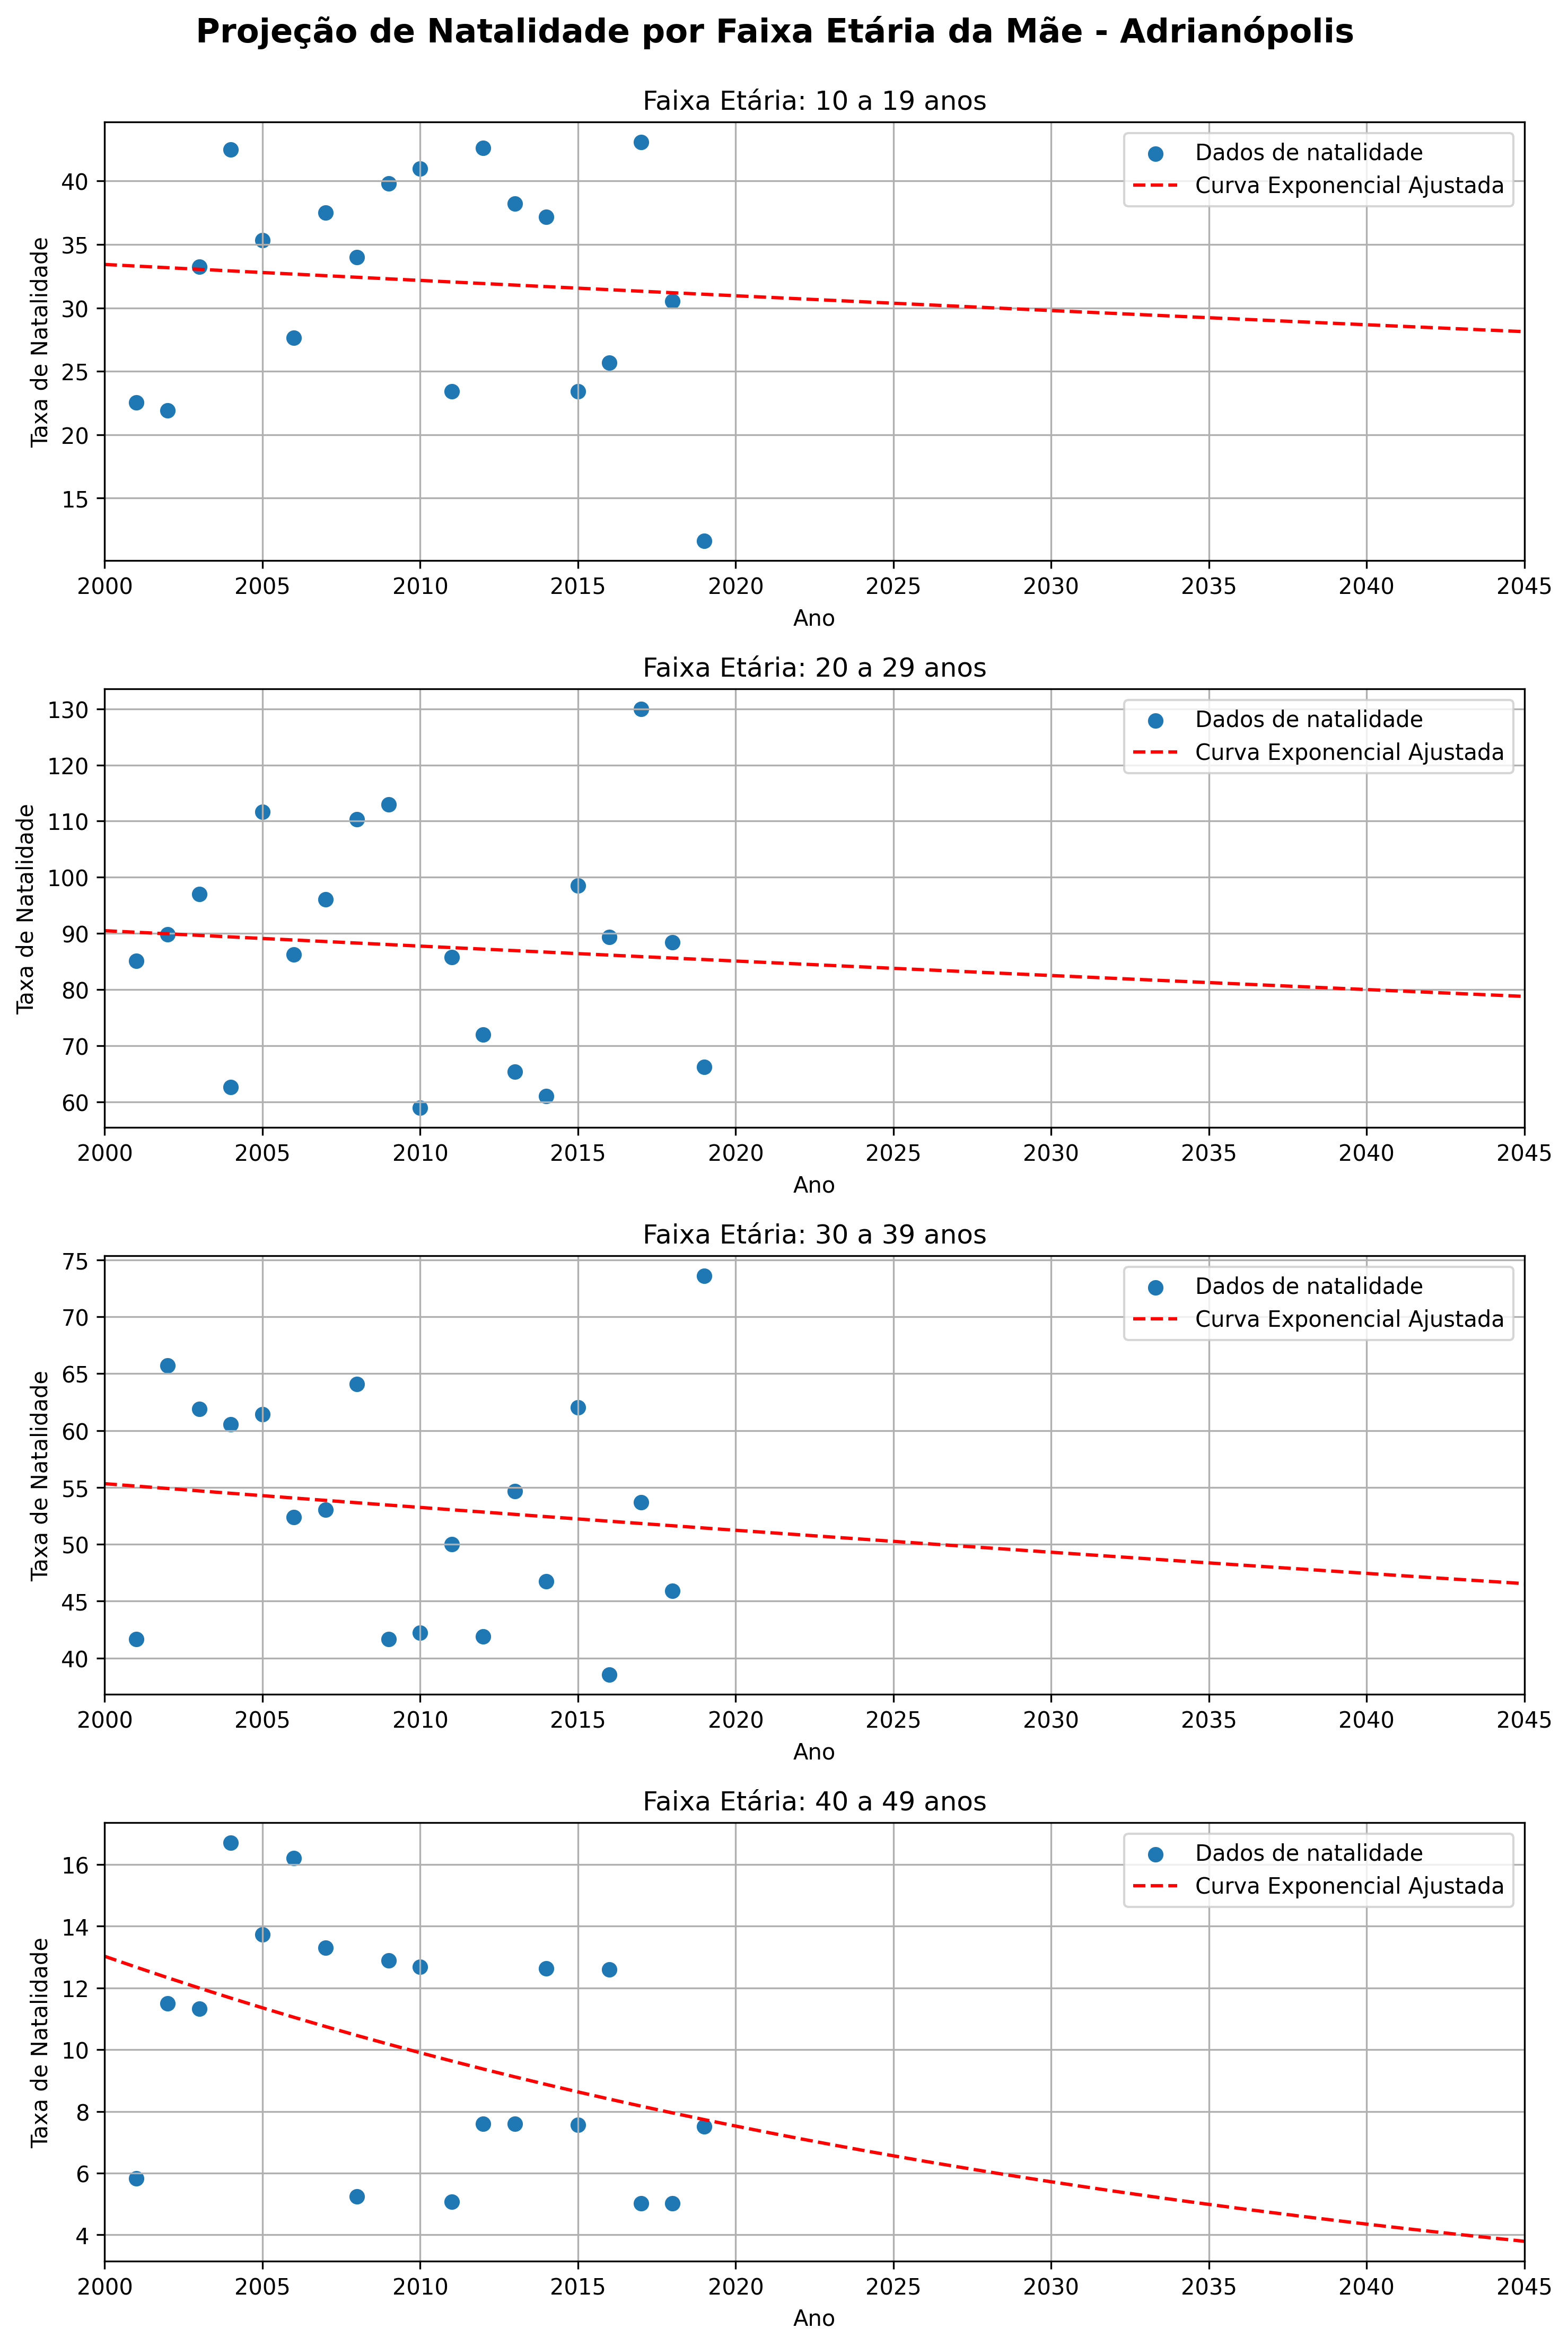

![Campina Grande do Sul.png](<attachment:Campina Grande do Sul.png>)
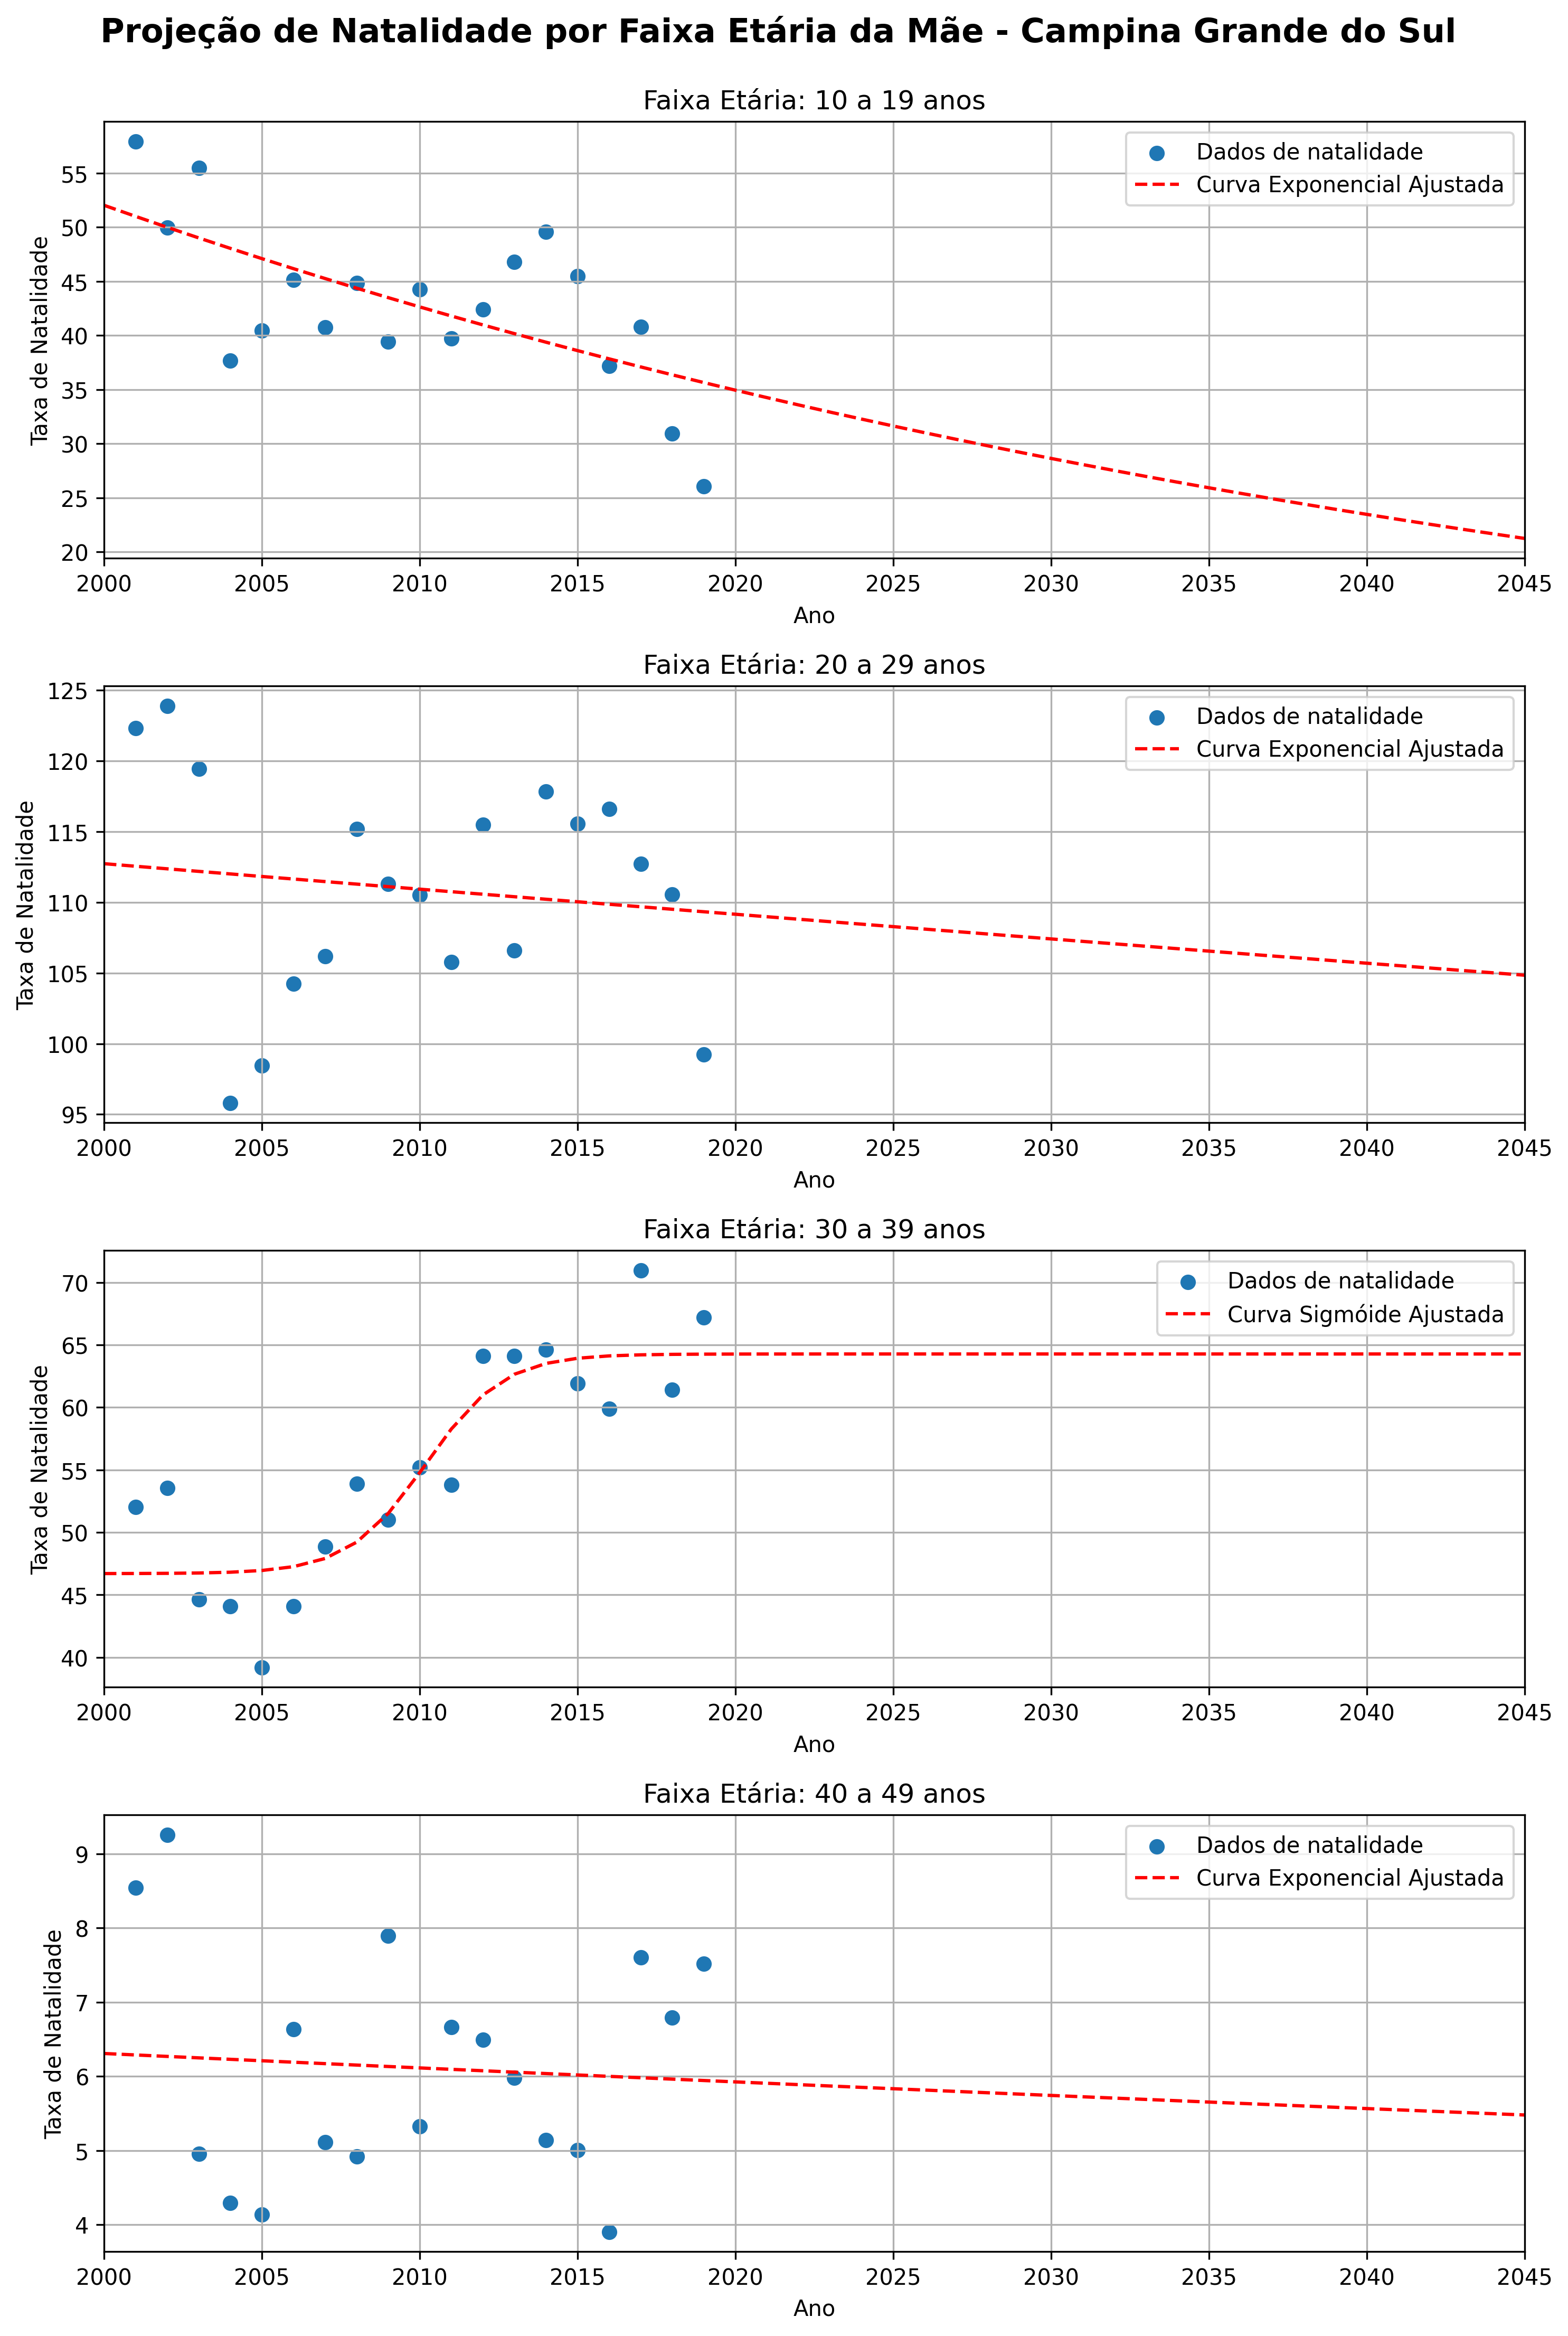

![Tunas do Paraná.png](<attachment:Tunas do Paraná.png>)
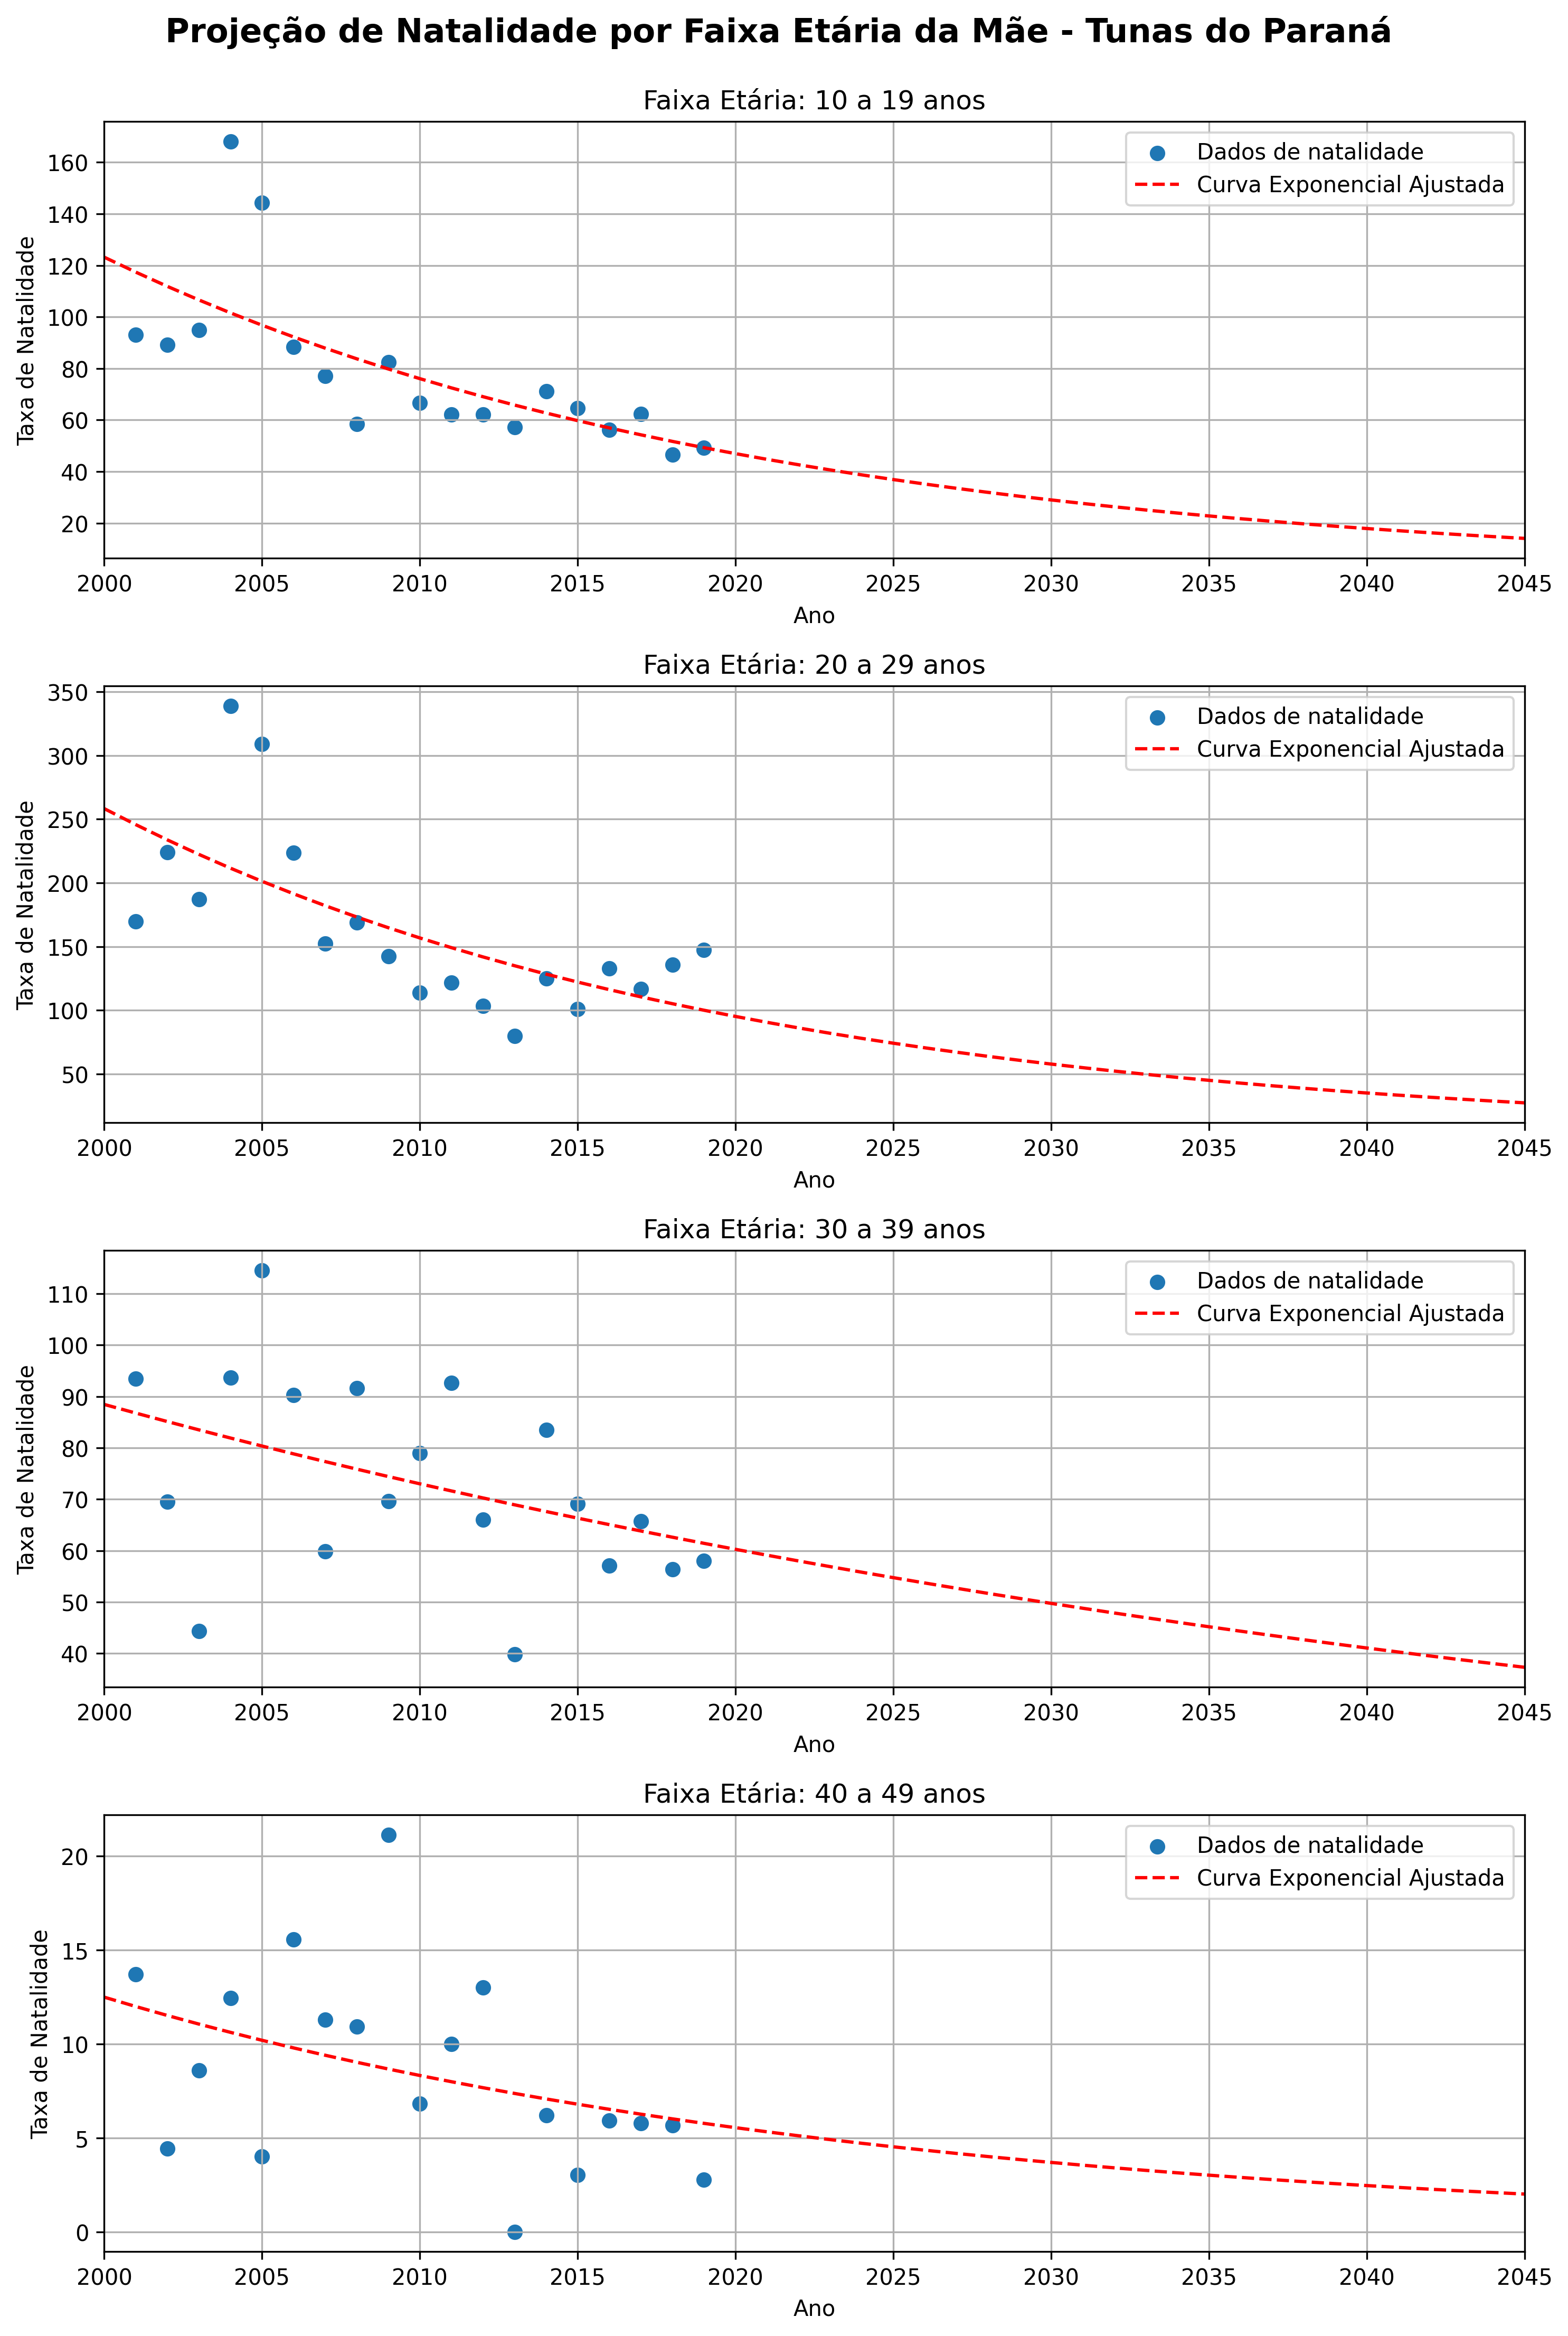

![São José dos Pinhais.png](<attachment:São José dos Pinhais.png>)
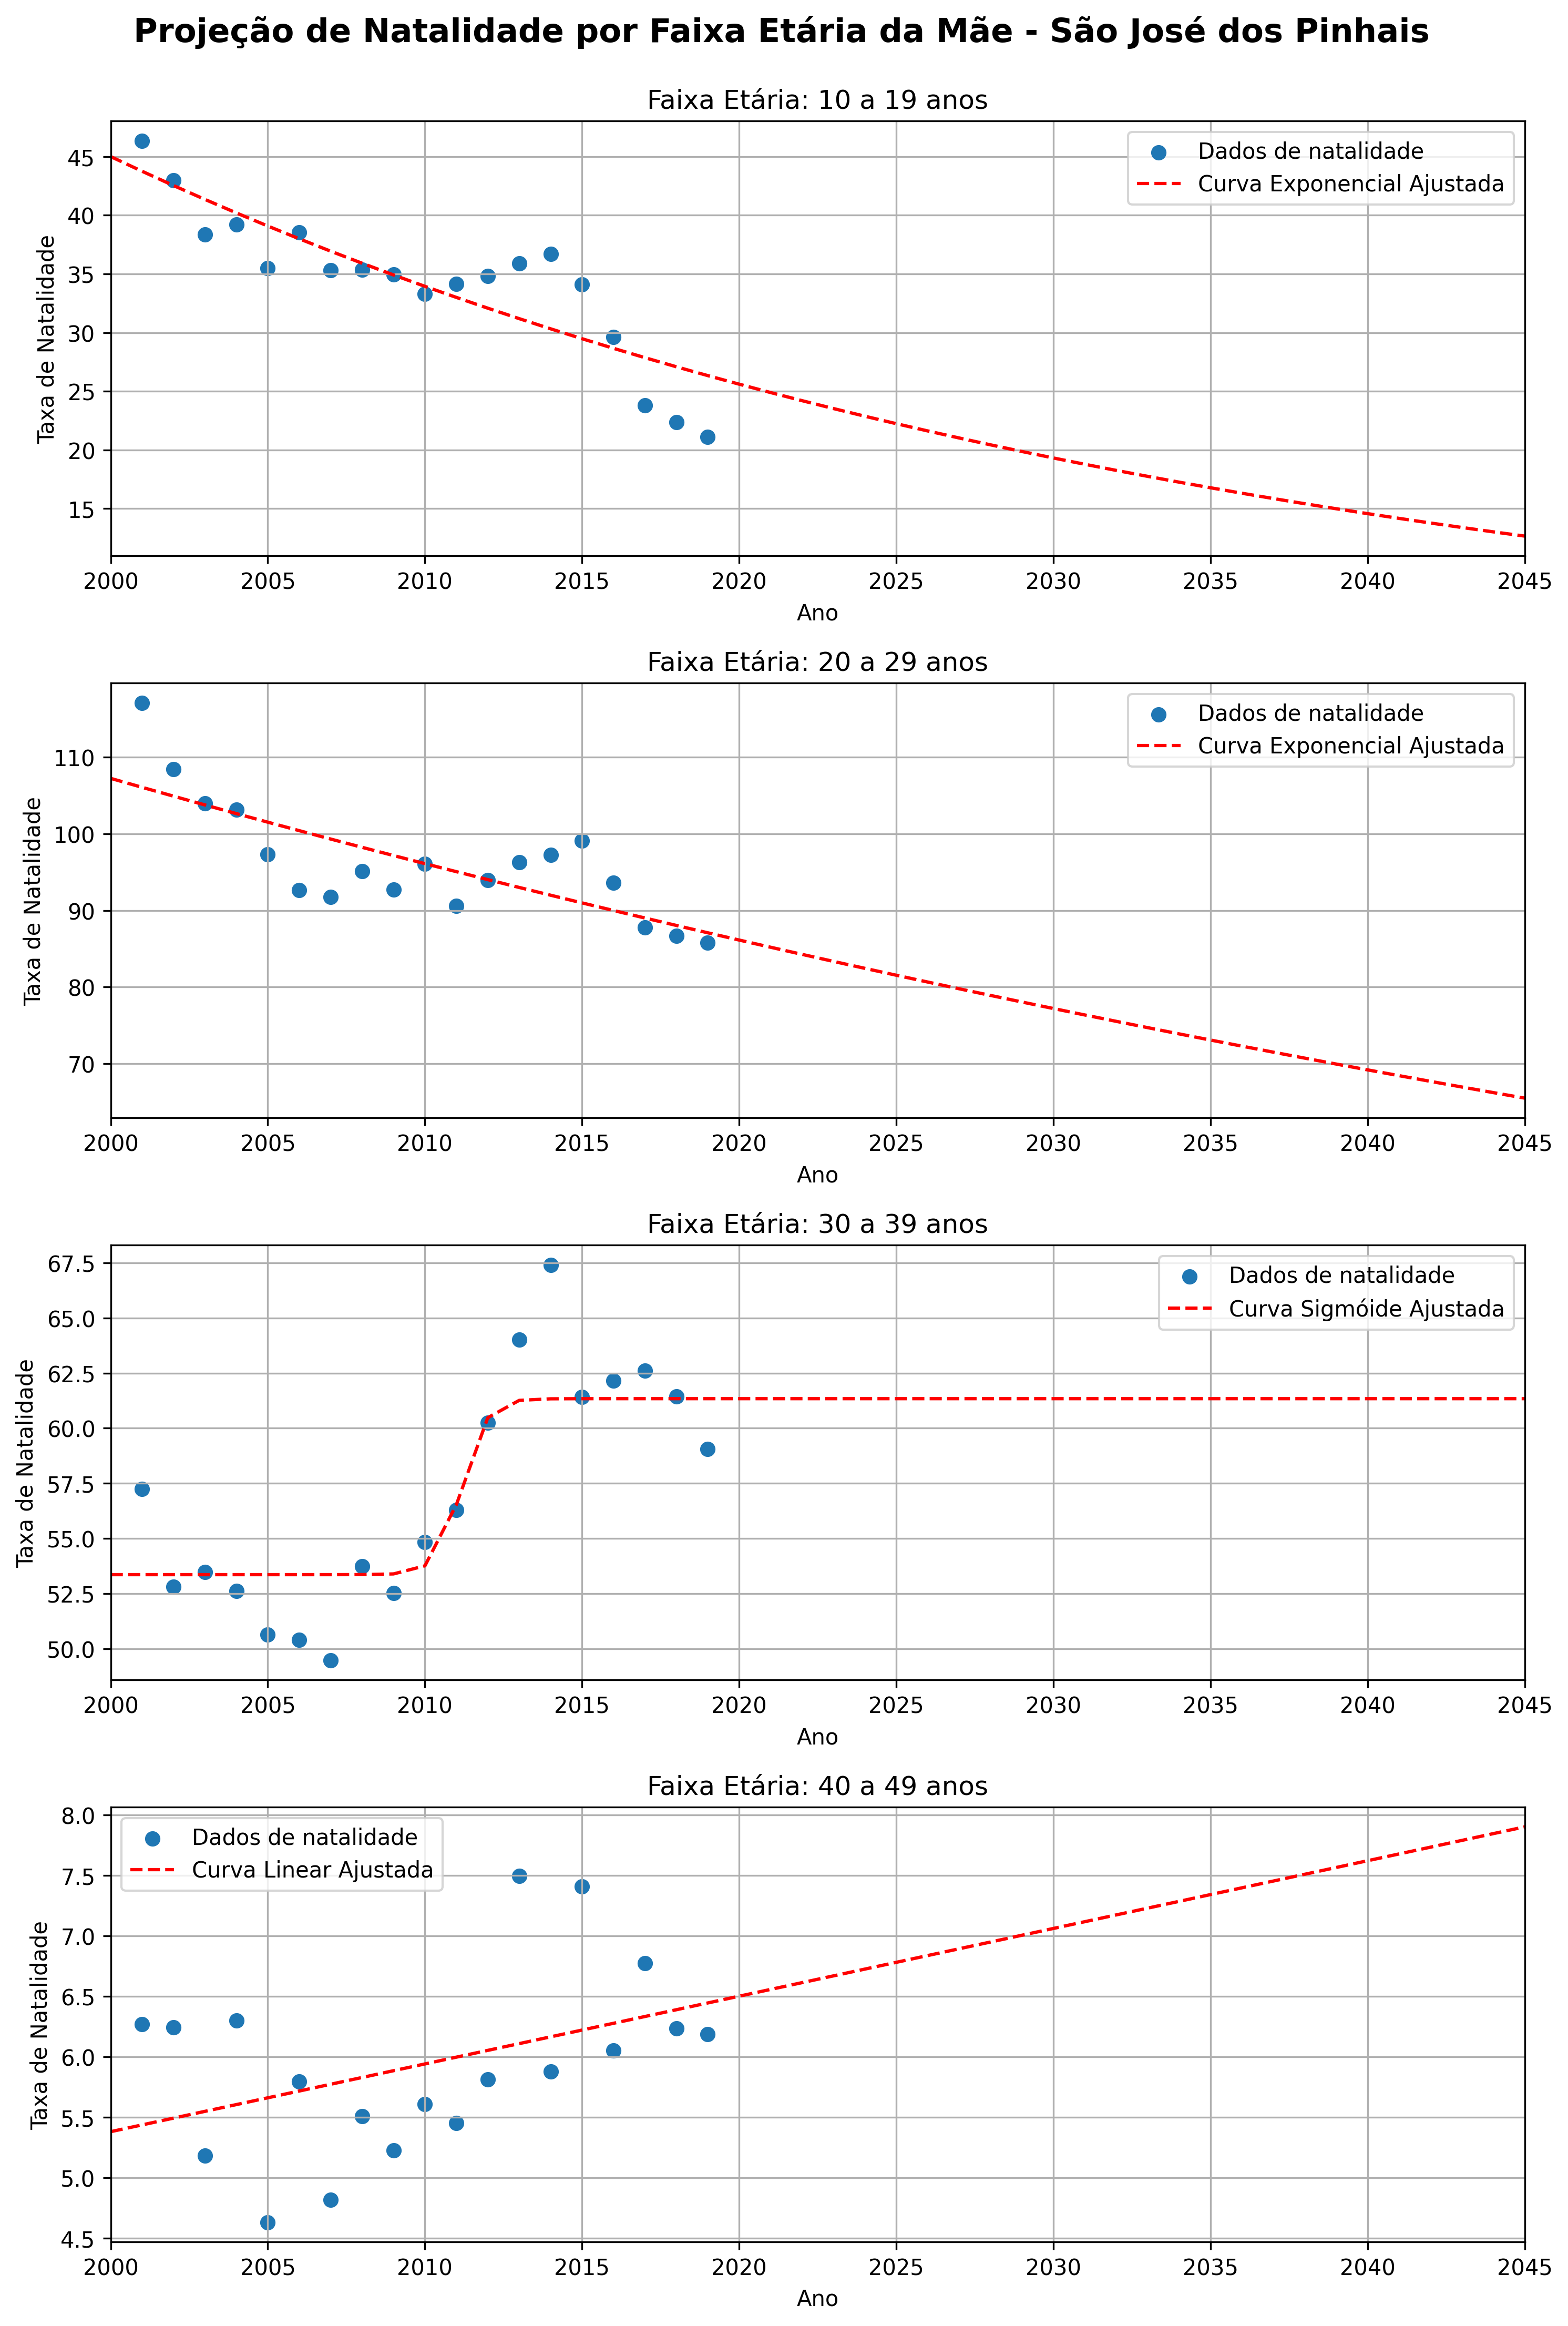

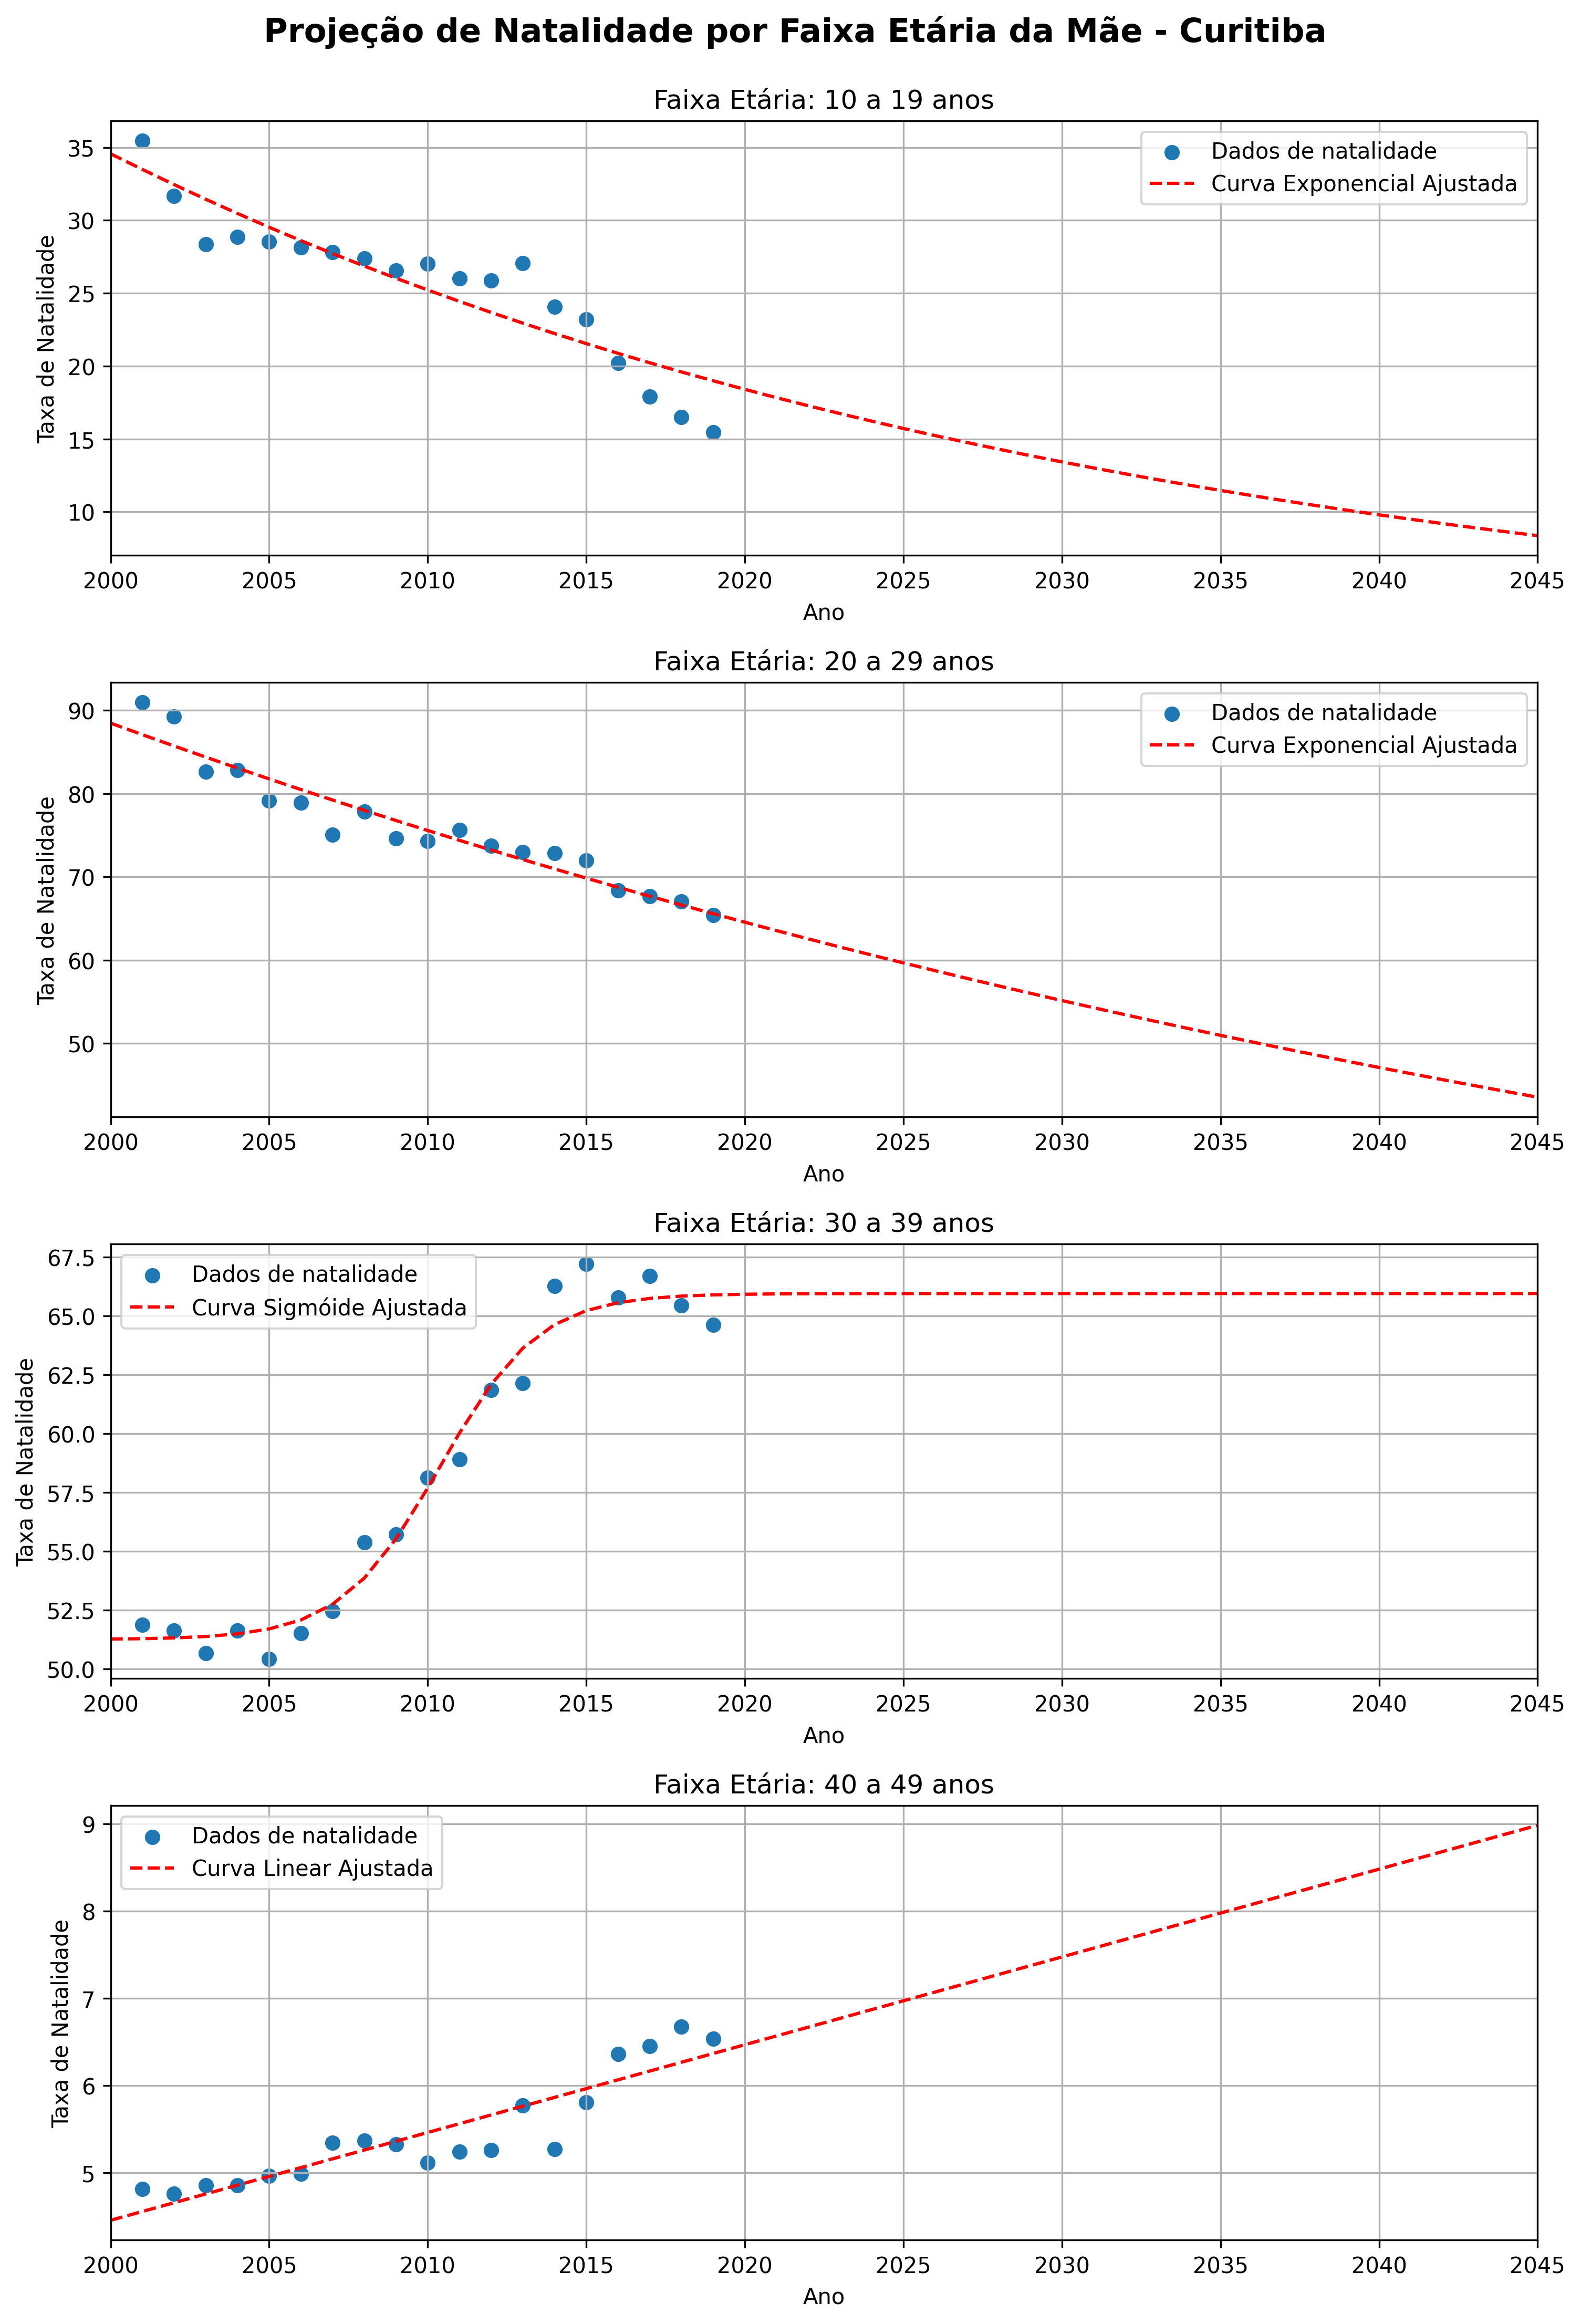

![0 overfitting.jpg](<attachment:0 overfitting.jpg>)
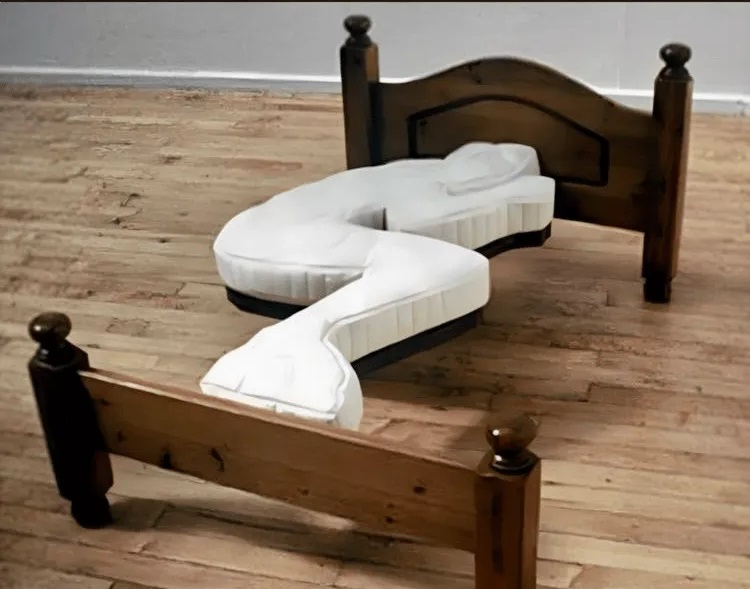

## Verificação de Resultados

In [ ]:
dict_dfs = dict()

for mun_id, mun in df_mun.itertuples():
    print(mun)
    df_births_mun = mb.query_births(mun_id=mun_id, project_id=project_id, start_year=2020, end_year=2023)
    df_births_mun = mb.standard_age_groups(df=df_births_mun, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_maes.csv')
    df_births_mun = df_births_mun.reset_index().pivot_table(columns=['Ano'], index=['Faixa Etária'], values=['Nascimentos'])
    df_births_mun = df_births_mun.droplevel(level=0, axis=1)
    df_births_mun.columns.name = None
    df_births_mun['Município'] = mun
    df_births_mun = df_births_mun.reset_index().set_index(['Município', 'Faixa Etária'])
    
    dict_dfs[mun] = df_births_mun

df_births_2020_2023 = pd.concat(objs=dict_dfs.values())

Adrianópolis


Downloading: 100%|██████████| 261/261 [00:00<00:00, 814.58rows/s]


Agudos do Sul


Downloading: 100%|██████████| 498/498 [00:00<00:00, 1610.64rows/s]


Almirante Tamandaré


Downloading: 100%|██████████| 5295/5295 [00:00<00:00, 14429.61rows/s]


Araucária


Downloading: 100%|██████████| 6943/6943 [00:00<00:00, 17328.48rows/s]


Balsa Nova


Downloading: 100%|██████████| 543/543 [00:00<00:00, 1461.78rows/s]


Bocaiúva do Sul


Downloading: 100%|██████████| 624/624 [00:00<00:00, 2131.36rows/s]


Campina Grande do Sul


Downloading: 100%|██████████| 2289/2289 [00:00<00:00, 7027.97rows/s]


Campo do Tenente


Downloading: 100%|██████████| 378/378 [00:00<00:00, 1388.51rows/s]


Campo Largo


Downloading: 100%|██████████| 5291/5291 [00:00<00:00, 14808.57rows/s]


Campo Magro


Downloading: 100%|██████████| 1219/1219 [00:00<00:00, 2014.79rows/s]


Cerro Azul


Downloading: 100%|██████████| 721/721 [00:00<00:00, 2576.31rows/s]


Colombo


Downloading: 100%|██████████| 10501/10501 [00:01<00:00, 8164.14rows/s]


Contenda


Downloading: 100%|██████████| 774/774 [00:00<00:00, 2797.44rows/s]


Curitiba


Downloading: 100%|██████████| 63920/63920 [00:01<00:00, 46489.47rows/s]


Fazenda Rio Grande


Downloading: 100%|██████████| 6718/6718 [00:00<00:00, 16996.69rows/s]


Itaperuçu


Downloading: 100%|██████████| 1704/1704 [00:00<00:00, 5717.21rows/s]


Lapa


Downloading: 100%|██████████| 1829/1829 [00:00<00:00, 5680.16rows/s]


Mandirituba


Downloading: 100%|██████████| 1165/1165 [00:00<00:00, 4242.54rows/s]


Piên


Downloading: 100%|██████████| 626/626 [00:00<00:00, 2168.86rows/s]


Pinhais


Downloading: 100%|██████████| 5168/5168 [00:00<00:00, 14534.19rows/s]


Piraquara


Downloading: 100%|██████████| 5022/5022 [00:00<00:00, 16356.00rows/s]


Quatro Barras


Downloading: 100%|██████████| 980/980 [00:00<00:00, 2981.86rows/s]


Quitandinha


Downloading: 100%|██████████| 720/720 [00:00<00:00, 2388.66rows/s]


Rio Branco do Sul


Downloading: 100%|██████████| 1816/1816 [00:00<00:00, 6202.20rows/s]


Rio Negro


Downloading: 100%|██████████| 1159/1159 [00:00<00:00, 3933.47rows/s]


São José dos Pinhais


Downloading: 100%|██████████| 14750/14750 [00:00<00:00, 35951.04rows/s]


Tijucas do Sul


Downloading: 100%|██████████| 714/714 [00:00<00:00, 2708.89rows/s]


Tunas do Paraná


Downloading: 100%|██████████| 357/357 [00:00<00:00, 1025.54rows/s]


Doutor Ulysses


Downloading: 100%|██████████| 234/234 [00:00<00:00, 940.25rows/s]


In [ ]:
df_births_2020_2023.sum()

2020    43765
2021    41537
2022    41024
2023    15880
dtype: int64

In [ ]:
y = df_births_2020_2023.reset_index().groupby(by=['Município']).sum()
#y = df_births.loc[:,[2020, 2021, 2022]].reset_index().groupby(by=['Município']).sum()

In [ ]:
y = y[[2020, 2021, 2022]]

In [ ]:
y_pred = (
    resultados.set_index(['Município', 'Faixa Etária'])
    .loc[:,[2020, 2021, 2022]]
    .div(1000)
    .mul(df_pop[[2020, 2021, 2022]])
    .reset_index()
    .groupby(by=['Município'])
    .sum()
)

In [ ]:
((y_pred - y) / y * 100)[2022].sort_values(ascending=False)

Município
Balsa Nova               29.423904
Fazenda Rio Grande       28.750935
Campo Magro              25.006843
Araucária                23.506793
Pinhais                  21.481588
Contenda                 18.882100
Colombo                  16.151550
Campina Grande do Sul    15.867489
Almirante Tamandaré      13.517803
São José dos Pinhais     13.103899
Curitiba                 12.853758
Tijucas do Sul           12.624653
Quatro Barras            12.296372
Campo Largo              10.760025
Piraquara                 9.404386
Itaperuçu                 1.828114
Bocaiúva do Sul           1.072660
Adrianópolis              0.890598
Rio Branco do Sul         0.294245
Lapa                     -1.266224
Campo do Tenente         -1.720168
Quitandinha              -3.888057
Mandirituba              -4.956749
Tunas do Paraná          -5.464528
Rio Negro                -6.388712
Cerro Azul              -13.202769
Piên                    -14.250824
Agudos do Sul           -20.759602
Doutor Uly

In [ ]:
y.sum()

2020    43765
2021    41537
2022    41024
2023    15880
dtype: int64

In [ ]:
y_pred

2020          2021          2022          2023
Município                                                                    
Adrianópolis              72.105087     71.361475     70.623419     70.310873
Agudos do Sul            119.276575    120.151084    121.237808    120.524555
Almirante Tamandaré     1789.262983   1784.939594   1781.094322   1767.142851
Araucária               2372.880875   2390.802429   2409.617541   2397.938555
Balsa Nova               207.107789    208.962982    210.960964    213.059045
Bocaiúva do Sul          172.165098    171.421161    170.812796    168.548501
Campina Grande do Sul    797.868138    801.451656    805.279046    802.260666
Campo Largo             1724.992126   1724.007029   1723.425986   1712.756523
Campo Magro              421.101122    423.012350    425.023267    423.333795
Campo do Tenente         115.525937    114.732529    114.004605    113.546881
Cerro Azul               191.456688    185.464948    179.670269    176.258396
Colombo                 3504.638590   3468.412222   3433.439815   3402.324000
Contenda                 258.089654    262.673846    267.484725    269.714734
Curitiba               21551.443590  21148.663133  20759.448870  20586.856652
Doutor Ulysses            57.848445     56.303791     54.882738     53.795749
Fazenda Rio Grande      2260.464258   2363.914527   2473.305463   2464.462528
Itaperuçu                505.192053    507.088955    509.140570    504.059759
Lapa                     547.891517    536.883389    526.251025    520.892783
Mandirituba              348.540836    345.753573    343.106138    337.185579
Pinhais                 1843.289497   1822.718864   1802.786773   1789.536181
Piraquara               1603.995812   1612.370418   1621.372998   1608.994597
Piên                     166.683344    167.756602    168.925877    168.489796
Quatro Barras            331.229660    331.742164    332.397262    331.084901
Quitandinha              206.210679    204.911624    203.757320    203.164669
Rio Branco do Sul        524.759440    515.964715    507.488880    497.212229
Rio Negro                325.141953    316.362539    307.981139    303.336389
São José dos Pinhais    4786.380409   4801.435985   4818.226103   4779.476906
Tijucas do Sul           230.406517    231.205315    232.006785    231.067841
Tunas do Paraná          105.458943    100.755550     96.426182     92.573652

In [ ]:
((y_pred - y).sum(axis=1) / 4 * 10).sum()

110766.80083844533

In [ ]:
((y_pred - y).sum(axis=1) / 3 * 10).sum()

46922.70250454858

In [ ]:
y.sum()

2020    43765
2021    41537
2022    41024
dtype: int64

In [ ]:
y_pred.sum()

2020    47141.407615
2021    46791.224451
2022    46470.178685
dtype: float64

In [ ]:
y.sum()

2020    47141.407615
2021    46791.224451
2022    46470.178685
dtype: float64

Município
Adrianópolis                75.333333
Agudos do Sul              145.000000
Almirante Tamandaré       1581.666667
Araucária                 2056.666667
Balsa Nova                 160.000000
Bocaiúva do Sul            184.666667
Campina Grande do Sul      675.000000
Campo Largo               1553.666667
Campo Magro                367.666667
Campo do Tenente           113.000000
Cerro Azul                 217.000000
Colombo                   3103.333333
Contenda                   222.666667
Curitiba                 18897.333333
Doutor Ulysses              72.000000
Fazenda Rio Grande        1986.666667
Itaperuçu                  502.666667
Lapa                       540.333333
Mandirituba                349.666667
Pinhais                   1538.666667
Piraquara                 1496.333333
Piên                       184.000000
Quatro Barras              293.666667
Quitandinha                216.666667
Rio Branco do Sul          542.333333
Rio Negro                  336.666667
Sã

In [ ]:
((y_pred - y) / y * 100).mean(axis=1).sort_values(ascending=False)

Município
Balsa Nova               30.677109
Fazenda Rio Grande       19.243756
Campina Grande do Sul    18.845921
Pinhais                  18.590007
Contenda                 18.286030
Araucária                16.551836
Campo Magro              15.431148
Quatro Barras            12.984590
Almirante Tamandaré      12.864758
Curitiba                 11.996132
Colombo                  11.958117
Campo Largo              11.013051
Tijucas do Sul           10.826415
São José dos Pinhais      9.703947
Piraquara                 7.961285
Campo do Tenente          1.599003
Itaperuçu                 1.063880
Lapa                     -0.607875
Mandirituba              -1.024184
Tunas do Paraná          -4.172298
Rio Branco do Sul        -4.625762
Adrianópolis             -5.027121
Quitandinha              -5.334566
Rio Negro                -5.973662
Bocaiúva do Sul          -6.796326
Piên                     -8.576038
Cerro Azul              -14.355676
Agudos do Sul           -16.854689
Doutor Uly

In [ ]:
(y_pred - y).sum(axis=1).sort_values(ascending=False).round() / y.mean(axis=1) * 100

Município
Adrianópolis            -15.929204
Agudos do Sul           -51.034483
Almirante Tamandaré      38.566913
Araucária                48.768233
Balsa Nova               91.875000
Bocaiúva do Sul         -21.660650
Campina Grande do Sul    56.296296
Campo Largo              32.889938
Campo Magro              45.149592
Campo do Tenente          4.424779
Cerro Azul              -43.317972
Colombo                  35.316864
Contenda                 53.892216
Curitiba                 35.814577
Doutor Ulysses          -65.277778
Fazenda Rio Grande       57.281879
Itaperuçu                 2.586207
Lapa                     -1.850709
Mandirituba              -3.431840
Pinhais                  55.437608
Piraquara                23.323680
Piên                    -26.630435
Quatro Barras            38.819523
Quitandinha             -16.153846
Rio Branco do Sul       -14.566687
Rio Negro               -18.118812
São José dos Pinhais     28.779003
Tijucas do Sul           32.587859
Tunas do P

In [ ]:
(y_pred - y).sum()

2020   -3376.407615
2021   -5254.224451
2022   -5446.178685
dtype: float64

In [ ]:
df_birth_rate_by_mothers_age_group_20_to_22 = (df_births / df_pop).dropna(axis=0) * 1000
df_birth_rate_by_mothers_age_group_20_to_22 = df_birth_rate_by_mothers_age_group_20_to_22[[2022, 2021, 2022]]

In [ ]:
df_birth_rate_by_mothers_age_group_20_to_22.reset_index().groupby(by=['Município']).sum().sum()

2022    4912.894486
2021    4986.619378
2022    4912.894486
dtype: float64

In [ ]:
resultados[resultados['Município'] == 'Curitiba'].sum()

Município                         CuritibaCuritibaCuritibaCuritiba
Faixa Etária      10 a 19 anos20 a 29 anos30 a 39 anos40 a 49 anos
Tipo de Modelo                ExponencialExponencialSigmóideLinear
Param1                                                  128.141404
Param2                                                    10.53825
2020                                                    155.355283
2021                                                    153.890463
2022                                                    152.452251
2023                                                    151.043097
2024                                                    149.663942
2025                                                    148.314935
2026                                                    146.995816
2027                                                    145.706122
2028                                                    144.445287
2029                                                    143.21

In [ ]:
resultados.reset_index().groupby(by=['Município']).sum()[[2020, 2021, 2022]]

2020        2021        2022
Município                                                
Adrianópolis           174.777011  173.996885  173.224282
Agudos do Sul          169.350066  168.357439  167.393044
Almirante Tamandaré    185.703377  184.186322  182.690997
Araucária              197.001918  195.926047  194.868703
Balsa Nova             222.686165  225.063196  227.414282
Bocaiúva do Sul        177.722421  175.383362  173.077538
Campina Grande do Sul  214.290975  213.411668  212.544424
Campo Largo            169.485970  168.356982  167.241218
Campo Magro            185.448390  184.686090  183.905626
Campo do Tenente       206.387701  205.567966  204.762381
Cerro Azul             165.198899  162.030878  158.942609
Colombo                186.271632  184.491513  182.739372
Contenda               186.252501  187.831275  189.410283
Curitiba               155.355283  153.890463  152.452251
Doutor Ulysses         142.624786  139.764075  136.987563
Fazenda Rio Grande     192.253322  191.392531  190.553193
Itaperuçu              201.739655  199.719016  197.725001
Lapa                   167.552921  165.757891  163.995711
Mandirituba            183.089270  179.918364  176.822747
Pinhais                181.965518  180.510044  179.080305
Piraquara              176.901507  175.480636  174.091129
Piên                   165.061607  164.540066  164.050828
Quatro Barras          182.656652  181.835669  181.038104
Quitandinha            165.607853  165.111181  164.620593
Rio Branco do Sul      188.205533  184.380876  180.641761
Rio Negro              143.152915  140.920175  138.743064
São José dos Pinhais   179.567653  177.972137  176.406676
Tijucas do Sul         193.707763  192.930847  192.181139
Tunas do Paraná        207.855494  199.644503  191.793913

In [ ]:
df_births.reset_index().groupby(by=['Município']).sum()[[2020, 2021, 2022]]

2020   2021   2022
Município                                 
Adrianópolis              80     76     70
Agudos do Sul            134    148    153
Almirante Tamandaré     1592   1584   1569
Araucária               2186   2033   1951
Balsa Nova               155    162    163
Bocaiúva do Sul          196    189    169
Campina Grande do Sul    682    648    695
Campo Largo             1589   1516   1556
Campo Magro              377    386    340
Campo do Tenente         111    112    116
Cerro Azul               234    210    207
Colombo                 3290   3064   2956
Contenda                 234    209    225
Curitiba               19727  18570  18395
Doutor Ulysses            74     72     70
Fazenda Rio Grande      2017   2022   1921
Itaperuçu                529    479    500
Lapa                     539    549    533
Mandirituba              339    349    361
Pinhais                 1615   1517   1484
Piraquara               1578   1429   1482
Piên                     173    182    197
Quatro Barras            292    293    296
Quitandinha              213    225    212
Rio Branco do Sul        579    542    506
Rio Negro                336    345    329
São José dos Pinhais    4570   4315   4260
Tijucas do Sul           207    213    206
Tunas do Paraná          117     98    102

2020   2021   2022
Município                                 
Adrianópolis              80     76     70
Agudos do Sul            134    148    153
Almirante Tamandaré     1592   1584   1569
Araucária               2186   2033   1951
Balsa Nova               155    162    163
Bocaiúva do Sul          196    189    169
Campina Grande do Sul    682    648    695
Campo Largo             1589   1516   1556
Campo Magro              377    386    340
Campo do Tenente         111    112    116
Cerro Azul               234    210    207
Colombo                 3290   3064   2956
Contenda                 234    209    225
Curitiba               19727  18570  18395
Doutor Ulysses            74     72     70
Fazenda Rio Grande      2017   2022   1921
Itaperuçu                529    479    500
Lapa                     539    549    533
Mandirituba              339    349    361
Pinhais                 1615   1517   1484
Piraquara               1578   1429   1482
Piên                     173    182    197
Quatro Barras            292    293    296
Quitandinha              213    225    212
Rio Branco do Sul        579    542    506
Rio Negro                336    345    329
São José dos Pinhais    4570   4315   4260
Tijucas do Sul           207    213    206
Tunas do Paraná          117     98    102

In [ ]:
# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# Function for the sigmoidal model
#def modelo_sigmoidal(x, L, k, x0):
#    return (L / (1 + np.exp(-k * (x - x0))))


def logistic_growth_with_bias(x, L, k, x0, b):
    return L / (1 + ((L - dados_natalidade[0]) / dados_natalidade[0]) * np.exp(-k * (x - x0))) + b


# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if faixa_etaria == '30 a 39 anos' and coef_angular > 0:
            # Now, you would use this function in your curve fitting procedure:
            try:
                # You may need to adjust these initial parameter guesses based on your data
                initial_guesses = [70, 0.1, np.median(anos), 0]  # Added 0 for the initial guess of the bias
                params, param_cov = curve_fit(logistic_growth_with_bias, anos, dados_natalidade, p0=initial_guesses, bounds=(0, [75., 1., max(anos), np.inf]))
                L, k, x0, b = params
                previsao = logistic_growth_with_bias(anos_todo_intervalo, L, k, x0, b)
                tipo_modelo = 'Logistic Growth with Bias'
            except RuntimeError:
                L, k, x0, b = np.nan, np.nan, np.nan, np.nan
                previsao = np.nan * anos
        elif coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model

### A IMPLEMENTAR
###                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

###                # Plotting the confidence intervals
###                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
##                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
##                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

### A IMPLEMENTAR
                # Calculate confidence intervals for exponential model
###                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)
###                lower_bounds, upper_bounds = bootstrap_confidence_interval(model_func=modelo_exponencial, x=anos, y=dados_natalidade)

                # Plotting the confidence intervals
###               previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0]) 
###                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
###                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
#        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
#                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
#                                'Coeficiente': [coeficiente]})
#        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
#        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)


Adrianópolis
Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


In [ ]:
new_columns = [*resultados.columns.tolist()]
new_columns.extend(range(2022, 2046))
resultados = resultados.reindex(columns=new_columns, fill_value=0)
for year in resultados.columns[5:].astype(int):
    resultados.loc[:,year] = year-2000
resultados_exp = resultados[resultados['Tipo de Modelo'] == 'Exponencial']
resultados_lin = resultados[resultados['Tipo de Modelo'] == 'Linear']
resultados_lin = resultados[resultados['Tipo de Modelo'] == 'Exponencial']
res = pd.concat(
    objs=[
        modelo_exponencial(resultados_exp.iloc[:, 5:], resultados_exp.Constante.values.reshape((-1,1)), resultados_exp.Coeficiente.values.reshape((-1,1)))
        , modelo_linear(resultados_lin.iloc[:, 5:], resultados_lin.Constante.values.reshape((-1,1)), resultados_lin.Coeficiente.values.reshape((-1,1)))
        ]
    , axis=0
    
)

resultados = pd.concat(
    objs=[
        resultados_exp.iloc[:,:5]
        , resultados_lin.iloc[:,:5]
        ]
    , axis=0
    
)
resultados = resultados.join(res)

In [ ]:
resultados

Município  Faixa Etária Tipo de Modelo  Constante  \
0            Adrianópolis  10 a 19 anos    Exponencial  33.418025   
1            Adrianópolis  20 a 29 anos    Exponencial  90.472362   
2            Adrianópolis  30 a 39 anos    Exponencial  55.324305   
3            Adrianópolis  40 a 49 anos    Exponencial  13.026899   
4           Agudos do Sul  10 a 19 anos    Exponencial  37.373194   
..                    ...           ...            ...        ...   
98              Rio Negro  30 a 39 anos         Linear  49.969626   
102  São José dos Pinhais  30 a 39 anos         Linear  50.142515   
103  São José dos Pinhais  40 a 49 anos         Linear   5.382657   
104        Tijucas do Sul  10 a 19 anos         Linear  39.074063   
106        Tijucas do Sul  30 a 39 anos         Linear  46.455986   

     Coeficiente       2022       2023       2024       2025       2026  ...  \
0       0.003834  30.715006  30.597475  30.480394  30.363762  30.247575  ...   
1       0.003079  84.546561  84.286627  84.027492  83.769154  83.511610  ...   
2       0.003842  50.839929  50.644962  50.450743  50.257269  50.064537  ...   
3       0.027442   7.122787   6.929983   6.742398   6.559891   6.382324  ...   
4       0.004633  33.751784  33.595782  33.440502  33.285939  33.132090  ...   
..           ...        ...        ...        ...        ...        ...  ...   
98      0.034615  50.731150  50.765765  50.800380  50.834994  50.869609  ...   
102     0.682549  65.158590  65.841139  66.523688  67.206237  67.888786  ...   
103     0.056000   6.614660   6.670660   6.726661   6.782661   6.838661  ...   
104     0.121022  41.736554  41.857576  41.978598  42.099621  42.220643  ...   
106     0.589430  59.423442  60.012871  60.602301  61.191731  61.781161  ...   

          2036       2037       2038       2039       2040       2041  \
0    29.109885  28.998496  28.887534  28.776996  28.666882  28.557188   
1    80.979322  80.730356  80.482154  80.234716  79.988039  79.742120   
2    48.177401  47.992645  47.808598  47.625256  47.442617  47.260679   
3     4.850663   4.719362   4.591616   4.467327   4.346403   4.228752   
4    31.632176  31.485971  31.340442  31.195585  31.051398  30.907878   
..         ...        ...        ...        ...        ...        ...   
98   51.215757  51.250371  51.284986  51.319601  51.354215  51.388830   
102  74.714275  75.396824  76.079372  76.761921  77.444470  78.127019   
103   7.398662   7.454663   7.510663   7.566663   7.622663   7.678663   
104  43.430866  43.551888  43.672911  43.793933  43.914955  44.035978   
106  67.675459  68.264888  68.854318  69.443748  70.033178  70.622607   

          2042       2043       2044       2045  
0    28.447915  28.339059  28.230620  28.122596  
1    79.496957  79.252548  79.008890  78.765982  
2    47.079438  46.898893  46.719040  46.539876  
3     4.114286   4.002918   3.894564   3.789144  
4    30.765021  30.622824  30.481284  30.340399  
..         ...        ...        ...        ...  
98   51.423445  51.458060  51.492674  51.527289  
102  78.809568  79.492117  80.174666  80.857215  
103   7.734663   7.790664   7.846664   7.902664  
104  44.157000  44.278022  44.399045  44.520067  
106  71.212037  71.801467  72.390897  72.980327  

[116 rows x 29 columns]

In [ ]:
resultados.to_csv(path_or_buf='../../br_demography/results/tab/taxa_natalidade_projetada_rmc_2022_2045.csv', sep=';', decimal=',', encoding='utf-16', index=False)

In [ ]:
"""
from sklearn.utils import resample

def calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):
    num_params = len(params)
    alpha = 0.05
    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)
    param_se = np.sqrt(np.diag(param_covariance))
    ci = critical_value * param_se
    return params - ci, params + ci


def bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):
    bootstrapped_params = []

    for _ in range(num_iterations):
        x_resampled, y_resampled = resample(x, y)
        params, _ = curve_fit(model_func, x_resampled, y_resampled)
        bootstrapped_params.append(params)

    bootstrapped_params = np.array(bootstrapped_params)
    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)

    return lower_bounds, upper_bounds

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

                # Calculate confidence intervals for exponential model
#                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)
                lower_bounds, upper_bounds = bootstrap_confidence_interval(model_func=modelo_exponencial, x=anos, y=dados_natalidade)

                # Plotting the confidence intervals
                previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0]) 
                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

"""

'\nfrom sklearn.utils import resample\n\ndef calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):\n    num_params = len(params)\n    alpha = 0.05\n    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)\n    param_se = np.sqrt(np.diag(param_covariance))\n    ci = critical_value * param_se\n    return params - ci, params + ci\n\n\ndef bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):\n    bootstrapped_params = []\n\n    for _ in range(num_iterations):\n        x_resampled, y_resampled = resample(x, y)\n        params, _ = curve_fit(model_func, x_resampled, y_resampled)\n        bootstrapped_params.append(params)\n\n    bootstrapped_params = np.array(bootstrapped_params)\n    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)\n    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)\n\n    return lower_bounds, upper

In [ ]:
"""

from sklearn.utils import resample

def bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):
    bootstrapped_params = []

    for _ in range(num_iterations):
        x_resampled, y_resampled = resample(x, y)
        params, _ = curve_fit(model_func, x_resampled, y_resampled)
        bootstrapped_params.append(params)

    bootstrapped_params = np.array(bootstrapped_params)
    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)

    return lower_bounds, upper_bounds

# Use this function in place of calculate_confidence_intervals in your code.



def calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):
    num_params = len(params)
    alpha = 0.05
    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)
    param_se = np.sqrt(np.diag(param_covariance))
    ci = critical_value * param_se
    return params - ci, params + ci

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

                # Calculate confidence intervals for exponential model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0])
                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    """"

SyntaxError: unterminated string literal (detected at line 149) (4009632457.py, line 149)

In [ ]:
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente *(-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, _ = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, _ = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'
            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
#    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_novo_modelo.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
"""

Adrianópolis
Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


Adrianópolis


Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


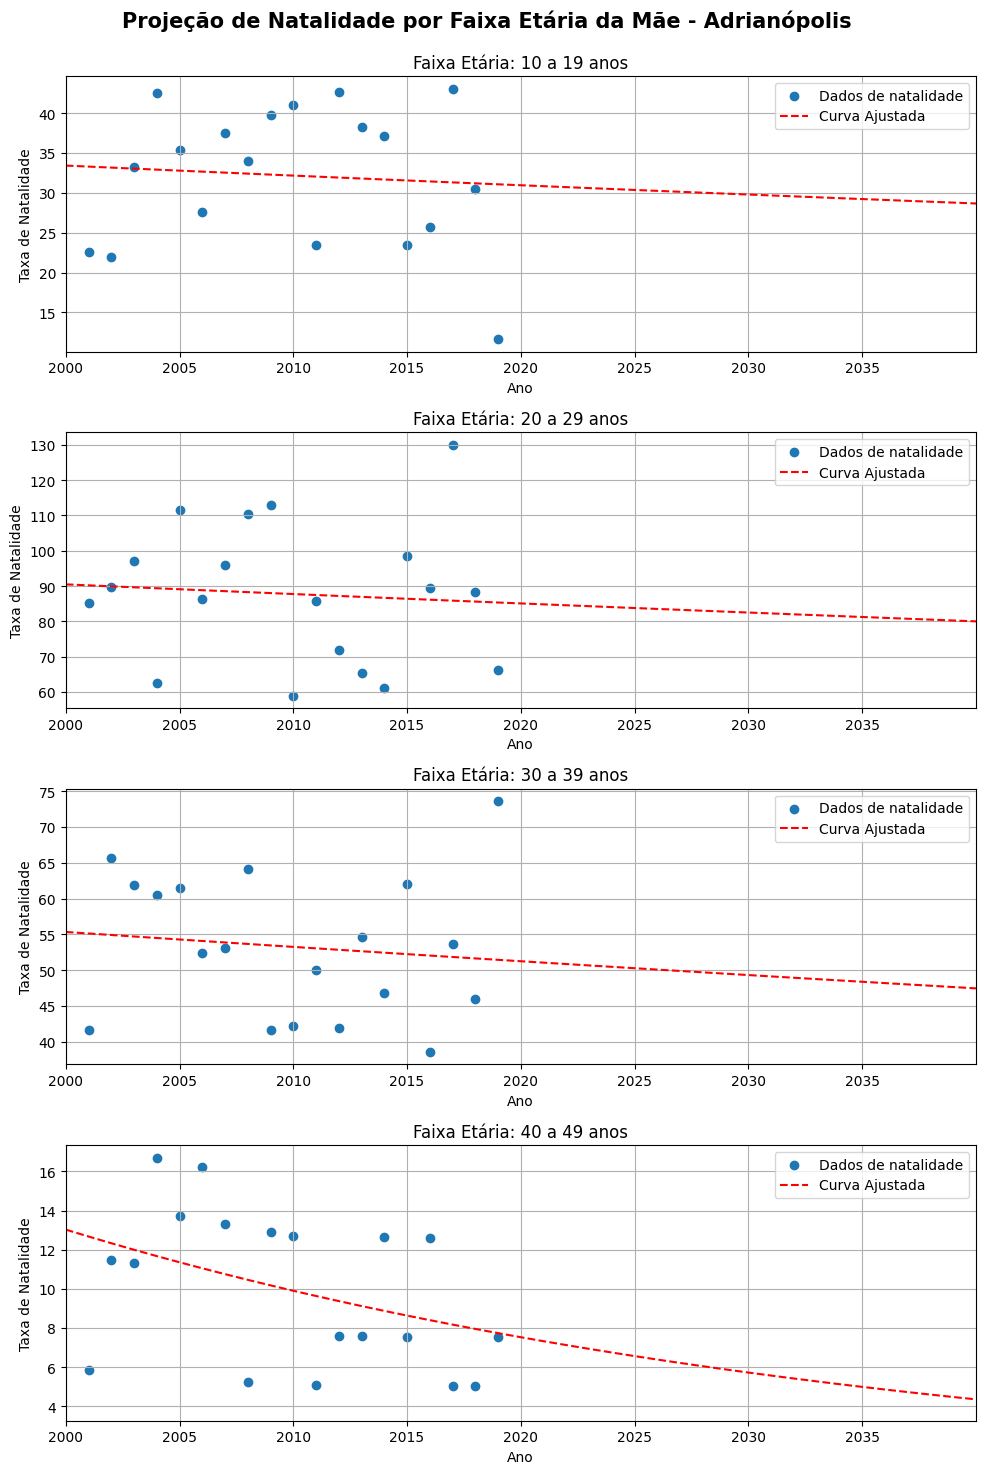

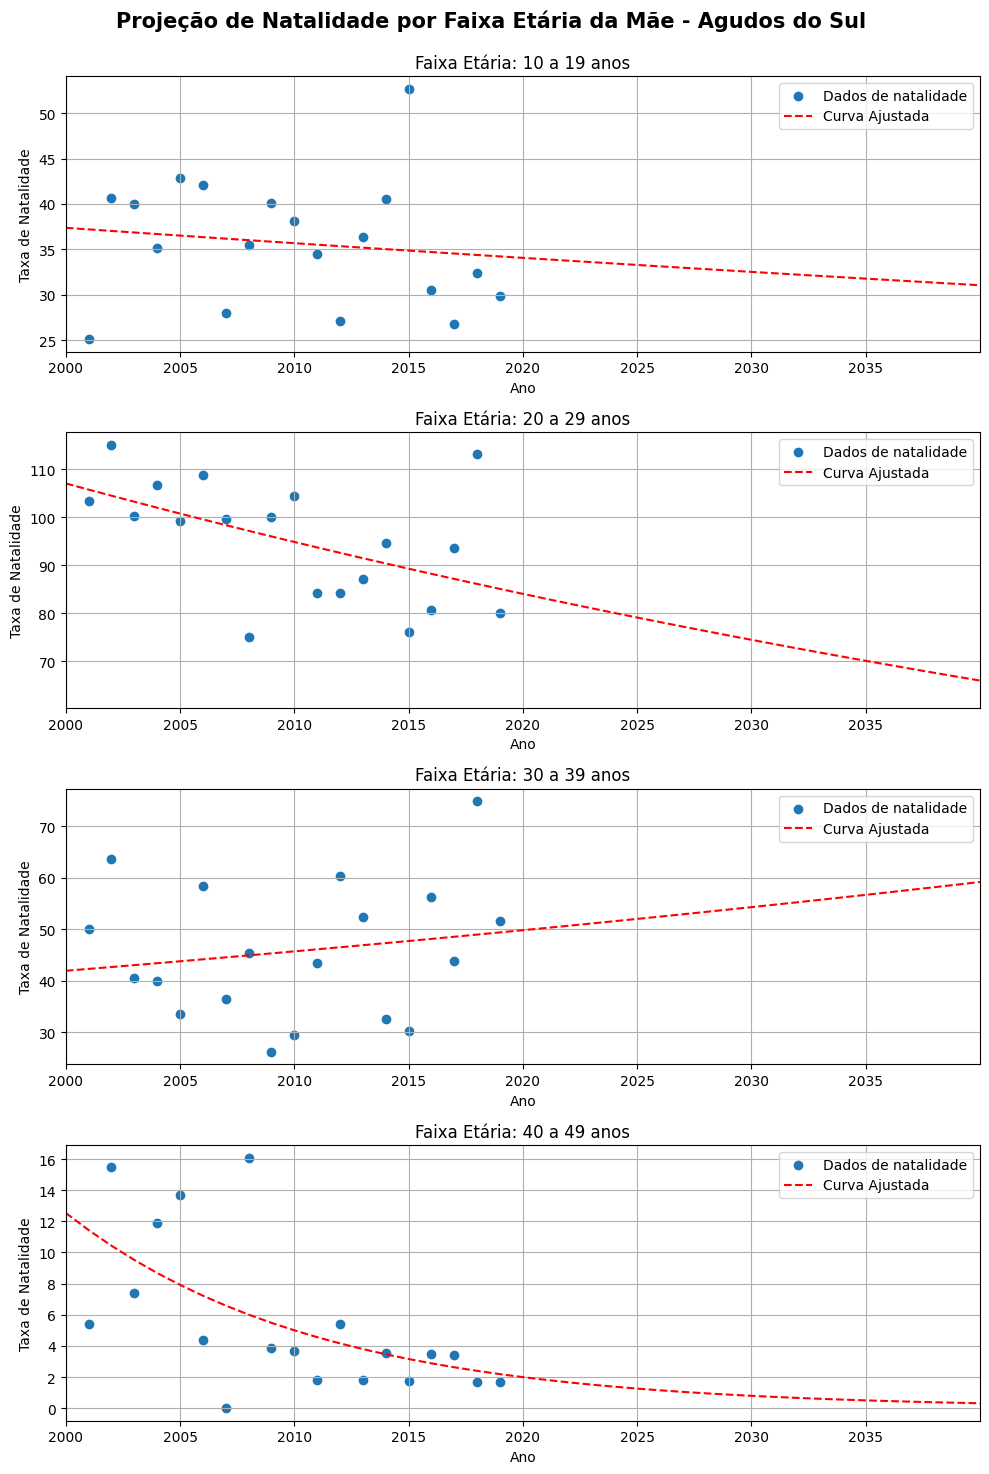

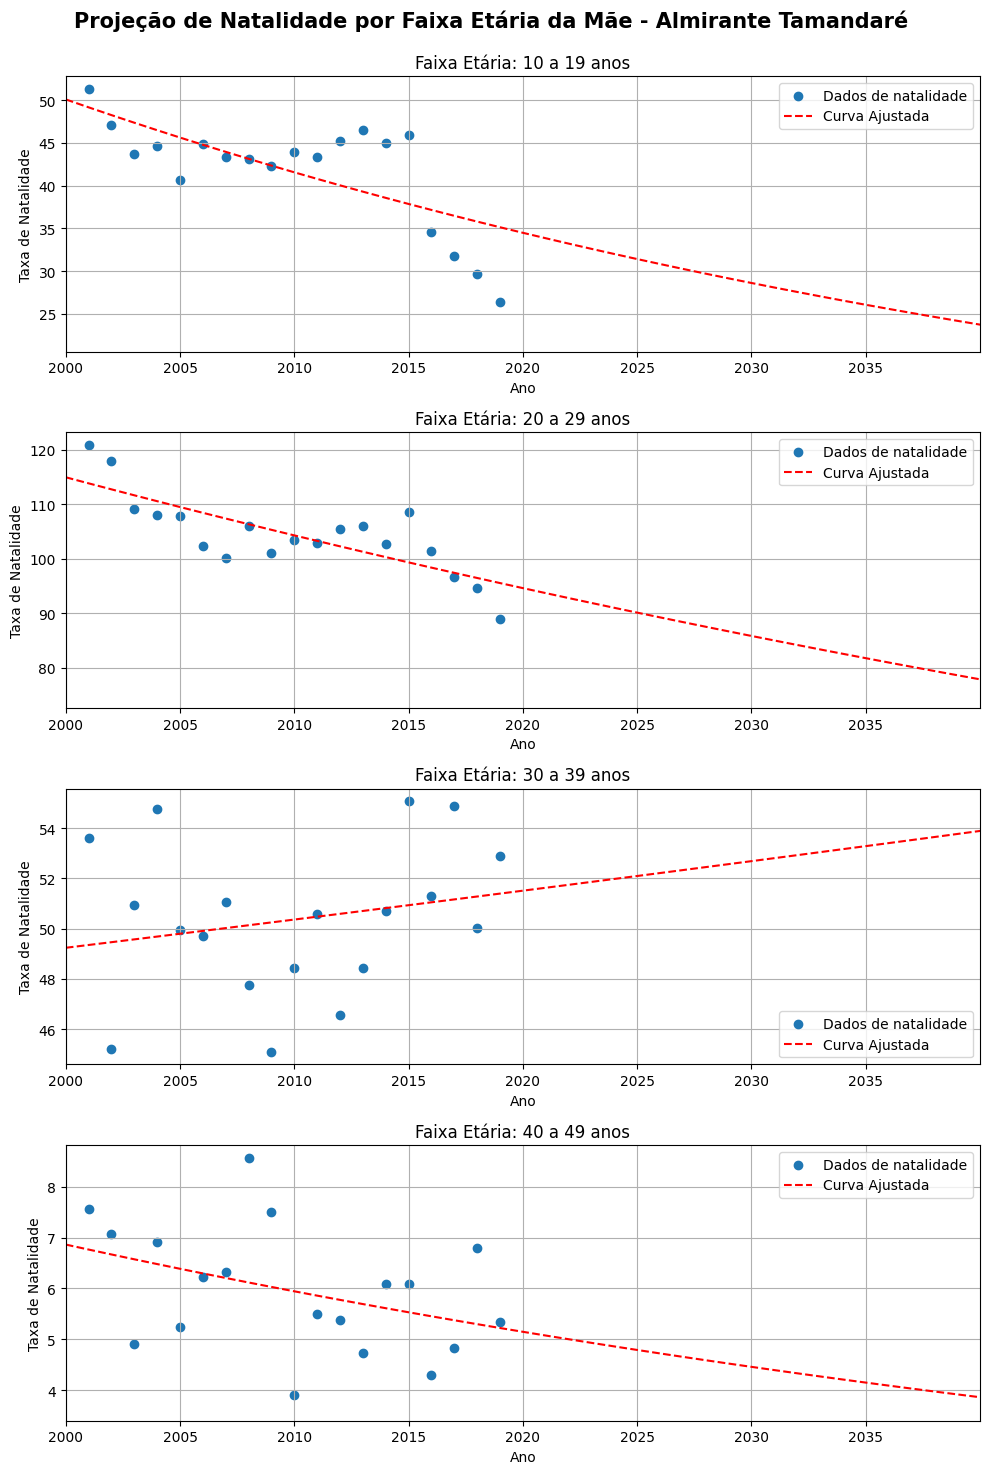

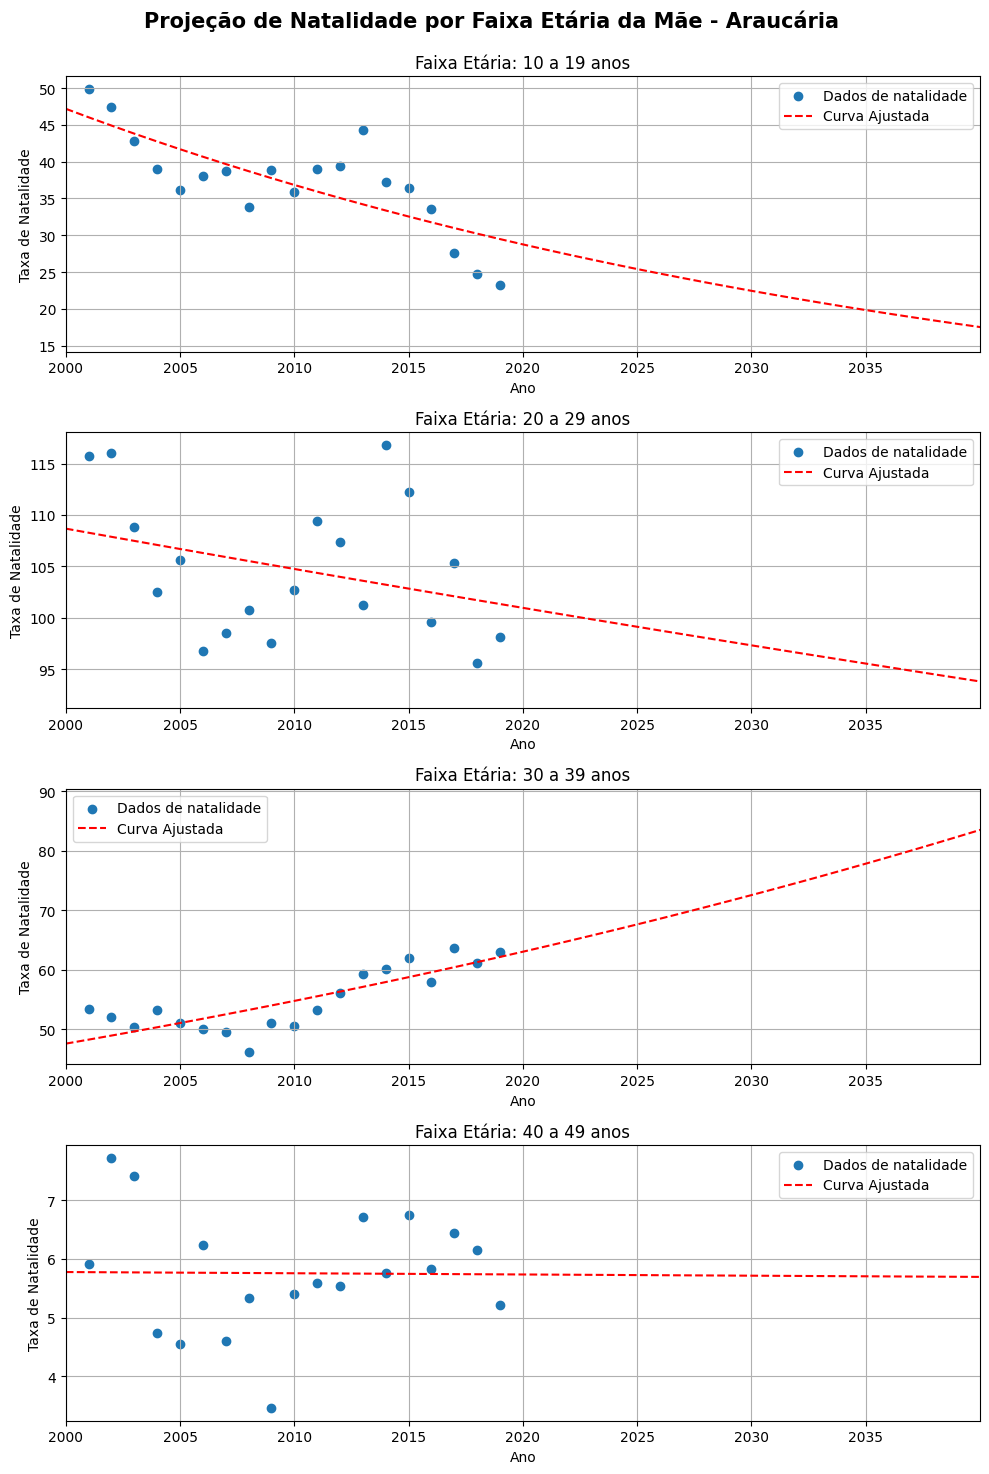

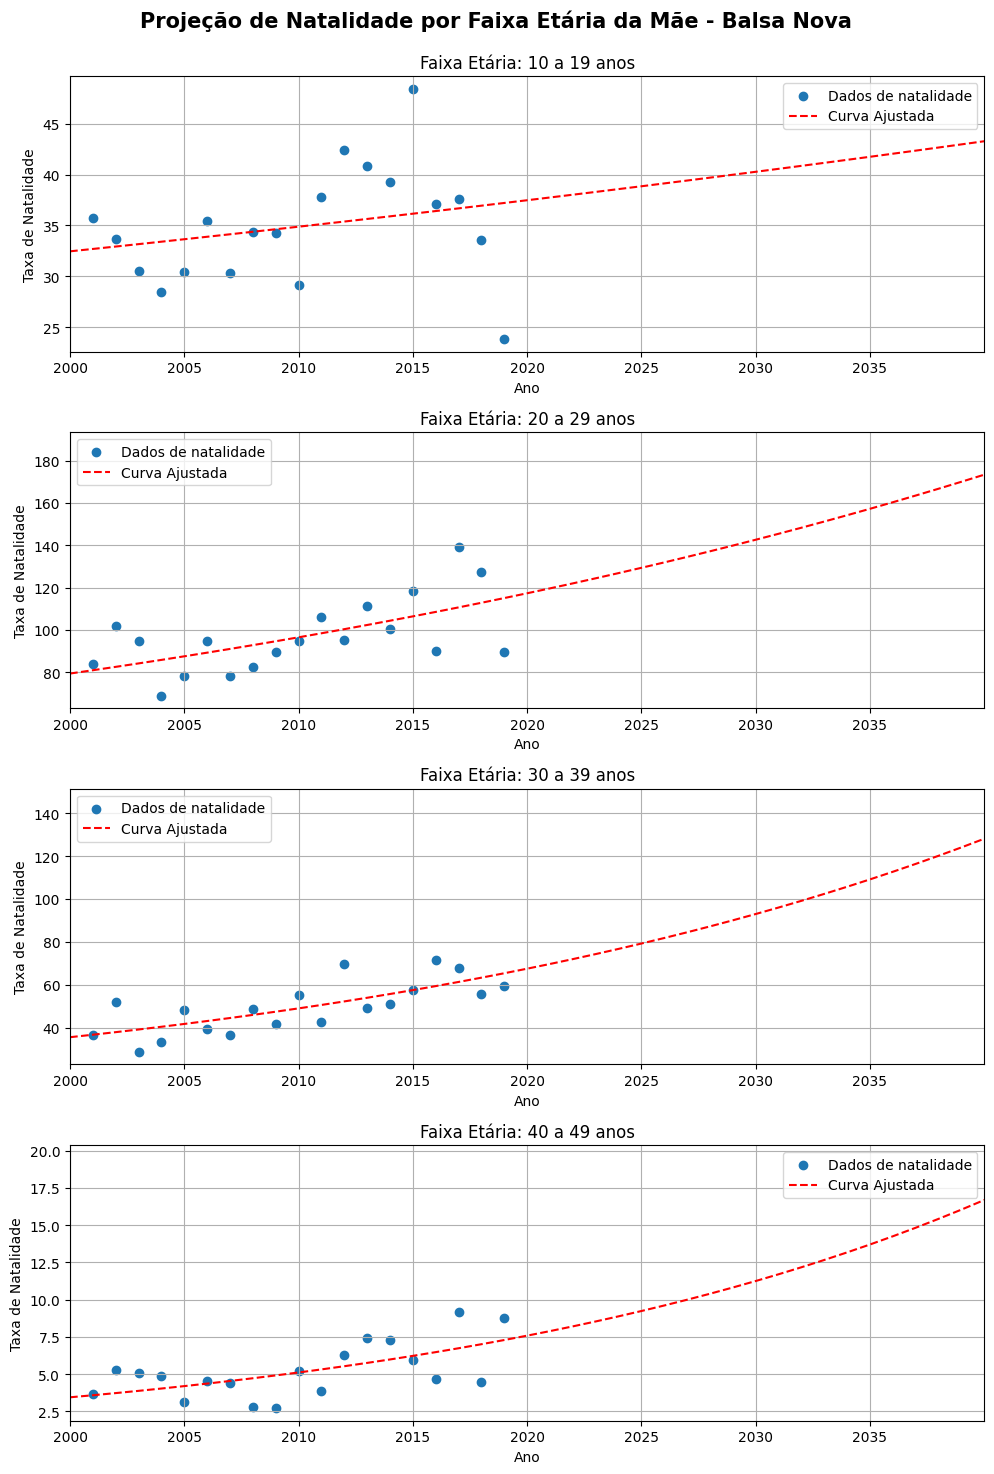

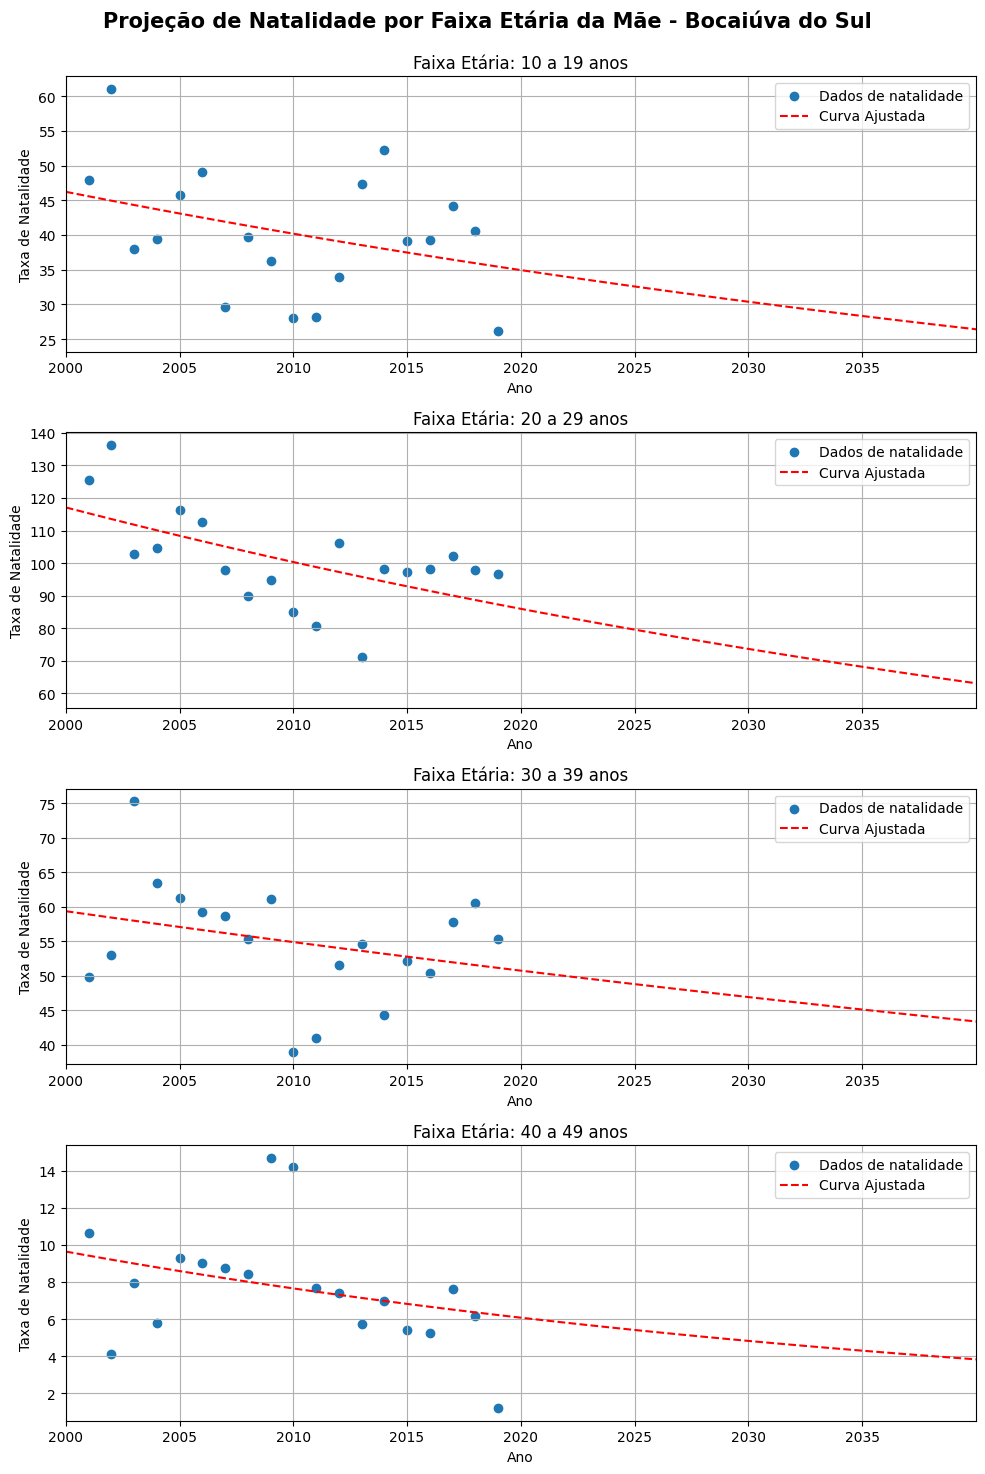

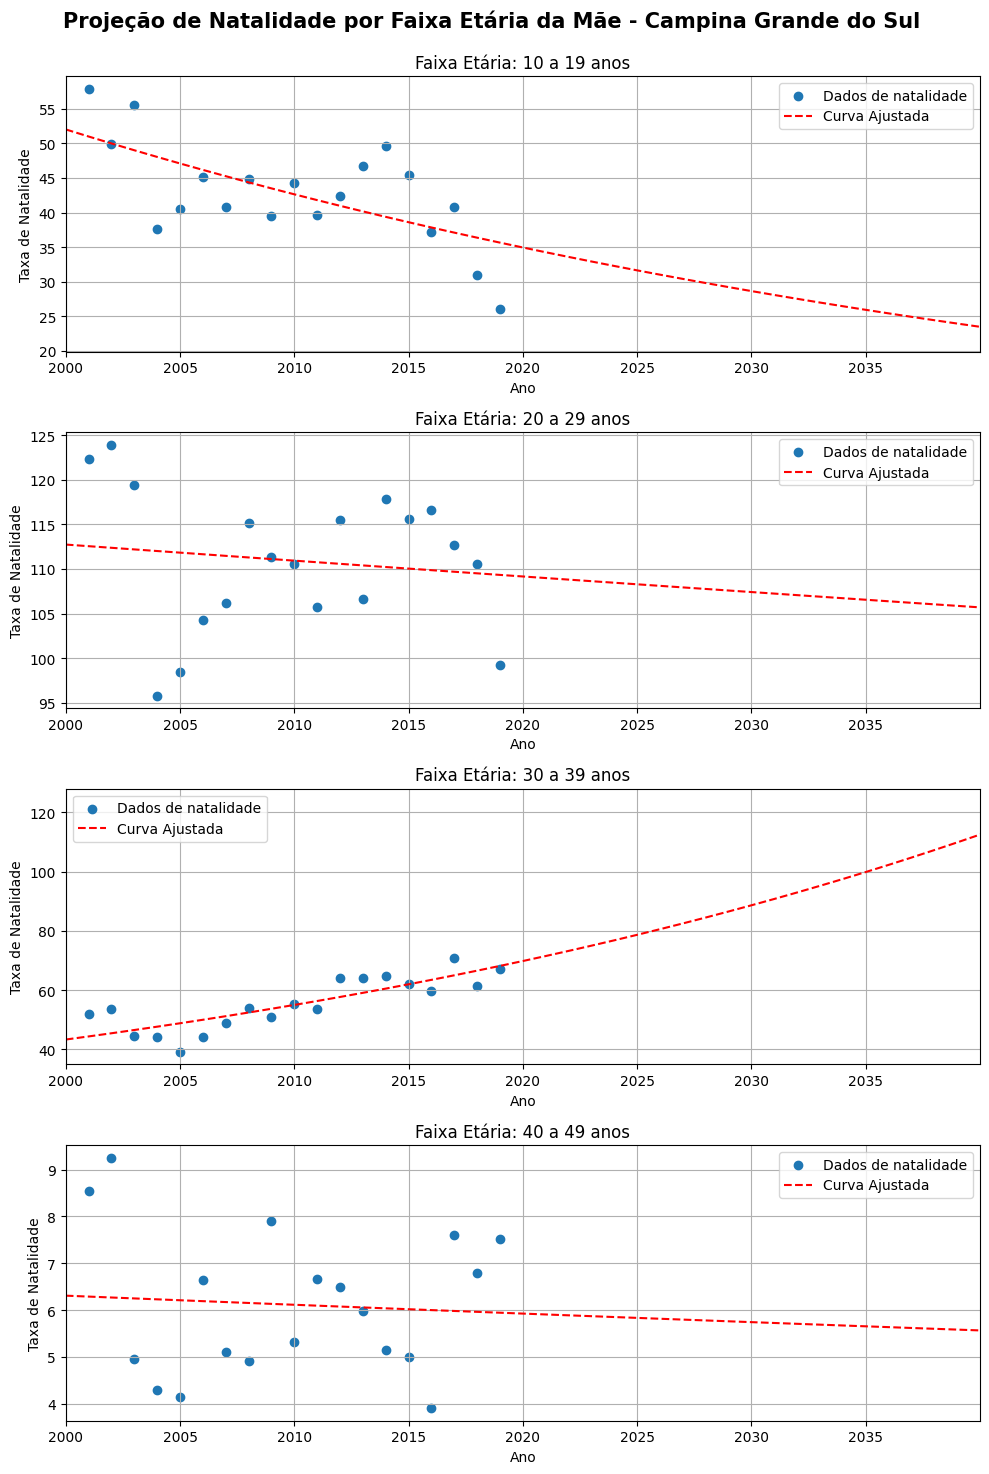

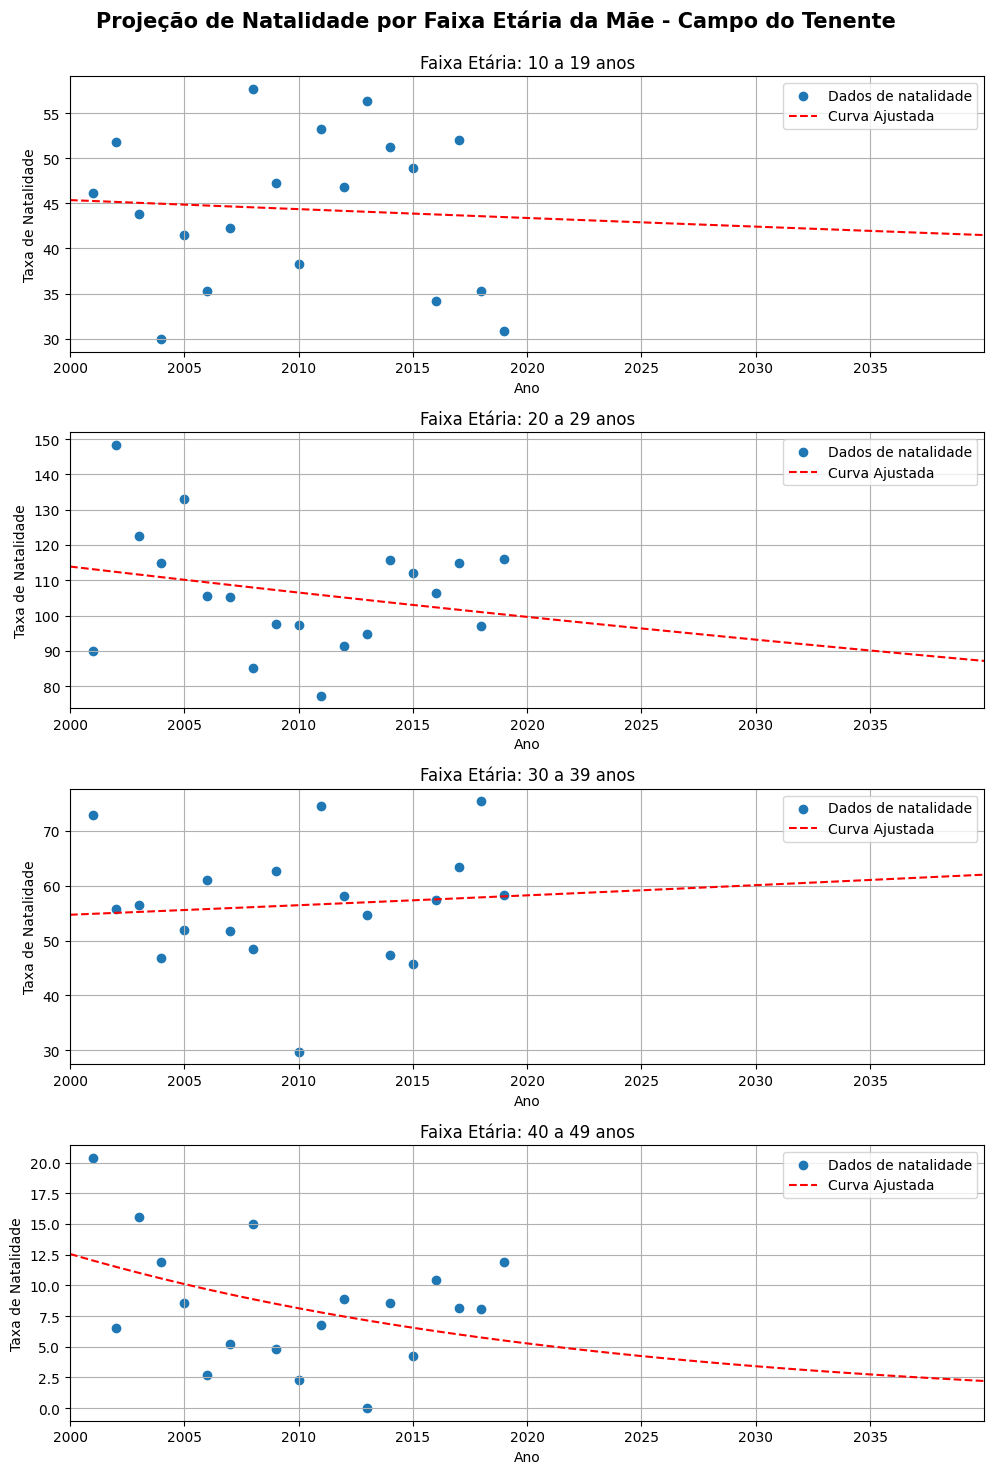

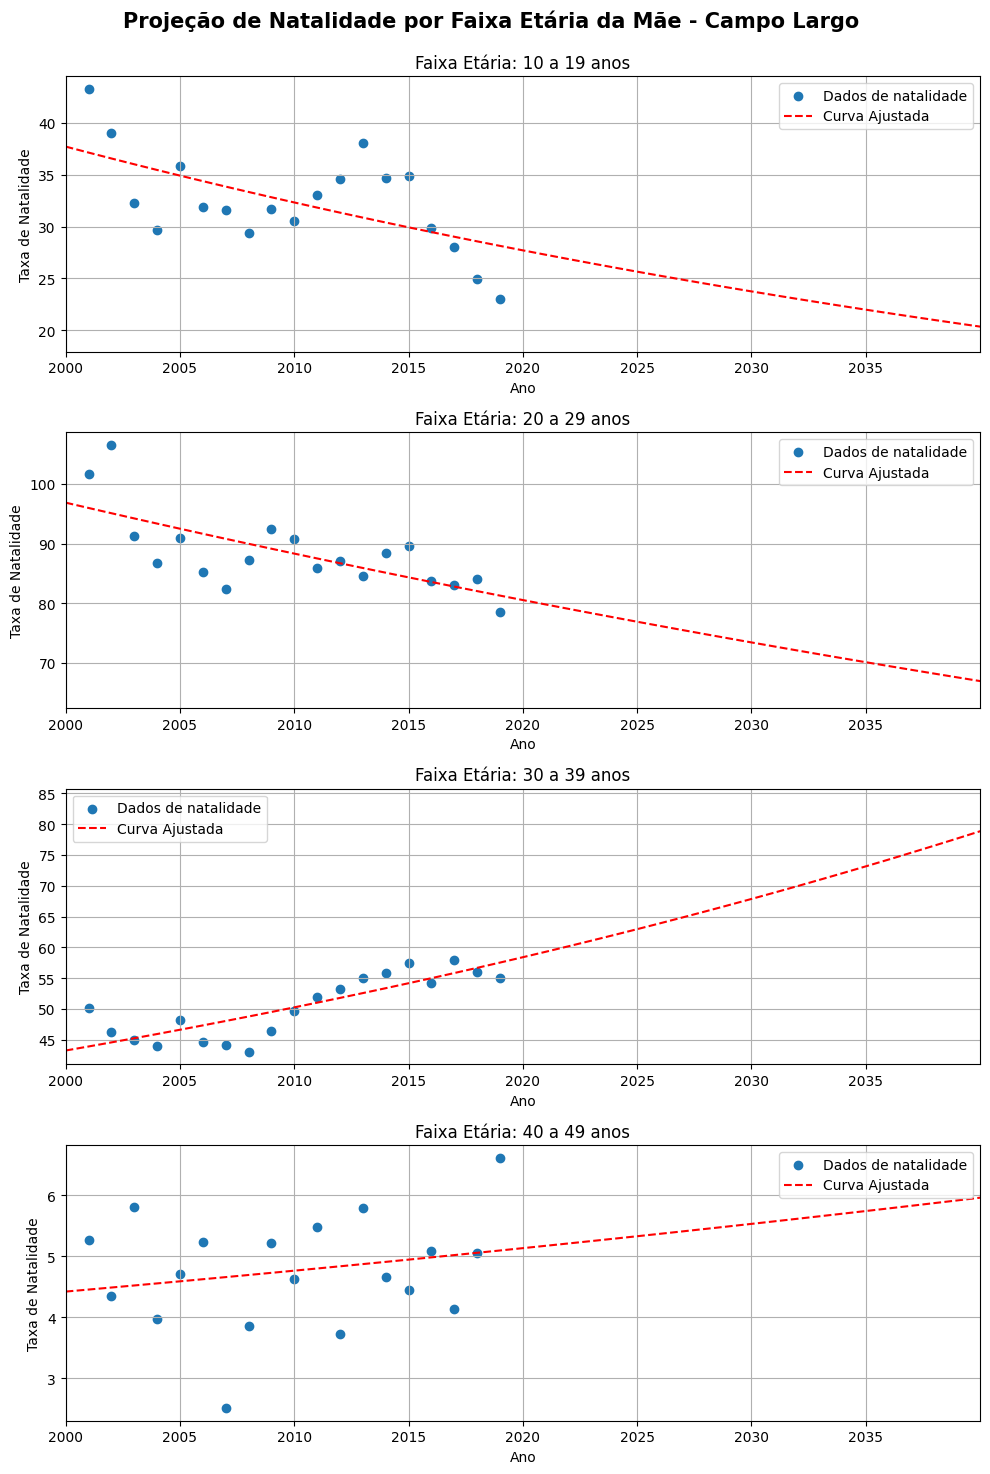

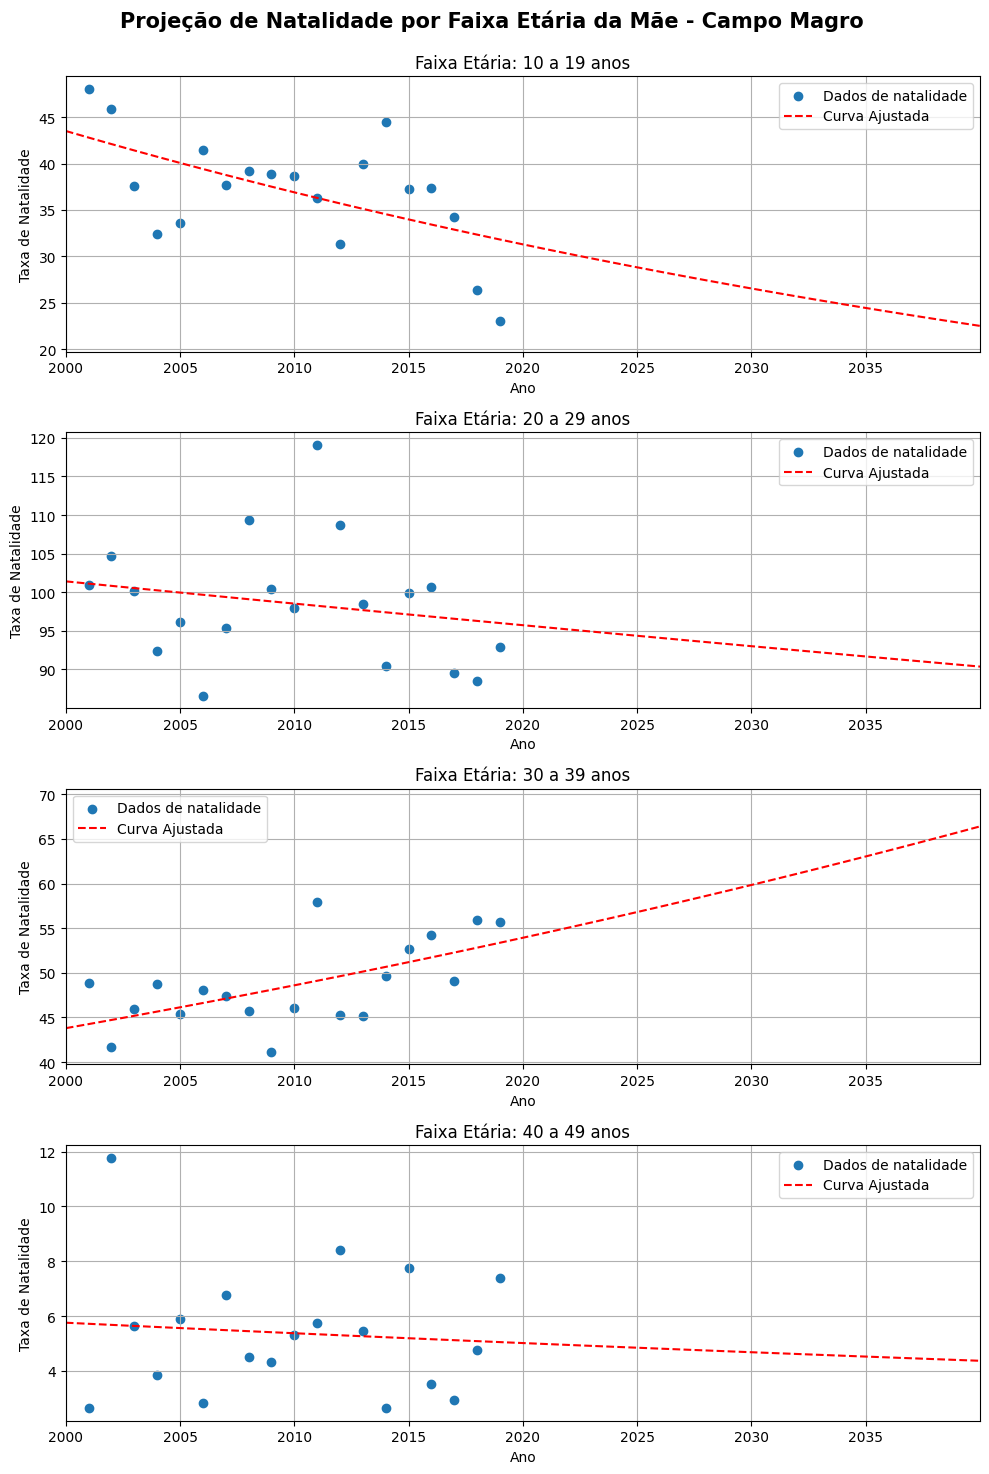

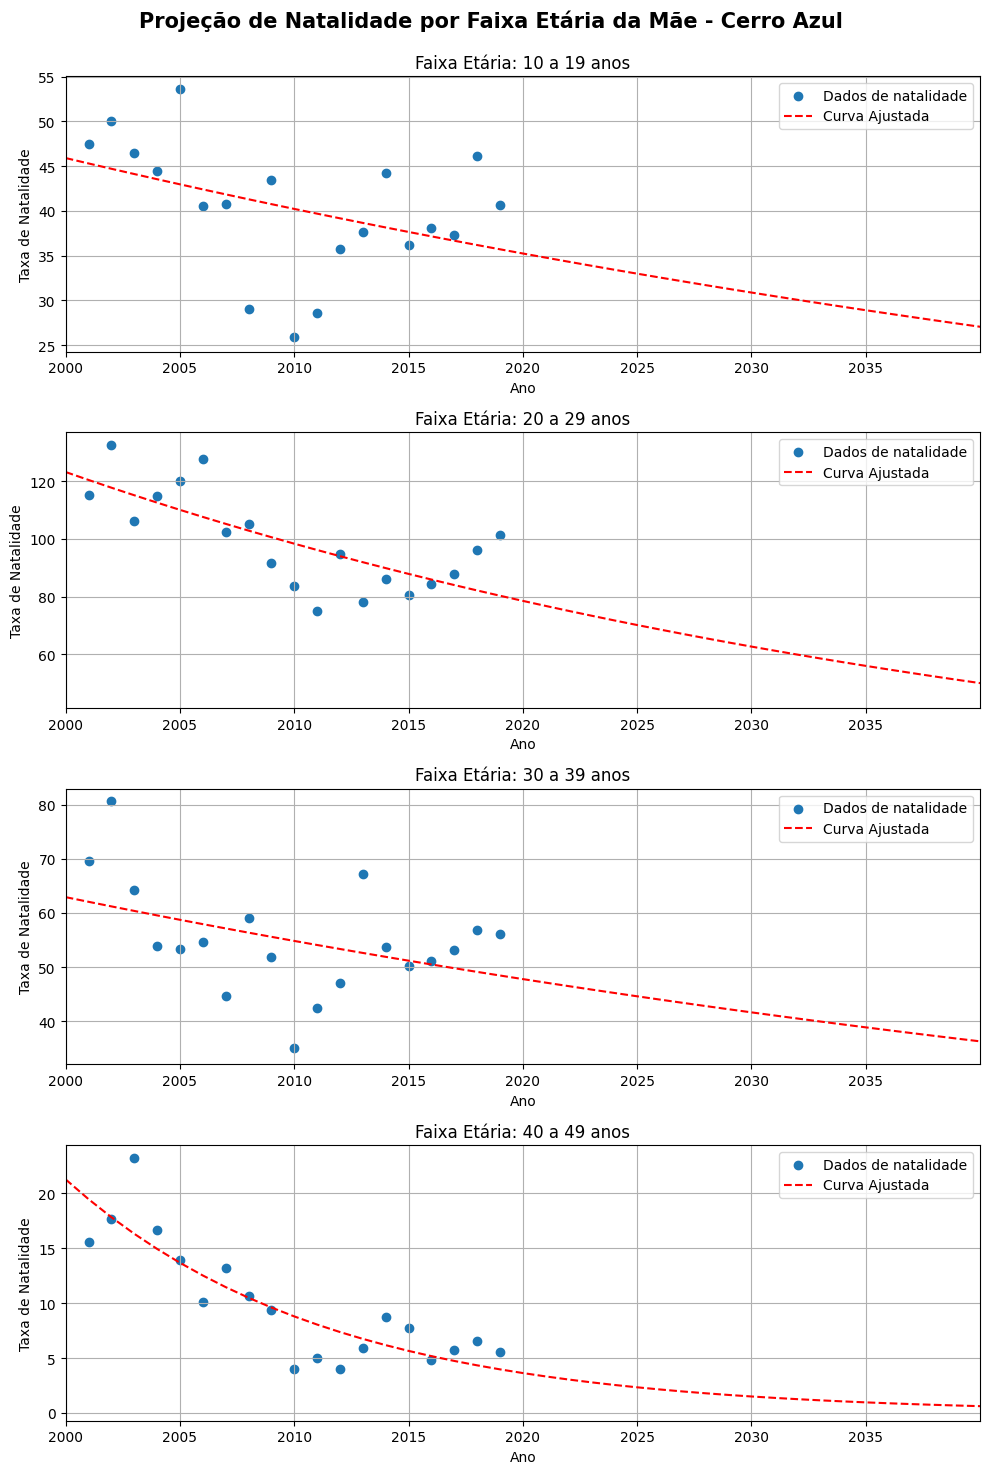

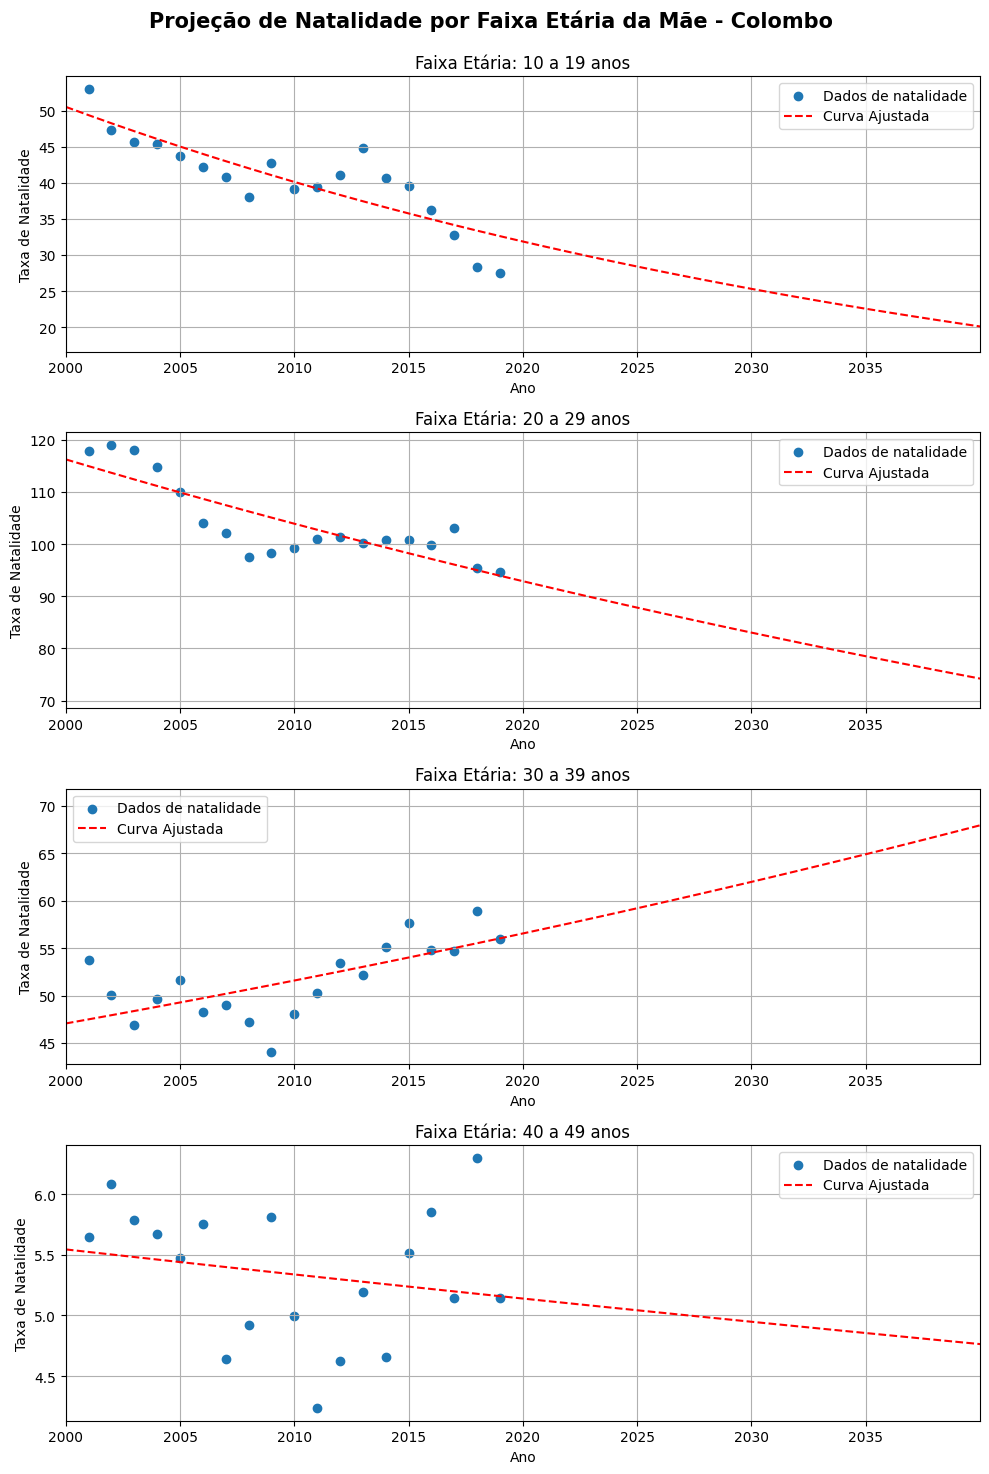

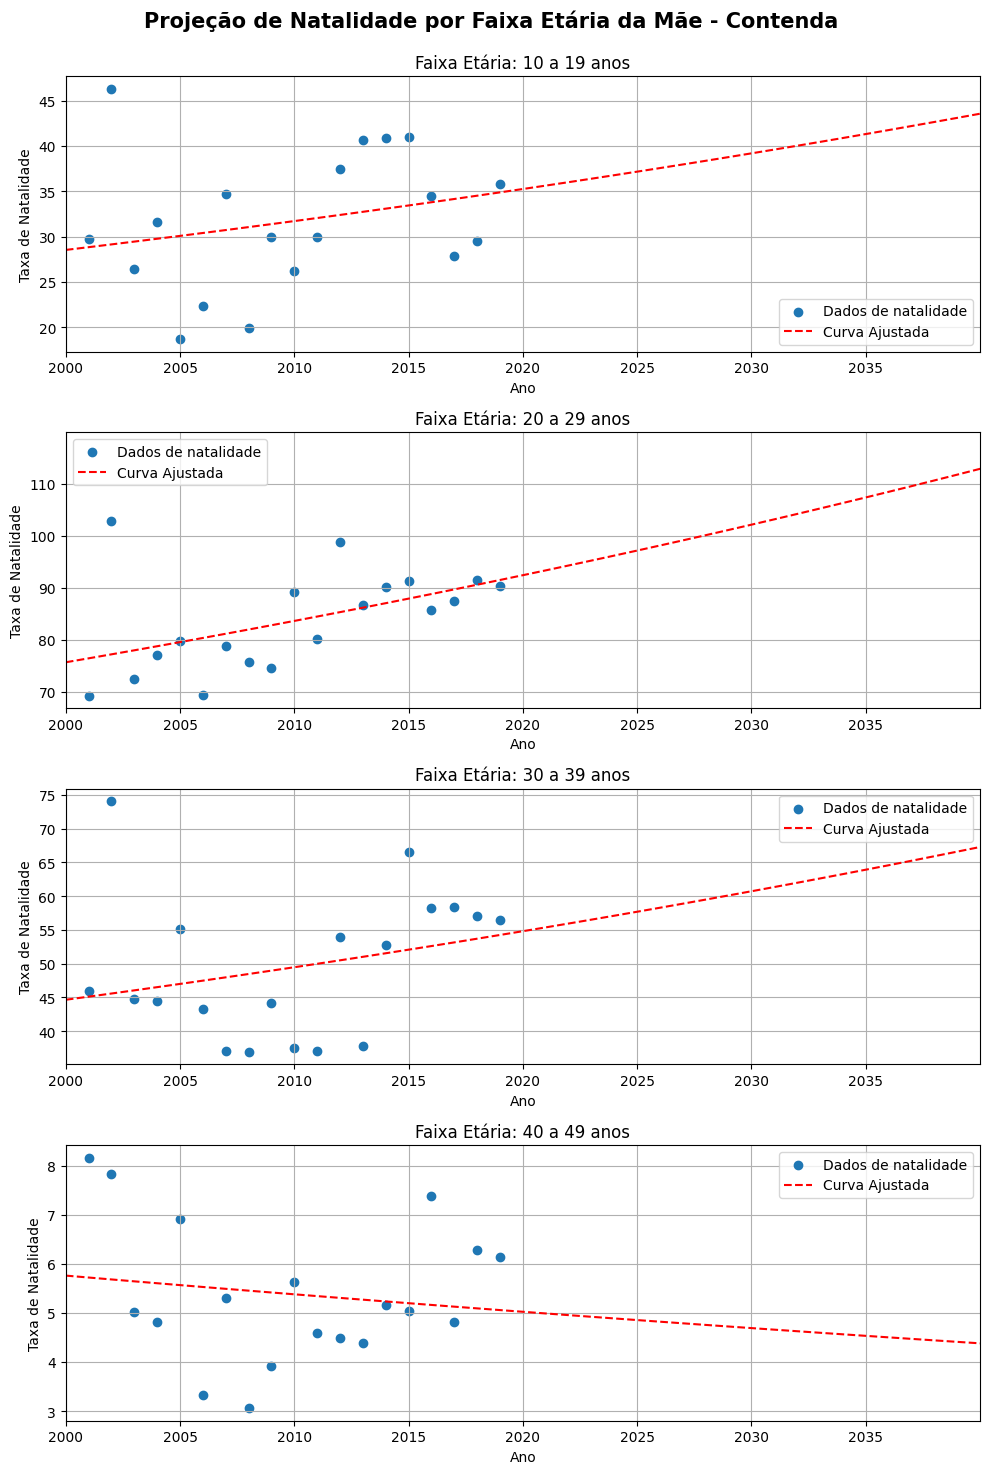

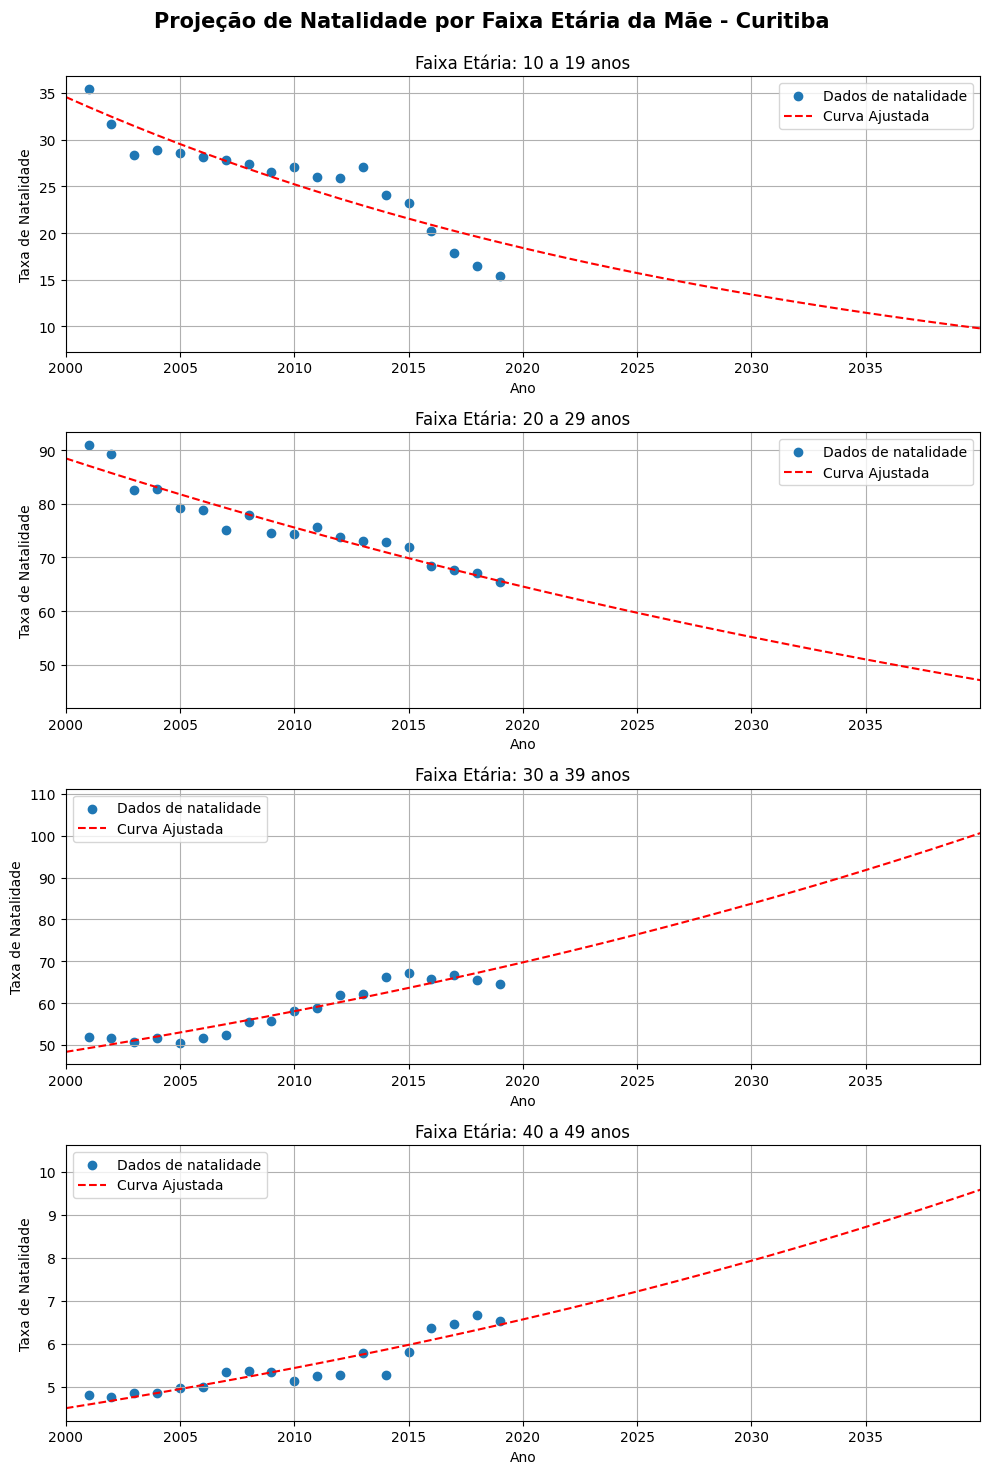

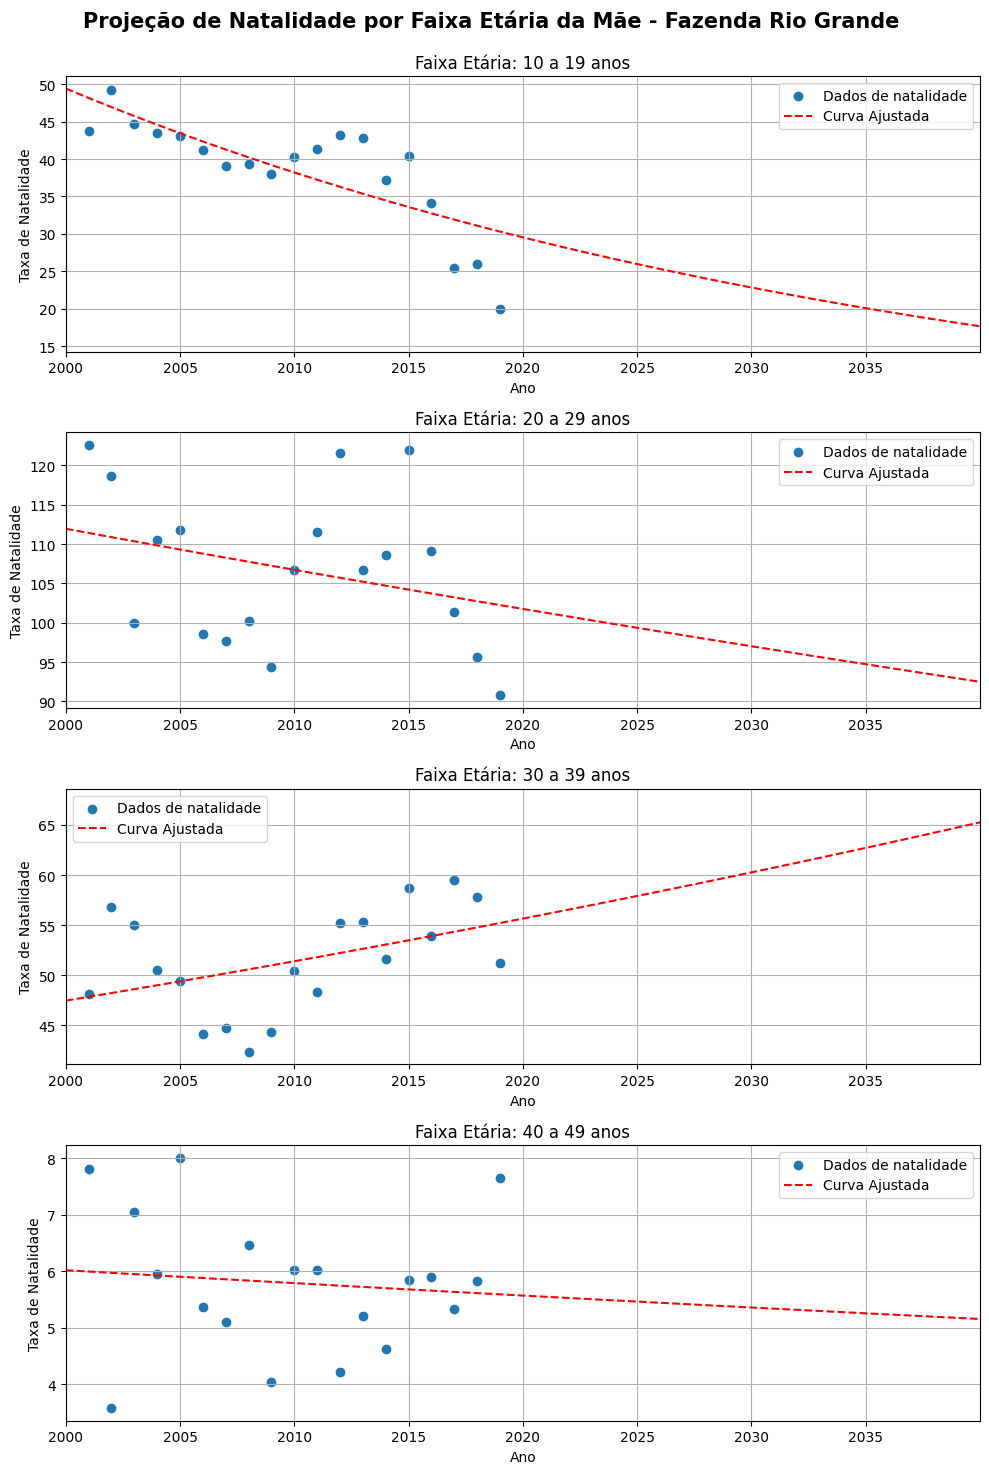

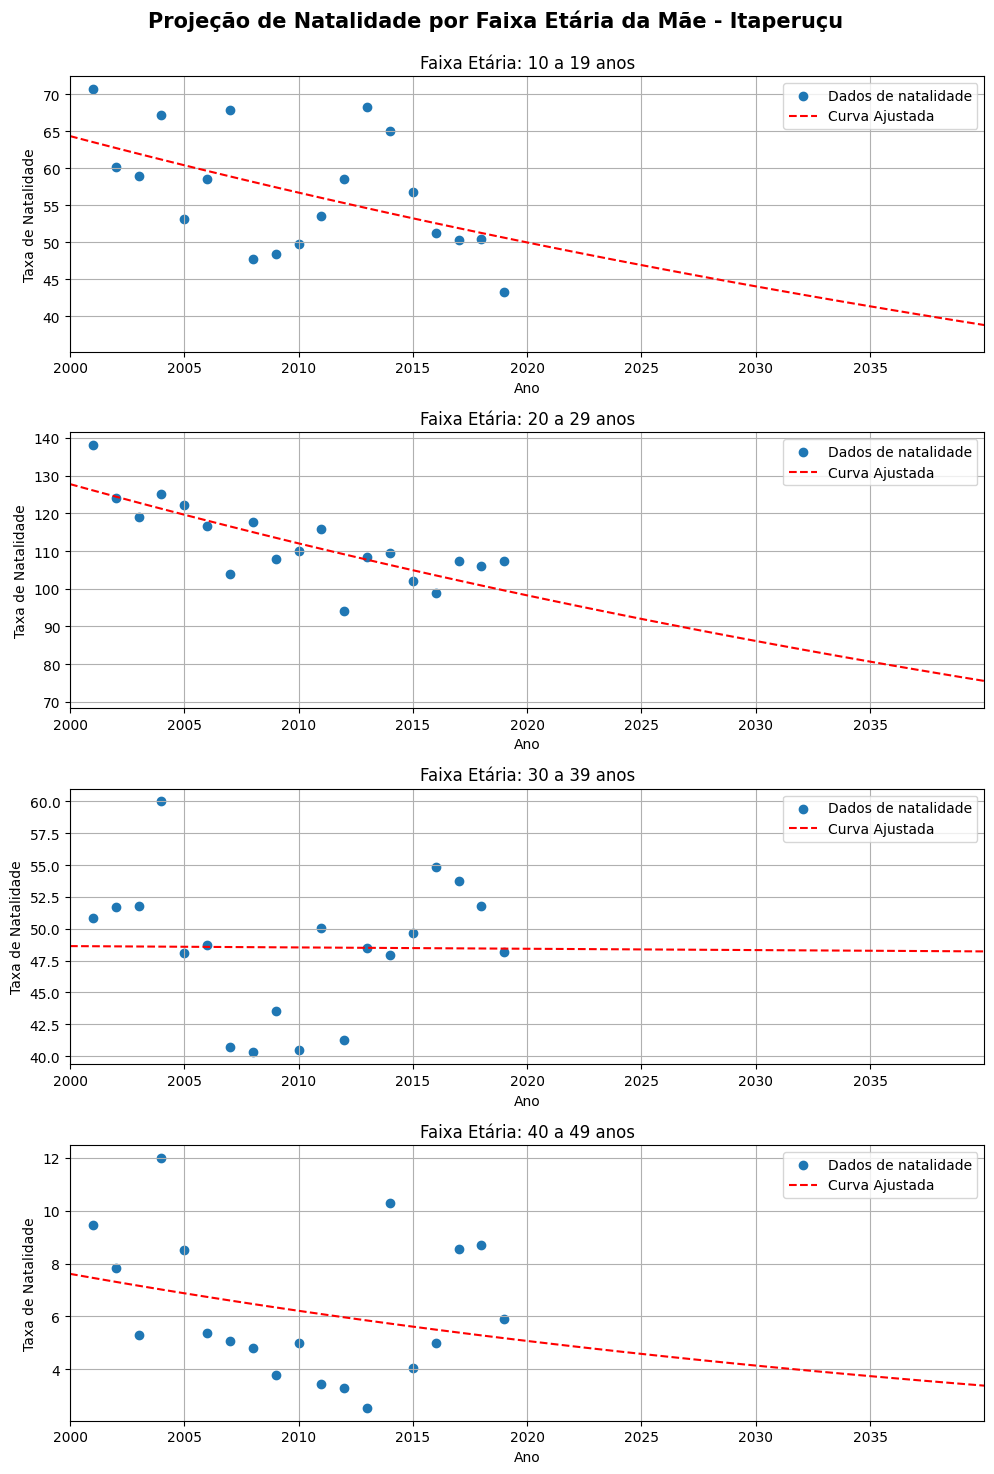

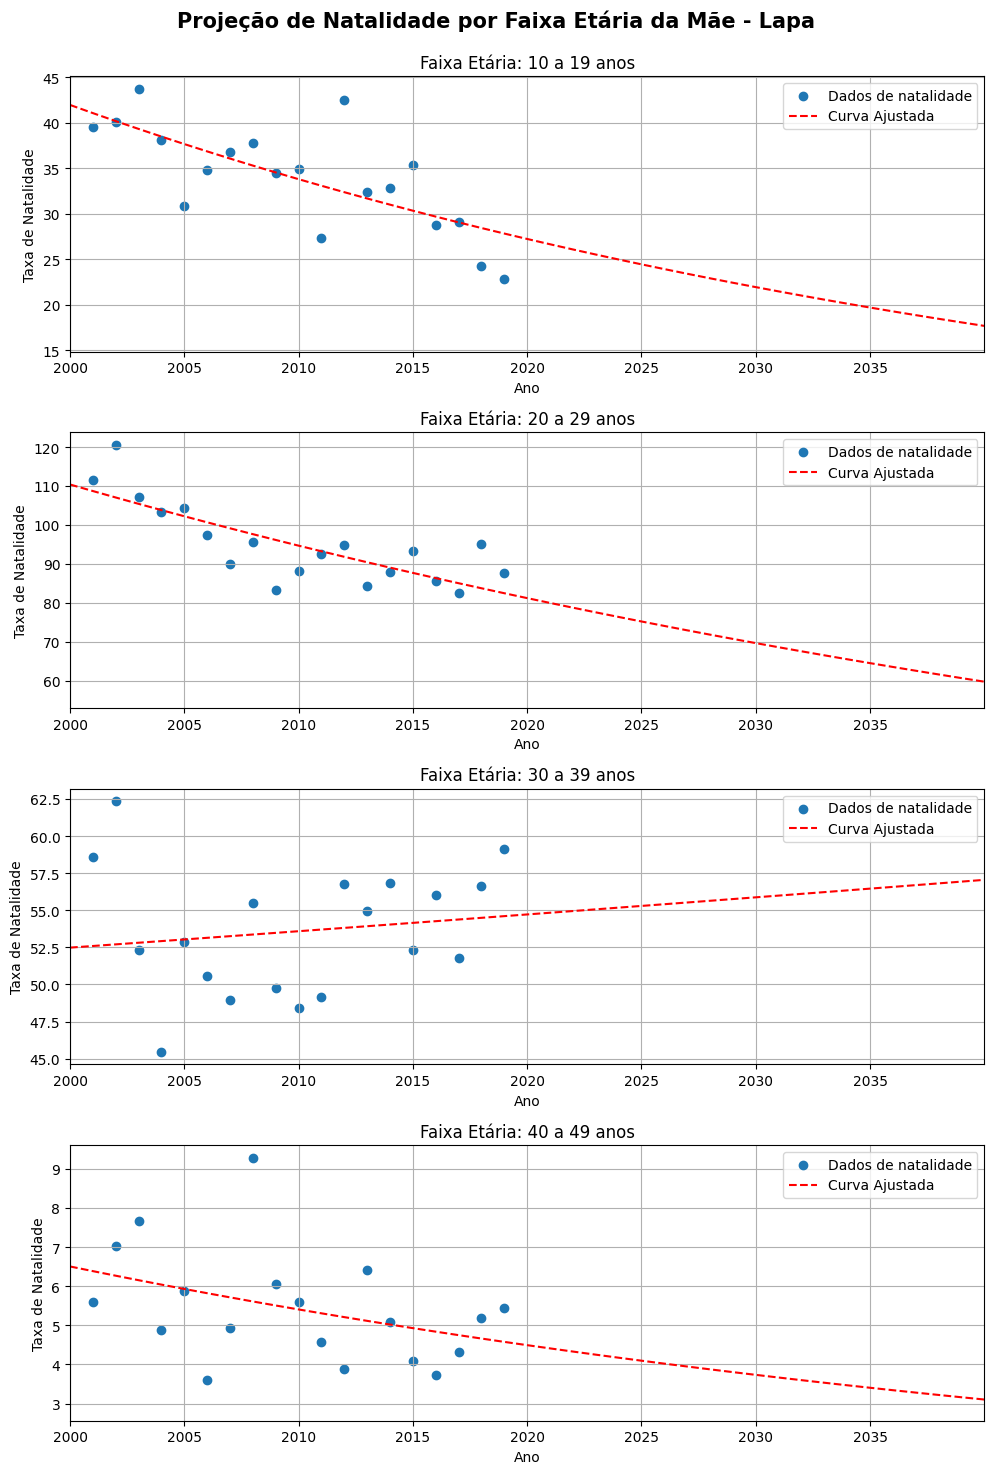

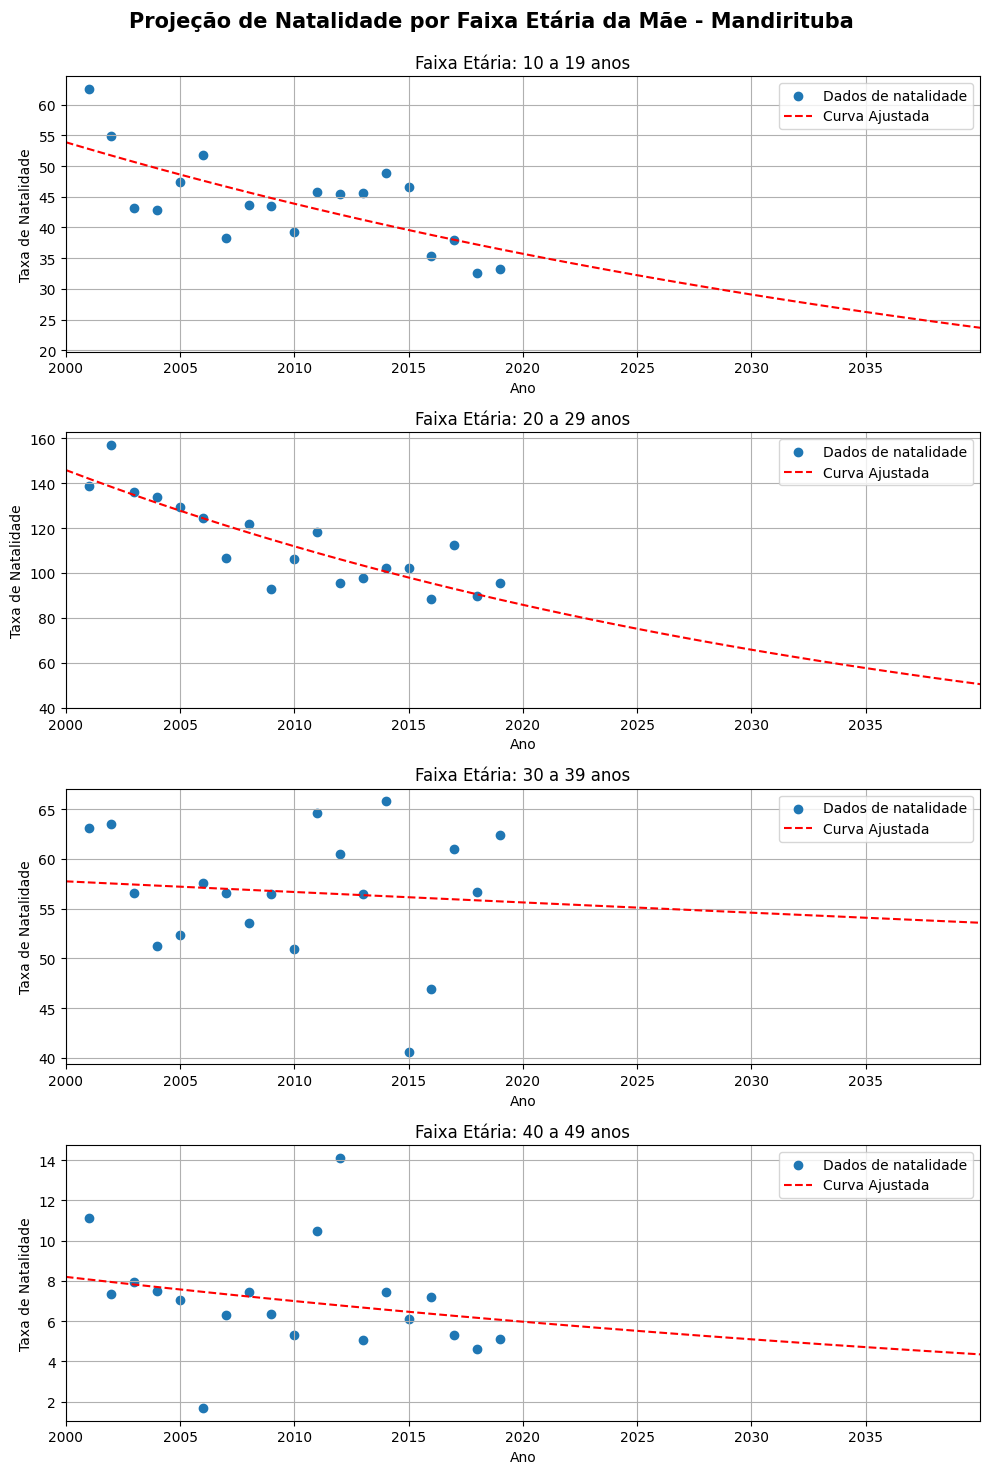

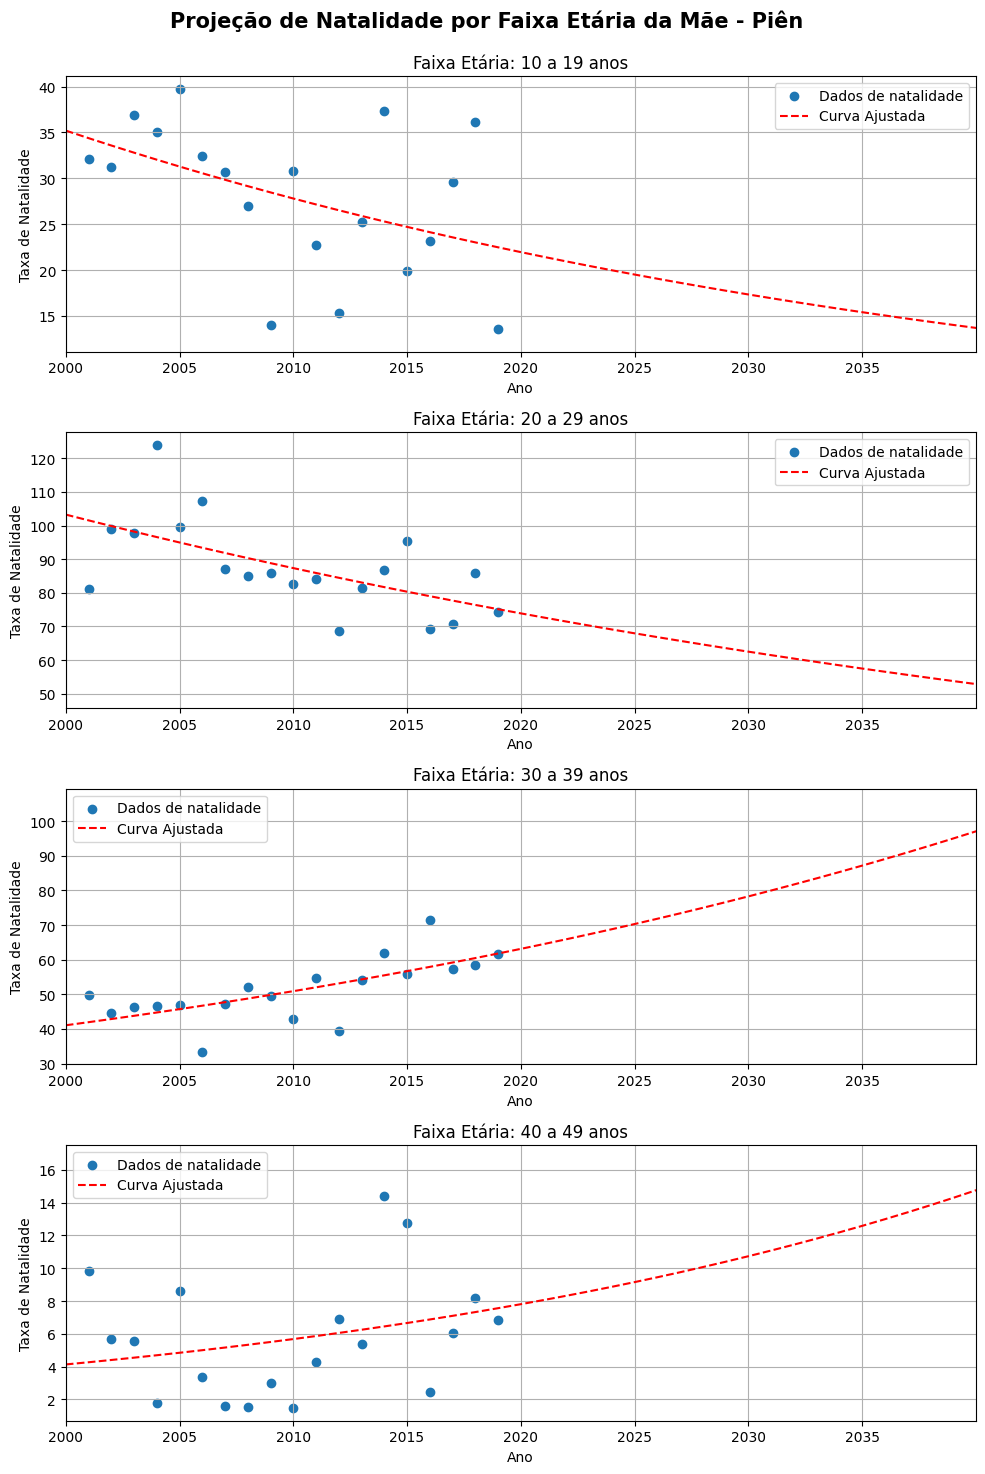

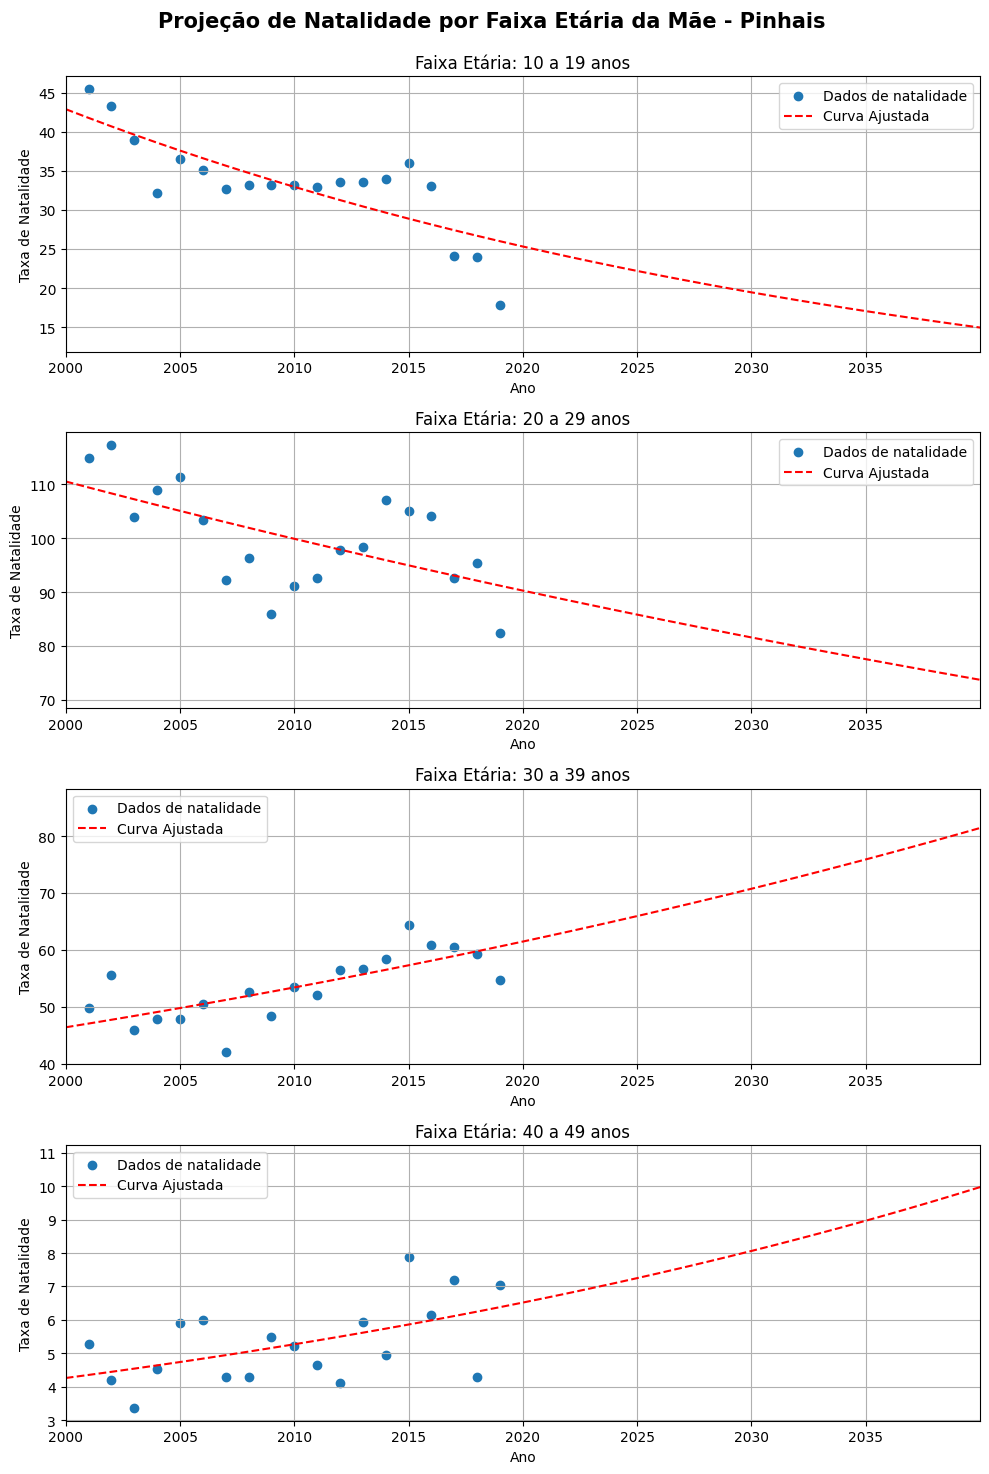

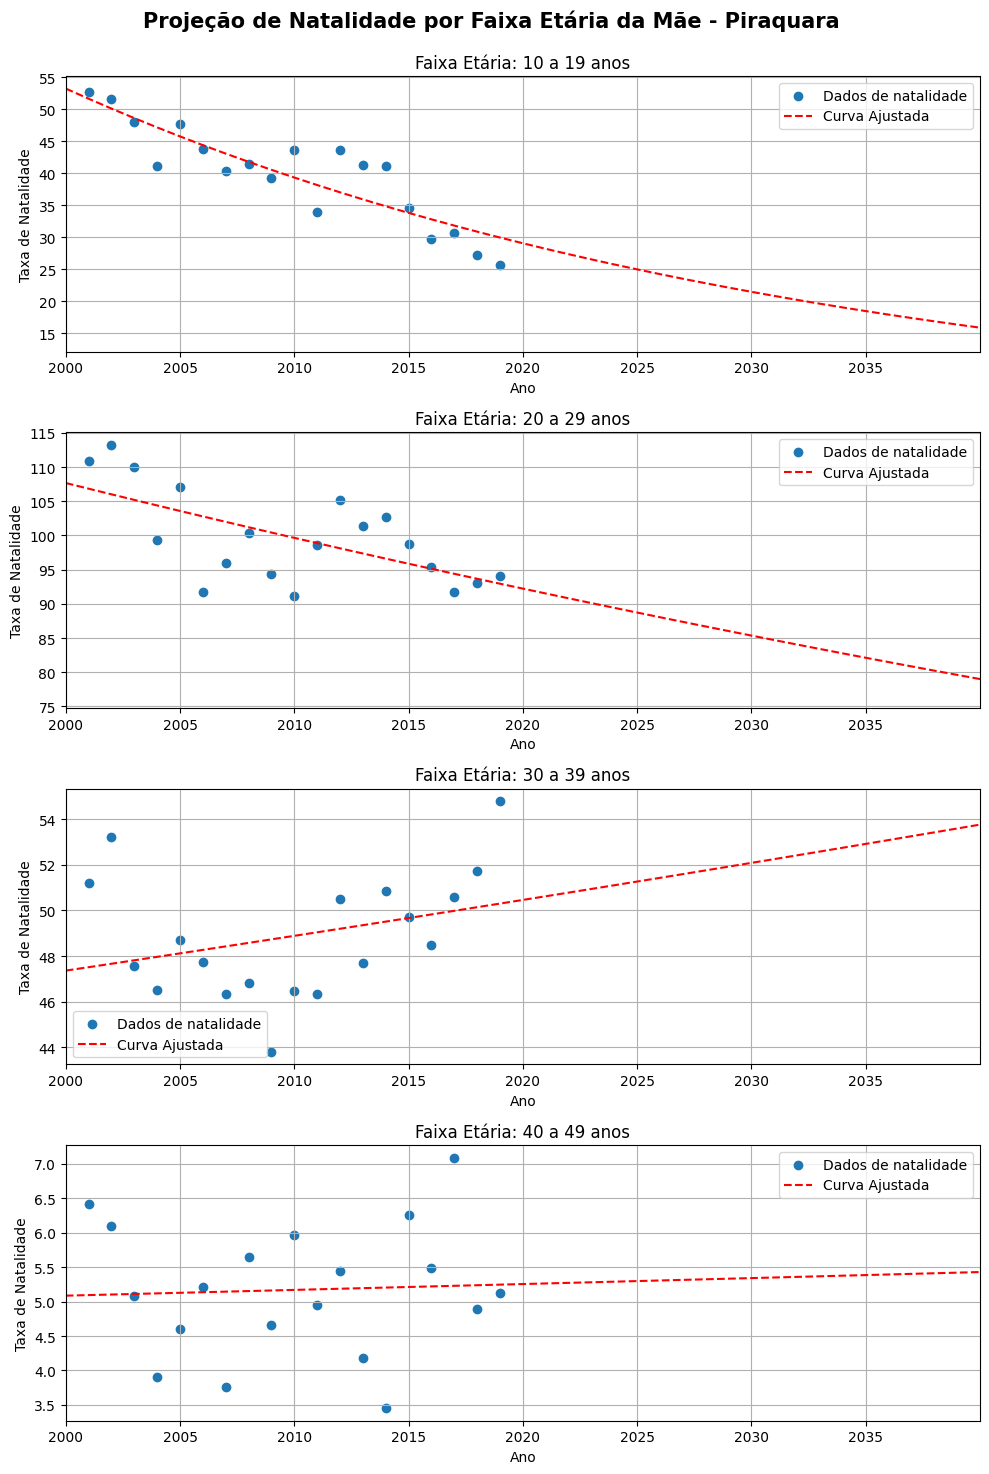

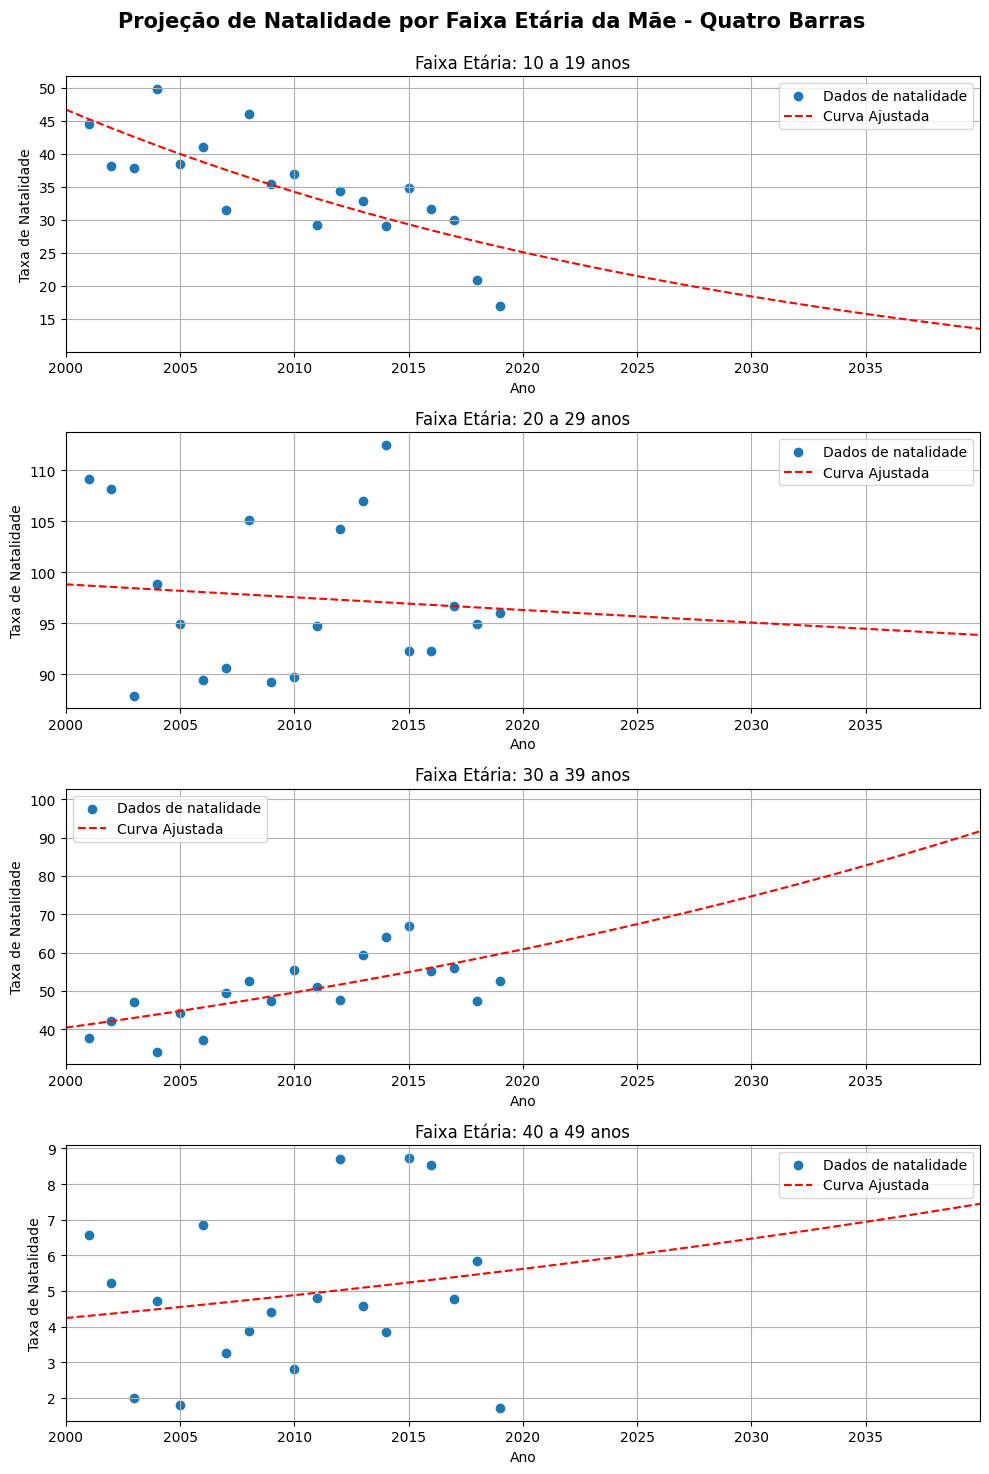

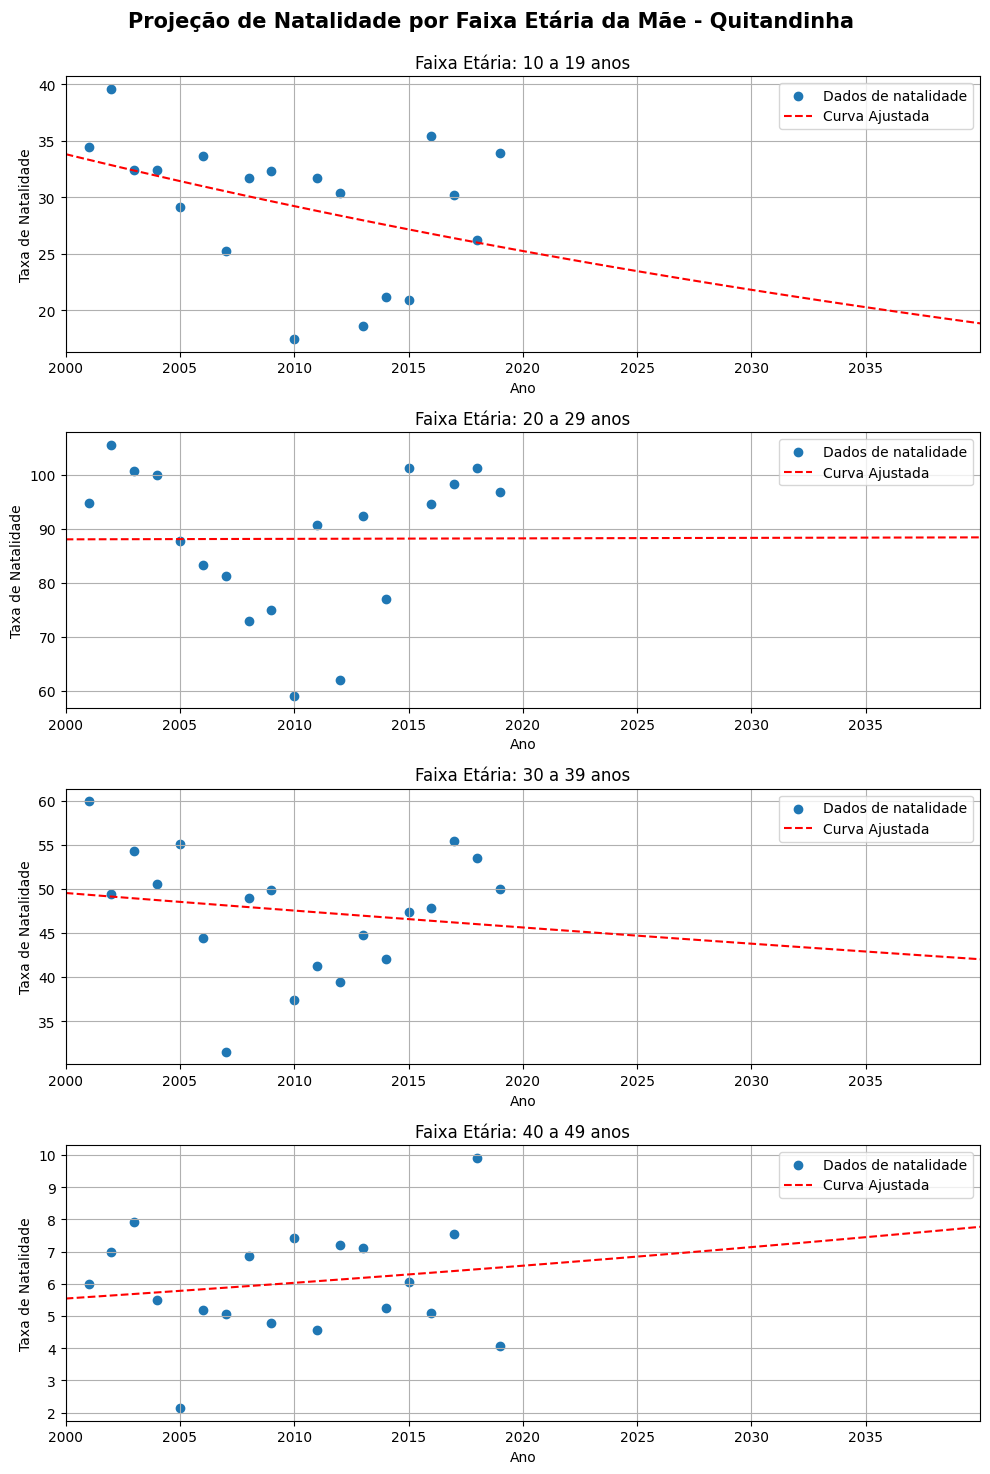

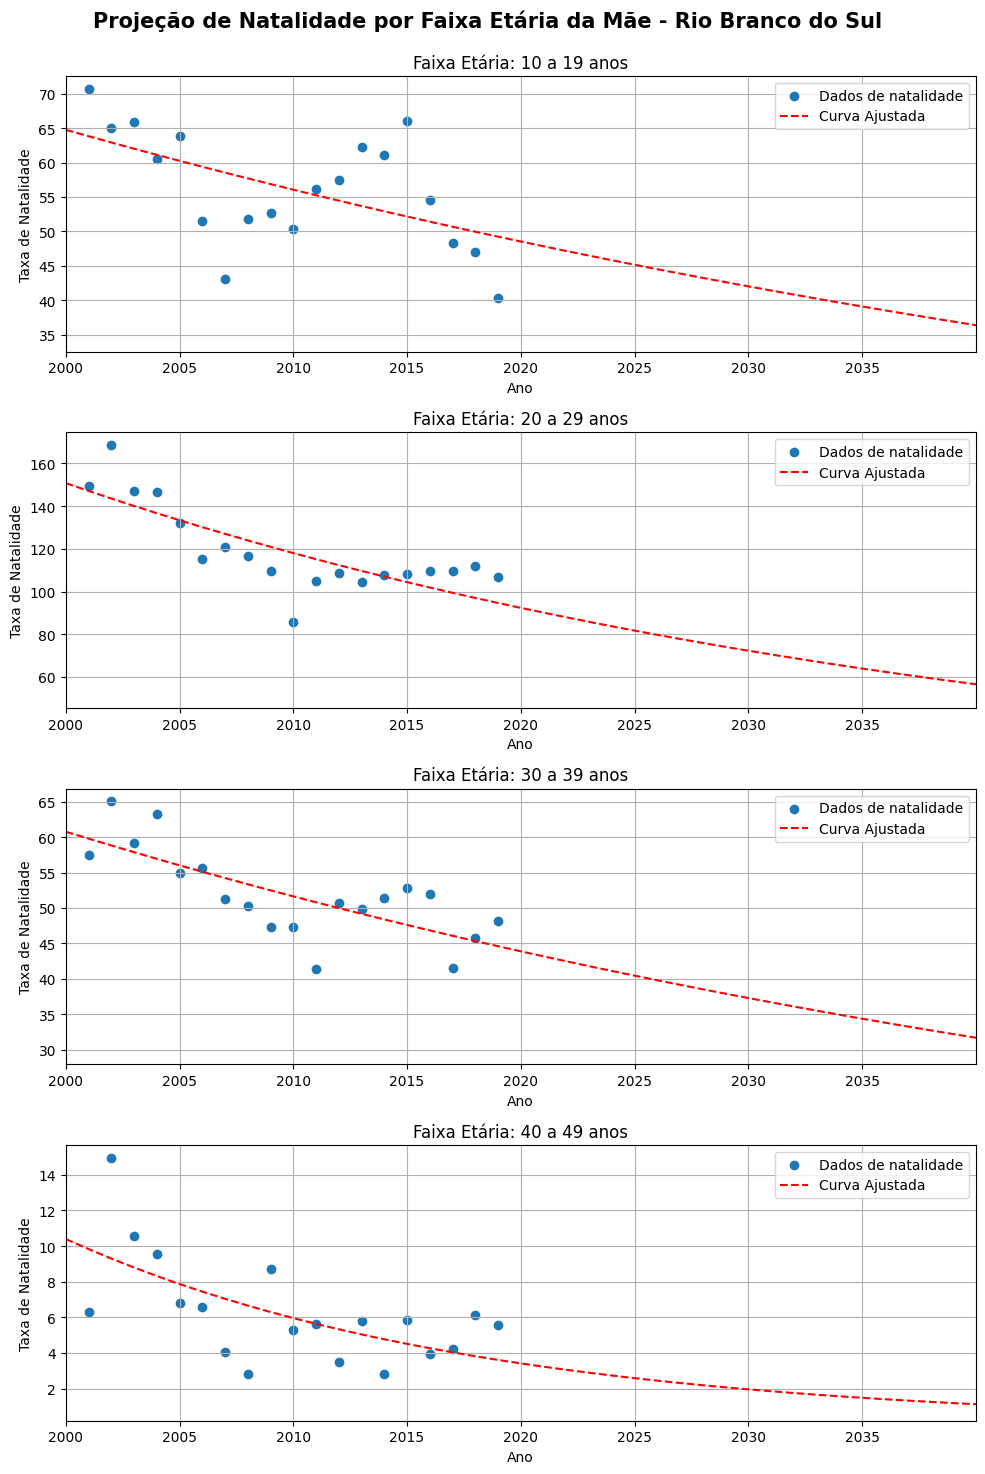

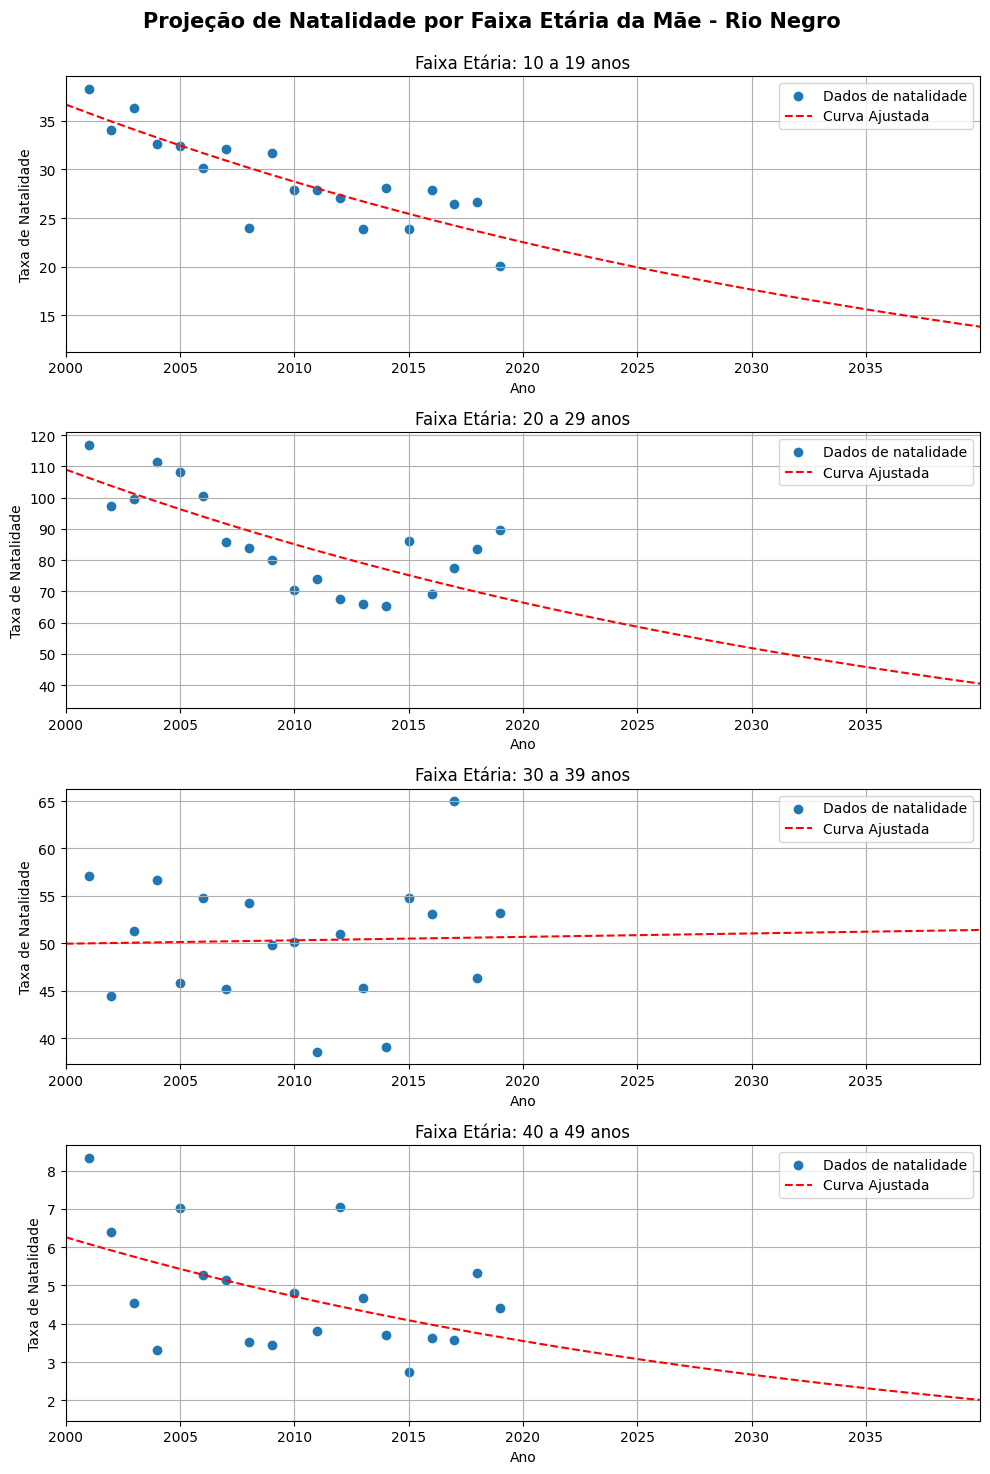

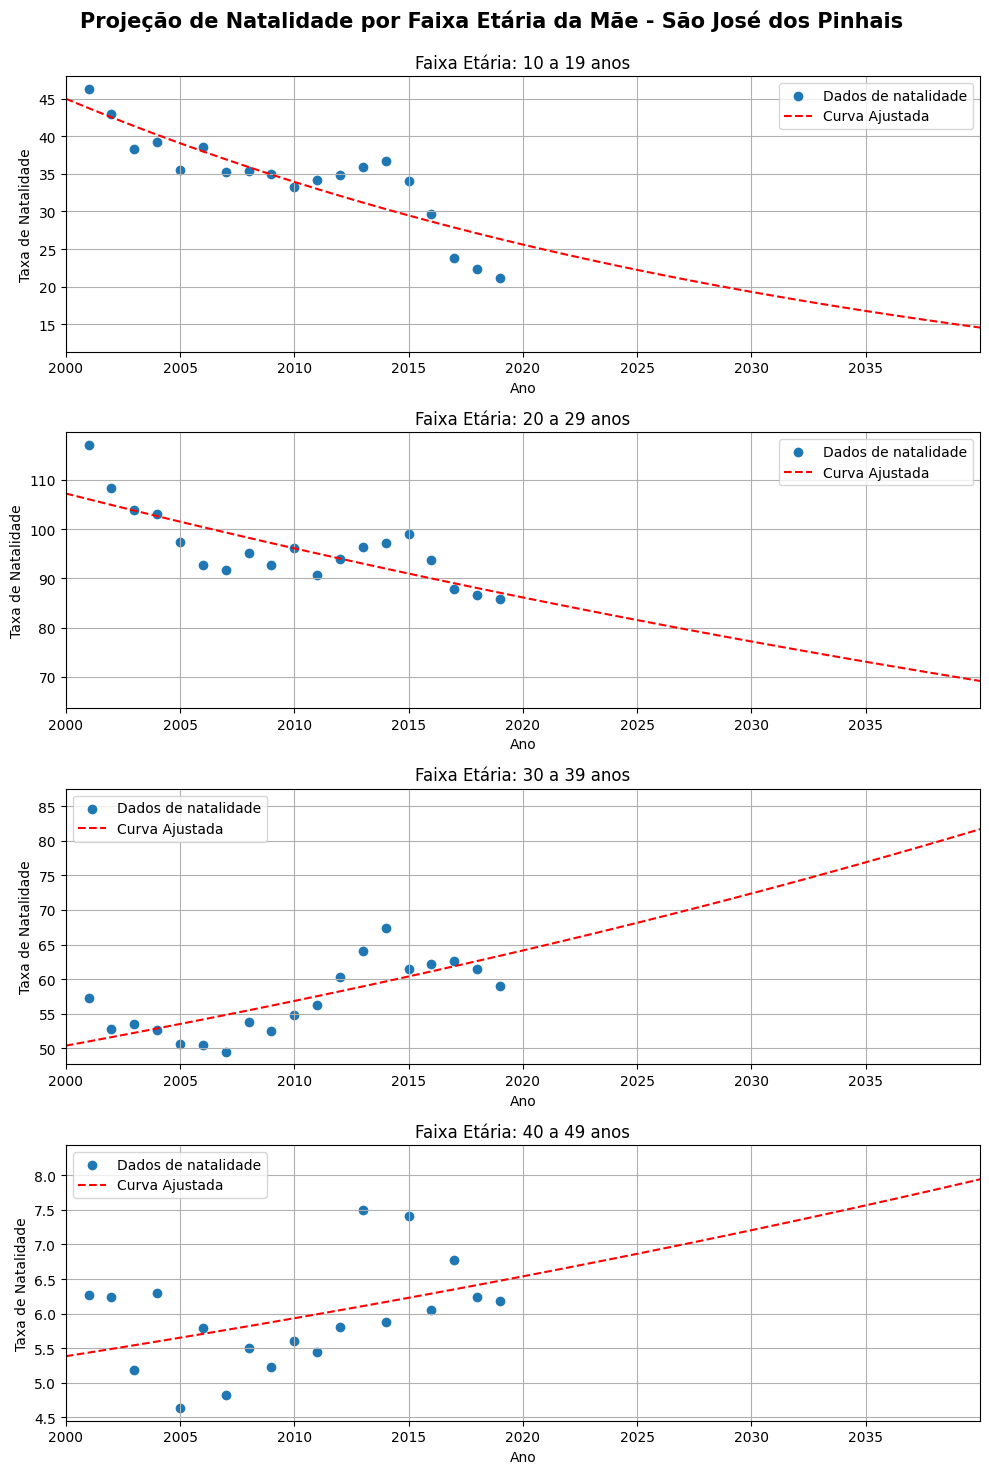

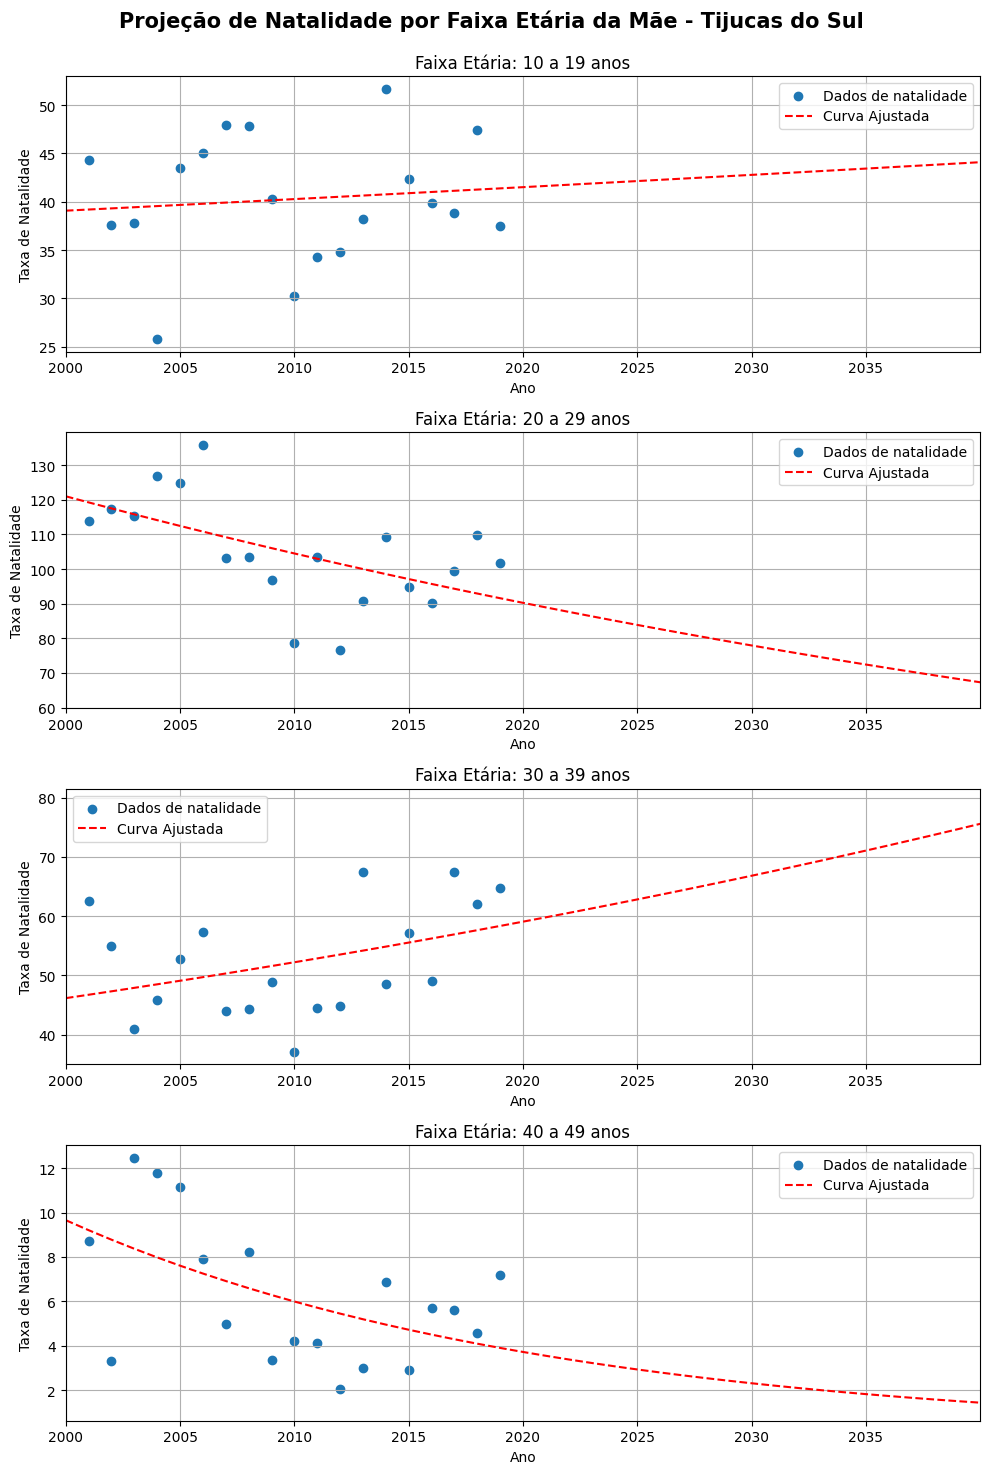

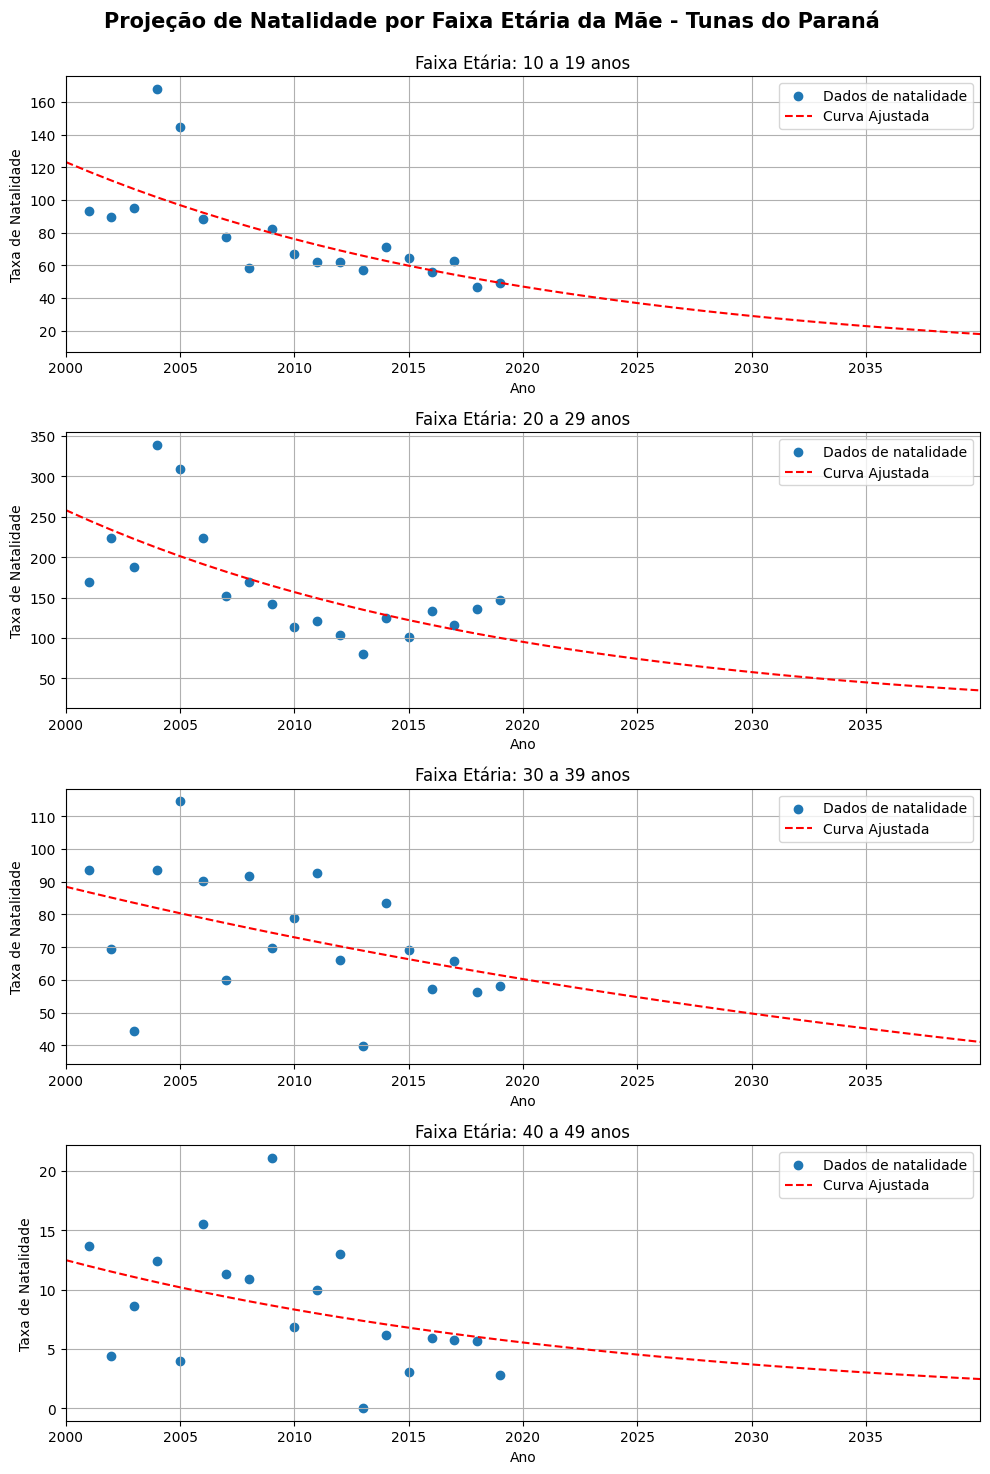

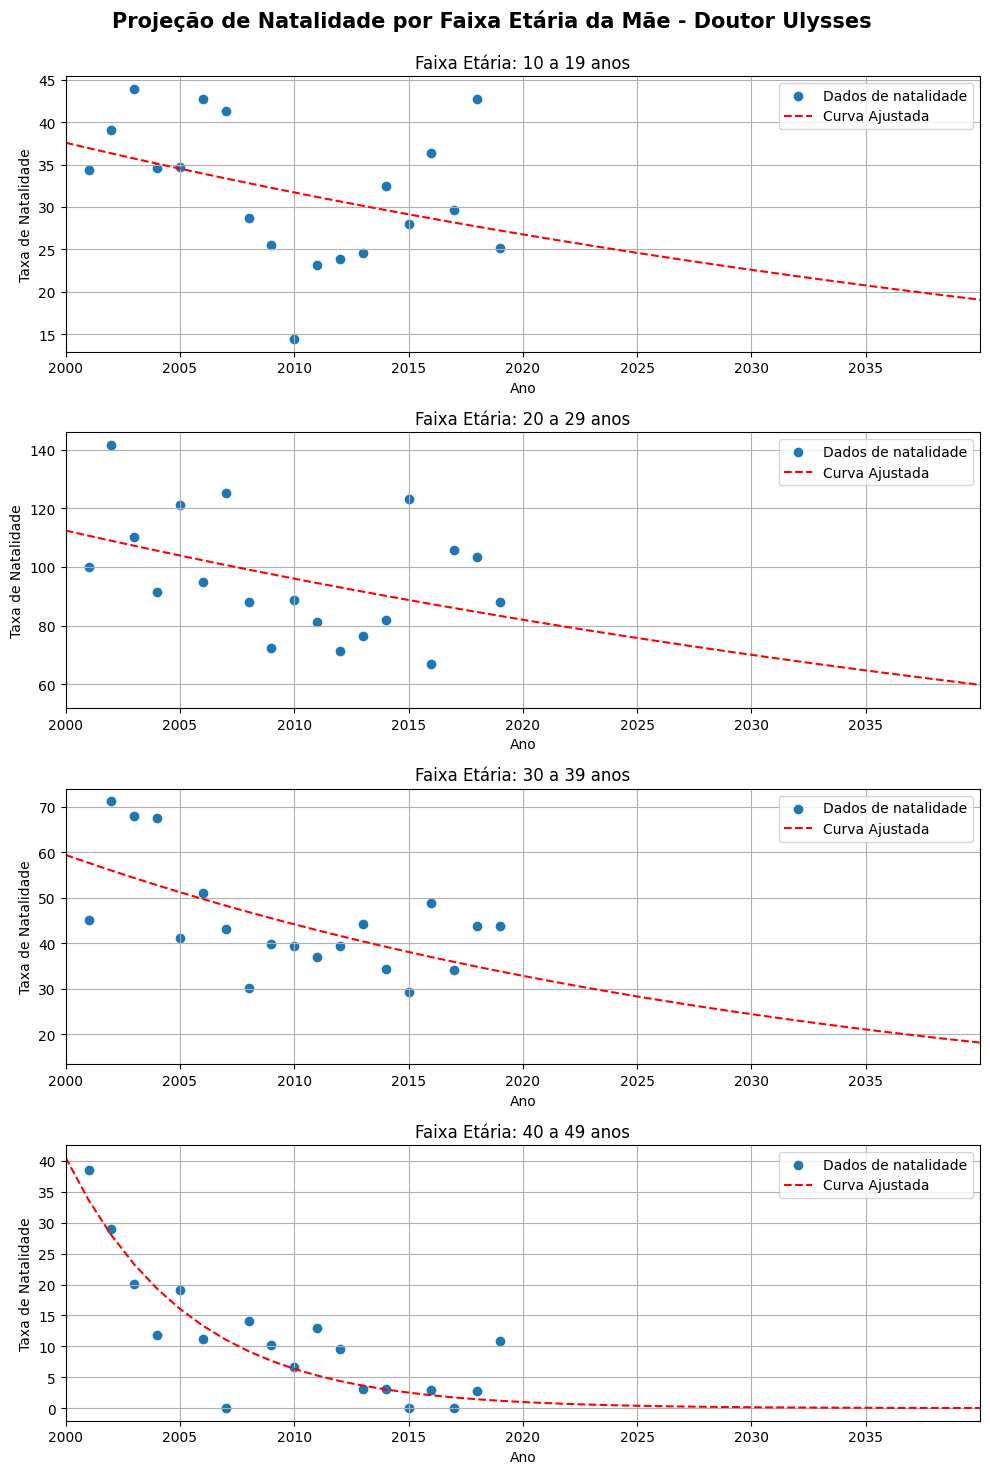

In [ ]:
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

### Função para o modelo logístico
### def modelo_linear(x, constante, coeficiente, limite):
###    return 

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)

        # Ajuste do modelo exponencial aos dados
        try:
            params, _ = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
            constante, coeficiente = params
            # Se o coeficiente for negativo, ajustar o modelo logístico
###           if coeficiente < 0:
###                params, _ = curve_fit(modelo_logistico, anos, dados_natalidade, maxfev=10000)
###                constante, coeficiente, limite = params
###                previsao = modelo_logistico(anos, constante, coeficiente, limite)
###            else:
            previsao = modelo_exponencial(anos, constante, coeficiente)
        except RuntimeError:
            constante, coeficiente = np.nan, np.nan
            previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Constante': [constante], 'Coeficiente': [coeficiente]})
        
            # Calcular as previsões do modelo para os anos futuros
        anos_futuros = np.arange(0, 45)
        previsao = modelo_exponencial(anos_futuros, constante, coeficiente)
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_futuros + 2000, previsao, label='Curva Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
"""